In [35]:
import Analyzer
import Plotter
import Helper
import sqlite3
import pandas as pd
import statsmodels
import scipy
import numpy as np
from matplotlib import pyplot as plt,rcParams
from matplotlib.backends.backend_pdf import PdfPages

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'Arial'
rcParams['axes.grid']=False
rcParams['font.size'] = 20
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

In [3]:
#Create cursor to database  
dbfloc = '/home/bmassi/Dropbox/science/leelab/projects/Arithmetic/data/_curatedData/'

conn = sqlite3.connect(database=dbfloc+'arithmeticstudy.db')
cur = conn.cursor()

In [4]:
#Pull out all of the trials from the quad-dots experiments. 
query = '''SELECT animal,experiment,session,trial,augend,addend,singleton,
        chose_sum,aug_num_green,add_num_green,sing_num_green,
        aug_num_quad,add_num_quad,sing_num_quad,
        0 + (aug_num_quad+add_num_quad+sing_num_quad)>0 as quad_trials,
        augend+addend-singleton as diff FROM behavioralstudy
        WHERE experiment= 'QuadDots' 
        ORDER BY animal,session,trial'''

data = Helper.getData(cur,query)

# Get quad/uni balanced trialsets

We want to get trialsets that contain matching quad and uni trials. In particular, for every quad trial in our balanced trialset, there will be a uni trial with the same augend, addend, and singleton. This way, aug/add/sing are identically distributed over quad and uni trials within a session, which makes for easy comparison.

In [5]:
#Pull out a balanced set of quad/non-quad trials 
#This iterates over quad trials, and finds a matching uni trial for each quad trial, and
#both trials are appended to a new balanced trialset.
#If there is no matching uni trial, the quad trial is thrown out.
def balanceQuadUniTrials(data,animal='Xavier',session=1):
    #Shuffle the trials.
    data = data.sample(frac=1)
    
    #Get the quad and non-quad trials
    quad_trials = data.loc[(data['quad_trials']==True) & (data['session']==session) & (data['animal']==animal)]
    nonquad_trials = data.loc[(data['quad_trials']==False) & (data['session']==session) & (data['animal']==animal)]

    #Iterate through the quad trials, and find matching singleton trials.
    curated_trialset = []
    for i in range(0,quad_trials.shape[0]):
        q = quad_trials.iloc[i]
        
        #Get out the target non_quad_trials
        target_trials = nonquad_trials.loc[(nonquad_trials['augend']==q['augend']) & 
                                          (nonquad_trials['addend']==q['addend']) & 
                                          (nonquad_trials['singleton']==q['singleton'])]
        
        #If there is more than one applicable trial
        if(target_trials.shape[0]>0):
            sample = target_trials.sample(n=1)
            nonquad_trials.drop(sample.index)
            curated_trialset.append(sample.iloc[0])
            curated_trialset.append(q)
            
    #Concatenate all the selected results
    trial_output = pd.concat(curated_trialset,axis=1).transpose()
    
    for c in trial_output:
        trial_output[c] = pd.to_numeric(trial_output[c],errors='ignore')
    
    #return it
    return trial_output

In [6]:
#Do the balancing procedure on each session.

#Get unique animal/session pairs
animal_session = data[['animal','session']].drop_duplicates().get_values()

#Balance every session.
balanced_trialsets = list(map(lambda x: balanceQuadUniTrials(data,animal=x[0],session=x[1]),animal_session))

#Pull out R and X data separately.
balanced_trialsets_r = list(filter(lambda x: x.iloc[0]['animal']=='Ruffio',balanced_trialsets))
balanced_trialsets_x = list(filter(lambda x: x.iloc[0]['animal']=='Xavier',balanced_trialsets))


#concatenate all the balanced data
all_balanced_data = pd.concat(balanced_trialsets)
all_balanced_data_x = pd.concat(balanced_trialsets_x)[['quad_trials','augend','addend','singleton',
        'aug_num_green','add_num_green','sing_num_green','chose_sum','aug_num_quad','add_num_quad','sing_num_quad']].astype(int)
all_balanced_data_r = pd.concat(balanced_trialsets_r)[['quad_trials','augend','addend','singleton',
        'aug_num_green','add_num_green','sing_num_green','chose_sum','aug_num_quad','add_num_quad','sing_num_quad']].astype(int)

In [10]:
# Lets get some simple descriptive stats on the balanced trialsets.


print('P(quad) = %.4f' % np.mean(all_balanced_data['quad_trials']))
print('P(augend quad) = %.4f' % np.mean(all_balanced_data['aug_num_quad']>0)) 
print('P(addend quad) = %.4f' % np.mean(all_balanced_data['add_num_quad']>0))
print('P(singleton quad) = %.4f' % np.mean(all_balanced_data['sing_num_quad']>0))

P(quad) = 0.5000
P(augend quad) = 0.1552
P(addend quad) = 0.1510
P(singleton quad) = 0.1937


# Now we compare performance in quad and uni trials in these balanced trialsets.


## Lets look at psychometric curves, and performance as a function of operand values. 

In [26]:
#Define some functions for getting psychometric curves.

#generates a psychometric curve representation from some data
def get_psychometric_curve(data):
    
    #Get unique differences
    diff = data['augend'] + data['addend'] - data['singleton']
    udiff = np.unique(diff)
    
    #get data at each difference
    p_choose_sum = []
    p_choose_sum_SEM = []
    for ud in udiff:
        p_choose_sum.append(np.nanmean(data['chose_sum'].loc[diff==ud],dtype='float64'))
        p_choose_sum_SEM.append(scipy.stats.sem(data['chose_sum'].loc[diff==ud]))
    
    #Return it all
    return np.array(p_choose_sum),np.array(p_choose_sum_SEM),udiff

#Call get_psychometric_curve separately for quad and uni trials
def get_balanced_psc(data):
    
    #Get the psychometric curve for uni and quad dots
    tdq,tdqs,udiff1 = get_psychometric_curve(data.loc[data['quad_trials']==1])
    tdu,tdus,udiff2 = get_psychometric_curve(data.loc[data['quad_trials']==0])
    
    #Unit testing. If trialsets are balanced, this should always be true.
    assert(sum(udiff1==udiff2)==len(udiff1))
    
    #Format output
    return {'udiff':udiff1,'curve_uni':tdu,'curve_uni_error':tdus,'curve_quad':tdq,'curve_quad_error':tdqs}

#Plot the output of get_balanced_psc
def plot_balanced_psc(psc_dict,ax=None,error=True,alpha=.3):
    
    #Make axes if they don't exist
    if(ax is None):
        _,ax = plt.subplots(1,1)
    
    if(error):
        ax.errorbar(psc_dict['udiff'],psc_dict['curve_uni'],psc_dict['curve_uni_error'],color=[0,1,0],alpha=alpha)
        ax.errorbar(psc_dict['udiff'],psc_dict['curve_quad'],psc_dict['curve_quad_error'],color=[0,0,1],alpha=alpha)
    else:
        ax.plot(psc_dict['udiff'],psc_dict['curve_uni'],color=[0,1,0],alpha=alpha)
        ax.plot(psc_dict['udiff'],psc_dict['curve_quad'],color=[0,0,1],alpha=alpha)
        
        
    ax.set_xlabel('Sum - Singleton')
    ax.set_ylabel('P(choose sum)')
    ax.set_ylim([0,1])
    
    return True

/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


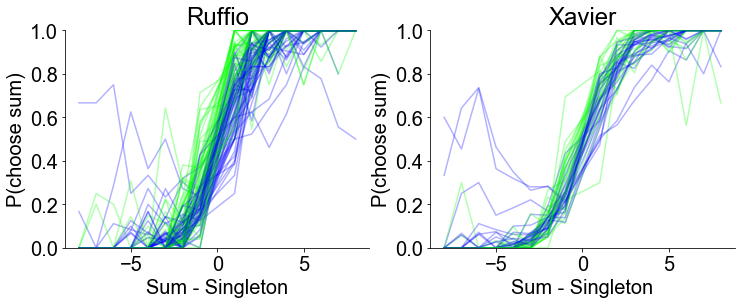

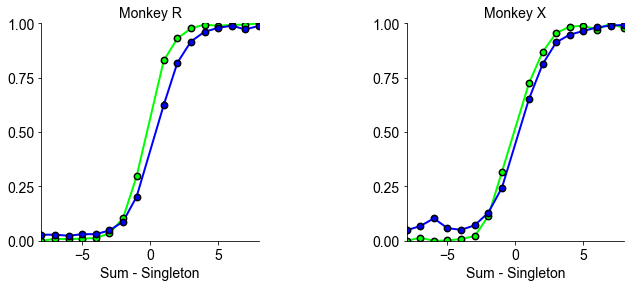

In [38]:
#Generate and visualize psychometric curves for each session.

#Declare an axes to plot it on
_,ax = plt.subplots(1,2,figsize=[12,4])

#Make a wrapper function for our map that will map data to our figure. 
plot_wrapper = lambda x,ax: plot_balanced_psc(get_balanced_psc(x),ax=ax,error=False)

#Map it to make the plots
a = list(map(lambda x: plot_wrapper(x,ax[0]),balanced_trialsets_r))
ax[0].set_title('Ruffio')
b = list(map(lambda x: plot_wrapper(x,ax[1]),balanced_trialsets_x))
ax[1].set_title('Xavier')


#Run once on the combined data.
_,ax = plt.subplots(1,2,figsize=[12,4])

# a = plot_balanced_psc(get_balanced_psc(all_balanced_data_r),ax[0],error=True)
# ax[0].set_title('Ruffio')
# b = plot_balanced_psc(get_balanced_psc(all_balanced_data_x),ax[1],error=True)
# ax[1].set_title('Xavier')

psc_r = get_balanced_psc(all_balanced_data_r)
psc_x = get_balanced_psc(all_balanced_data_x)

with PdfPages('QuadUniPsc.pdf') as pdf:
    #Plot pooled psychometric curves in quad/uni trials
    Plotter.lineplot(ax[0],xdata=psc_r['udiff'],ydata=psc_r['curve_uni'],sem=psc_r['curve_uni_error'],
                     color=[0,1,0],title='Monkey R',xlabel='Sum - Singleton',yticks=[0,.25,.5,.75,1],ylim=[0,1],xlim=[-8,8])
    Plotter.scatter(ax[0],xdata=psc_r['udiff'],ydata=psc_r['curve_uni'],identity='off',color=[0,1,0])
    Plotter.lineplot(ax[0],xdata=psc_r['udiff'],ydata=psc_r['curve_quad'],sem=psc_r['curve_quad_error'],
                     color=[0,0,1],title='Monkey R',xlabel='Sum - Singleton',yticks=[0,.25,.5,.75,1],ylim=[0,1],xlim=[-8,8])
    Plotter.scatter(ax[0],xdata=psc_r['udiff'],ydata=psc_r['curve_quad'],identity='off',color=[0,0,1])


    Plotter.lineplot(ax[1],xdata=psc_x['udiff'],ydata=psc_x['curve_uni'],sem=psc_x['curve_uni_error'],
                     color=[0,1,0],title='Monkey X',xlabel='Sum - Singleton',yticks=[0,.25,.5,.75,1],ylim=[0,1],xlim=[-8,8])
    Plotter.scatter(ax[1],xdata=psc_x['udiff'],ydata=psc_x['curve_uni'],identity='off',color=[0,1,0])
    Plotter.lineplot(ax[1],xdata=psc_x['udiff'],ydata=psc_x['curve_quad'],sem=psc_x['curve_quad_error'],
                     color=[0,0,1],title='Monkey X',xlabel='Sum - Singleton',yticks=[0,.25,.5,.75,1],ylim=[0,1],xlim=[-8,8])
    Plotter.scatter(ax[1],xdata=psc_x['udiff'],ydata=psc_x['curve_quad'],identity='off',color=[0,0,1])

    pdf.savefig()

Xavier: bias, U=0.0122 Q=-0.1878 (0.026474); slope, U=1.0548 Q=0.8505 (0.000947)
Ruffio: bias, U=0.3457 Q=-0.4275 (0.000000); slope, U=1.3241 Q=1.0256 (0.000040)


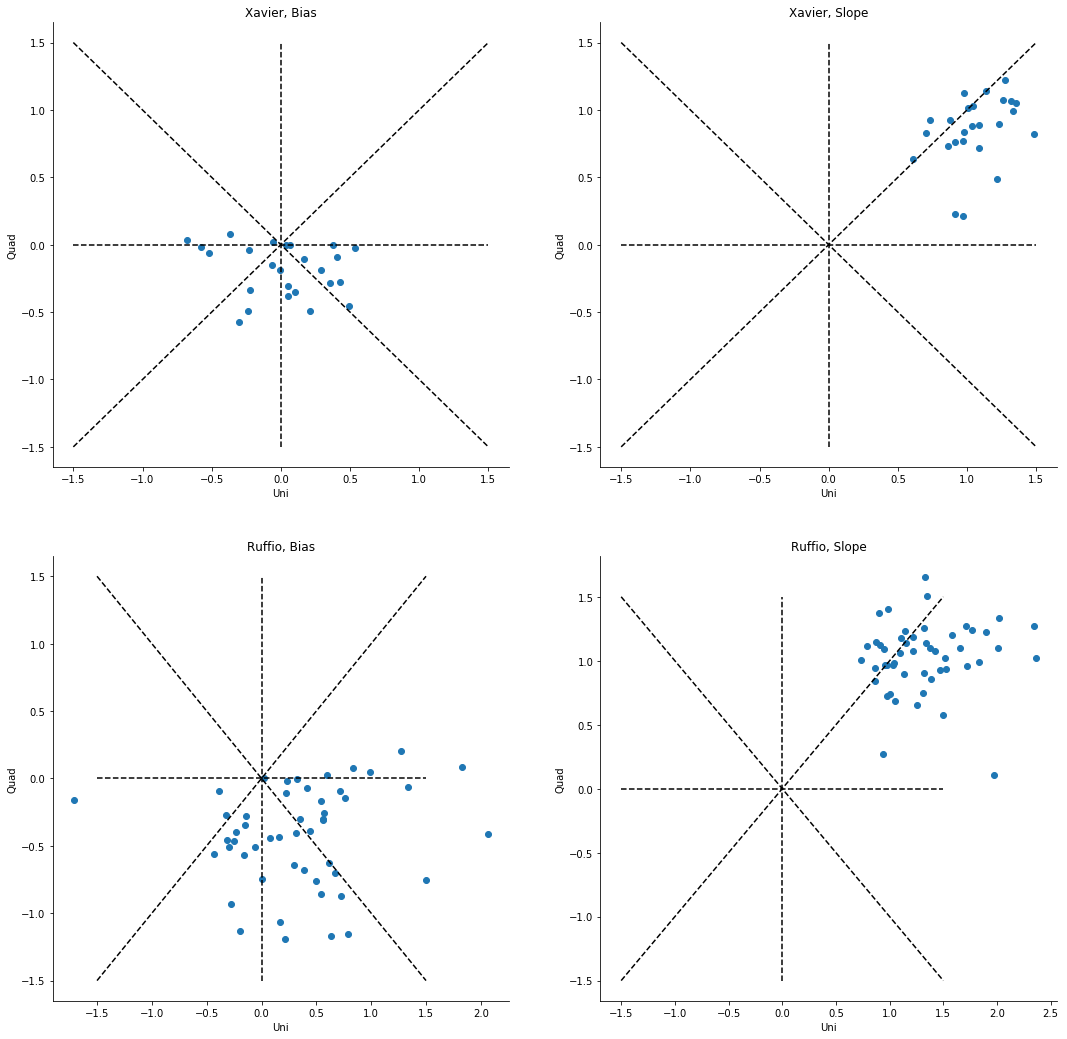

In [22]:
# Lets fit two-parameter logistic functions to the psychometric curve data for each session,
# so that we can get the bias and slope for sum-singleton on a per-session basis.

#Make model fitting function
def quad_uni_LR(df,model='chose_sum ~ diff'):
    mout_u = Analyzer.logistic_regression(df.loc[df['quad_trials']==0],model)
    mout_q = Analyzer.logistic_regression(df.loc[df['quad_trials']==1],model)

    return (mout_u['params'][0],mout_q['params'][0])

#Make a convenience function for reformatting the output
def reformat_quad_uni_LR(mout):
    bias_q = [x[1][0] for x in mout]
    bias_u = [x[0][0] for x in mout]
    slope_q = [x[1][1] for x in mout]
    slope_u = [x[0][1] for x in mout]
    
    return bias_u,bias_q,slope_u,slope_q

#Make a function for plotting it. 
def scatter_quad_uni_LR(uni,quad,ax=None):
    
    if(ax is None):
        _,ax = plt.subplots(1,1,figsize=[9,9])
    
    ax.scatter(uni,quad)
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.plot([-1.5,1.5],[-1.5,1.5],'--k')
    ax.plot([-1.5,1.5],[1.5,-1.5],'--k')
    ax.plot([0,0],[-1.5,1.5],'--k')
    ax.plot([-1.5,1.5],[0,0],'--k')
    #ax.set_ylim(ylim)
    #ax.set_xlim(xlim)
    ax.set_xlabel('Uni')
    ax.set_ylabel('Quad')
    
#Fit models
mout_x = list(map(quad_uni_LR,balanced_trialsets_x))
mout_r = list(map(quad_uni_LR,balanced_trialsets_r))

#Reformat model fits
bias_u_x,bias_q_x,slope_u_x,slope_q_x = reformat_quad_uni_LR(mout_x)
bias_u_r,bias_q_r,slope_u_r,slope_q_r = reformat_quad_uni_LR(mout_r)

#Plot it all
_,ax = plt.subplots(2,2,figsize=[18,18])
scatter_quad_uni_LR(bias_u_x,bias_q_x,ax=ax[0,0])
ax[0,0].set_title('Xavier, Bias')

scatter_quad_uni_LR(slope_u_x,slope_q_x,ax=ax[0,1])
ax[0,1].set_title('Xavier, Slope')

scatter_quad_uni_LR(bias_u_r,bias_q_r,ax=ax[1,0])
ax[1,0].set_title('Ruffio, Bias')

scatter_quad_uni_LR(slope_u_r,slope_q_r,ax=ax[1,1])
ax[1,1].set_title('Ruffio, Slope')


#Do some hypothesis testing on coefficient values
t_bias_x,p_bias_x = scipy.stats.ttest_rel(bias_u_x,bias_q_x)
t_slope_x,p_slope_x = scipy.stats.ttest_rel(slope_u_x,slope_q_x)
t_bias_r,p_bias_r = scipy.stats.ttest_rel(bias_u_r,bias_q_r)
t_slope_r,p_slope_r = scipy.stats.ttest_rel(slope_u_r,slope_q_r)

print('Xavier: bias, U=%.4f Q=%.4f (%.6f); slope, U=%.4f Q=%.4f (%.6f)' % (np.mean(bias_u_x),np.mean(bias_q_x),p_bias_x,np.mean(slope_u_x),np.mean(slope_q_x),p_slope_x))
print('Ruffio: bias, U=%.4f Q=%.4f (%.6f); slope, U=%.4f Q=%.4f (%.6f)' % (np.mean(bias_u_r),np.mean(bias_q_r),p_bias_r,np.mean(slope_u_r),np.mean(slope_q_r),p_slope_r))


In [27]:
#This function pulls out the per-trial prediction error (average negative log-likelihood)
#In quad and uni trials, for a model fit on both simultaneously. 
def quad_uni_error_onemodel(balanced_trialsets):
    #Columns of interest for data. These need to be cast to numeric.
    #Casting should be done earlier, honestly...
    cols = ['chose_sum','aug_num_green','add_num_green','sing_num_green',
            'aug_num_quad','add_num_quad','sing_num_quad','quad_trials']

    #Log-likelihood function. We'll use this to evaluate model performance.
    realmin = np.finfo(np.double).tiny
    cost = lambda y,h: -np.sum(y*np.log(np.max([h,np.ones(len(h))*realmin],axis=0))+
                            (1-y)*np.log(np.max([1-h,np.ones(len(h))*realmin],axis=0))); 
    model = 'chose_sum ~ aug_num_green + add_num_green + sing_num_green + aug_num_quad + add_num_quad + sing_num_quad'

    #Grab predictions and error on predictions by trialtype for each session
    model_error = np.zeros([len(balanced_trialsets),2])
    for i in range(0,len(balanced_trialsets)):
        quad_trials = balanced_trialsets[i]['quad_trials']==1
        choices = balanced_trialsets[i]['chose_sum']
        model_predictions = Analyzer.fit_predict_linear(balanced_trialsets[i][cols].astype(int),model)
        
        #Grab per trial error in uni and quad trials
        model_error[i,0] = cost(choices[quad_trials==False],model_predictions[quad_trials==False])/sum(quad_trials==False)
        model_error[i,1] = cost(choices[quad_trials],model_predictions[quad_trials])/sum(quad_trials)
    
    return model_error


#Same as above function, but a more basic model (augend+addend+singleton) is fit
#to both quad and uni trials.
def quad_uni_error_twomodels(balanced_trialsets):
    #Columns of interest for data. These need to be cast to numeric.
    #Casting should be done earlier, honestly...
    cols = ['chose_sum','augend','addend','singleton']

    #Log-likelihood function. We'll use this to evaluate model performance.
    realmin = np.finfo(np.double).tiny
    cost = lambda y,h: -np.sum(y*np.log(np.max([h,np.ones(len(h))*realmin],axis=0))+
                            (1-y)*np.log(np.max([1-h,np.ones(len(h))*realmin],axis=0))); 
    model = 'chose_sum ~ augend + addend + singleton'

    #Grab predictions and error on predictions by trialtype for each session
    model_error = np.zeros([len(balanced_trialsets),2])
    for i in range(0,len(balanced_trialsets)):
        quad_trials = balanced_trialsets[i]['quad_trials']==1
        choices = balanced_trialsets[i]['chose_sum']
        model_predictions_q = Analyzer.fit_predict_linear(balanced_trialsets[i][cols].loc[quad_trials].astype(int),model)
        model_predictions_u = Analyzer.fit_predict_linear(balanced_trialsets[i][cols].loc[quad_trials==False].astype(int),model)

        #Grab per trial error in uni and quad trials
        model_error[i,0] = cost(choices[quad_trials==False],model_predictions_u)/sum(quad_trials==False)
        model_error[i,1] = cost(choices[quad_trials],model_predictions_q)/sum(quad_trials)
    
    return model_error

/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:932: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:933: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:933: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


Text(0,0.5,'quad trials mean log-likelihood')

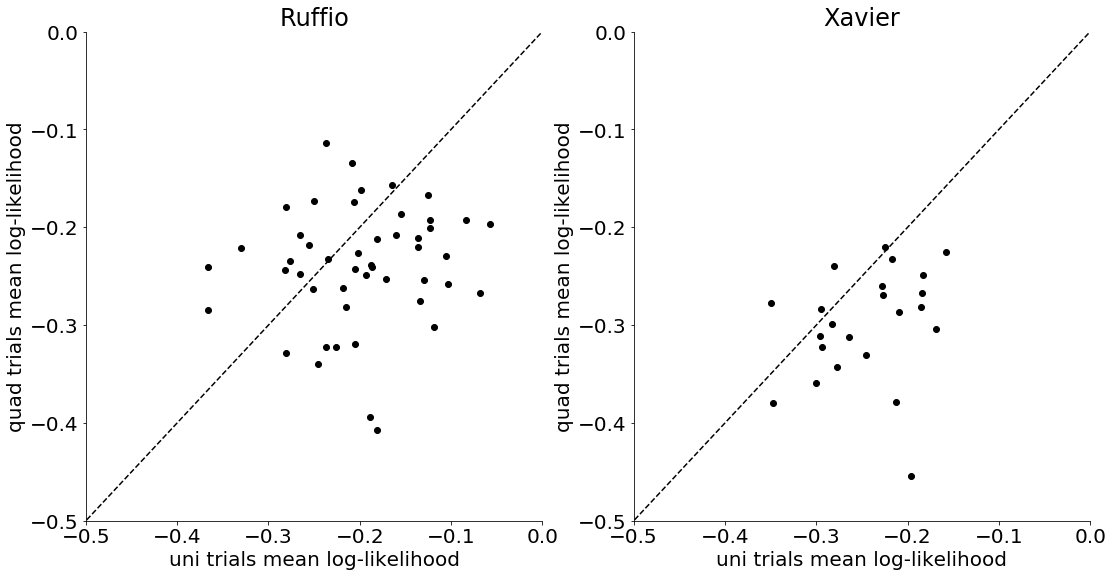

In [28]:
model_error_r = -quad_uni_error_twomodels(balanced_trialsets_r)
model_error_x = -quad_uni_error_twomodels(balanced_trialsets_x)


_,ax = plt.subplots(1,2,figsize=[18,9])

ax[0].scatter(model_error_r[:,0],model_error_r[:,1],color=[0,0,0])
ax[0].plot([-1,0],[-1,0],'--k')
ax[0].set_ylim([-0.5,0])
ax[0].set_xlim([-0.5,0])
ax[0].set_title('Ruffio')
ax[0].set_xlabel('uni trials mean log-likelihood')
ax[0].set_ylabel('quad trials mean log-likelihood')

ax[1].scatter(model_error_x[:,0],model_error_x[:,1],color=[0,0,0])
ax[1].plot([-1,0],[-1,0],'--k')
ax[1].set_ylim([-0.5,0])
ax[1].set_xlim([-0.5,0])
ax[1].set_title('Xavier')
ax[1].set_xlabel('uni trials mean log-likelihood')
ax[1].set_ylabel('quad trials mean log-likelihood')

## Lets get some descriptive statistics.

In [235]:
#Descriptive stats

#Pull out various descriptive statistics.
def get_descriptive_stats(data):
    
    #Separate into quad and uni trials
    qdata = data.loc[data['quad_trials']==True]
    udata = data.loc[data['quad_trials']==False]
    
    #Pull out p(correct)
    p_correct_quad = np.mean(qdata['chose_sum']==((qdata['augend']+qdata['addend']-qdata['singleton'])>0))
    p_correct_quad_SEM = scipy.stats.sem(qdata['chose_sum']==((qdata['augend']+qdata['addend']-qdata['singleton'])>0))
    p_correct_uni = np.mean(udata['chose_sum']==((udata['augend']+udata['addend']-udata['singleton'])>0))
    p_correct_uni_SEM = scipy.stats.sem(udata['chose_sum']==((udata['augend']+udata['addend']-udata['singleton'])>0))
    
    #p(correct) data
    descriptive_stats = {'p_correct_quad':p_correct_quad,'p_correct_quad_SEM':p_correct_quad_SEM,
                        'p_correct_uni':p_correct_uni,'p_correct_uni_SEM':p_correct_uni_SEM}
    
    return descriptive_stats
    
#make a scatterplot of p(correct) in quad and uni
def scatter_pcorrect(desc_dict,ax=None):
    
    #Make axes if they don't exist
    if(ax is None):
        _,ax = plt.subplots(1,1)
    
    ax.scatter(desc_dict['p_correct_uni'],desc_dict['p_correct_quad'],color=[0,0,0])
        
    ax.set_xlabel('p(correct | uni trial)')
    ax.set_ylabel('P(correct | quad trial)')
    ax.set_ylim([.5,1])
    ax.set_xlim([.5,1])
    
    return True

### How often are the animals correct in quad and uni-dots trials?

Text(0.5,1,'Xavier')

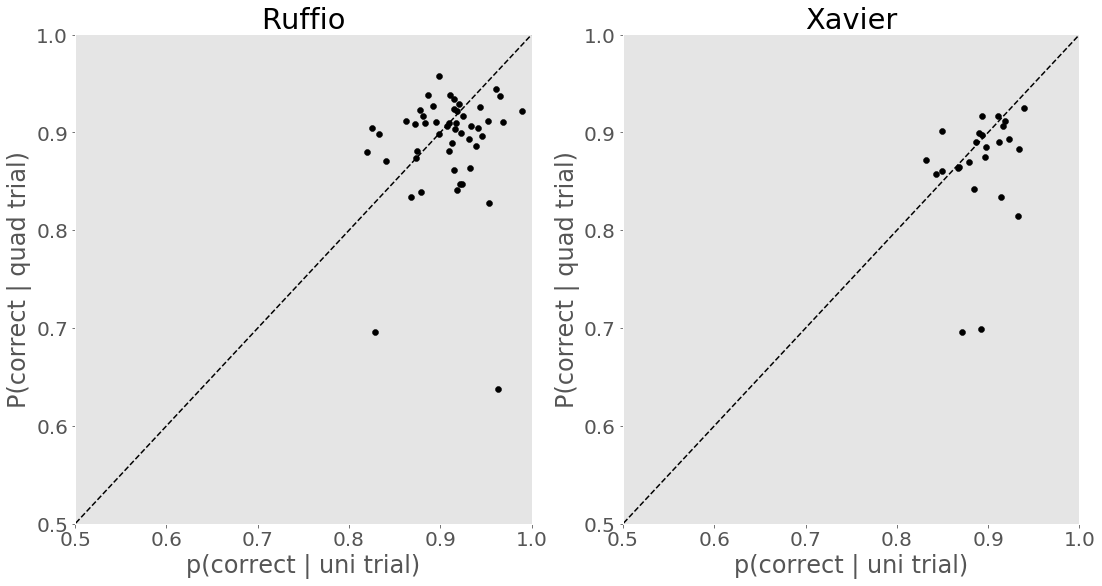

In [233]:
#Look at relative performance in quad and uni trials once they're balanced.

#Declare an axes to plot it on
_,ax = plt.subplots(1,2,figsize=[18,9])

#Make a wrapper function for our map that will map data to our figure. 
scatter_wrapper = lambda x,ax: scatter_pcorrect(get_descriptive_stats(x),ax=ax)

#Map it. 
a = list(map(lambda x: scatter_wrapper(x,ax[0]),balanced_trialsets_r))
ax[0].plot([0,1],[0,1],'--k')
ax[0].set_title('Ruffio')
b = list(map(lambda x: scatter_wrapper(x,ax[1]),balanced_trialsets_x))
ax[1].plot([0,1],[0,1],'--k')
ax[1].set_title('Xavier')

### Lets look at performance in individual trial types (e.g., combinations of augend, addend, and singleton) in quad vs. non-quad trials.

If performance is differnetly noisy in quad or uni trials, we might expect the animals to be correct more often in quad or uni trials. 

One way to examine this directly is to compare performance in uni and quad trials that have the same augend, addend, and singleton. 

Text(0.5,0.98,'Performance in matched trialtypes')

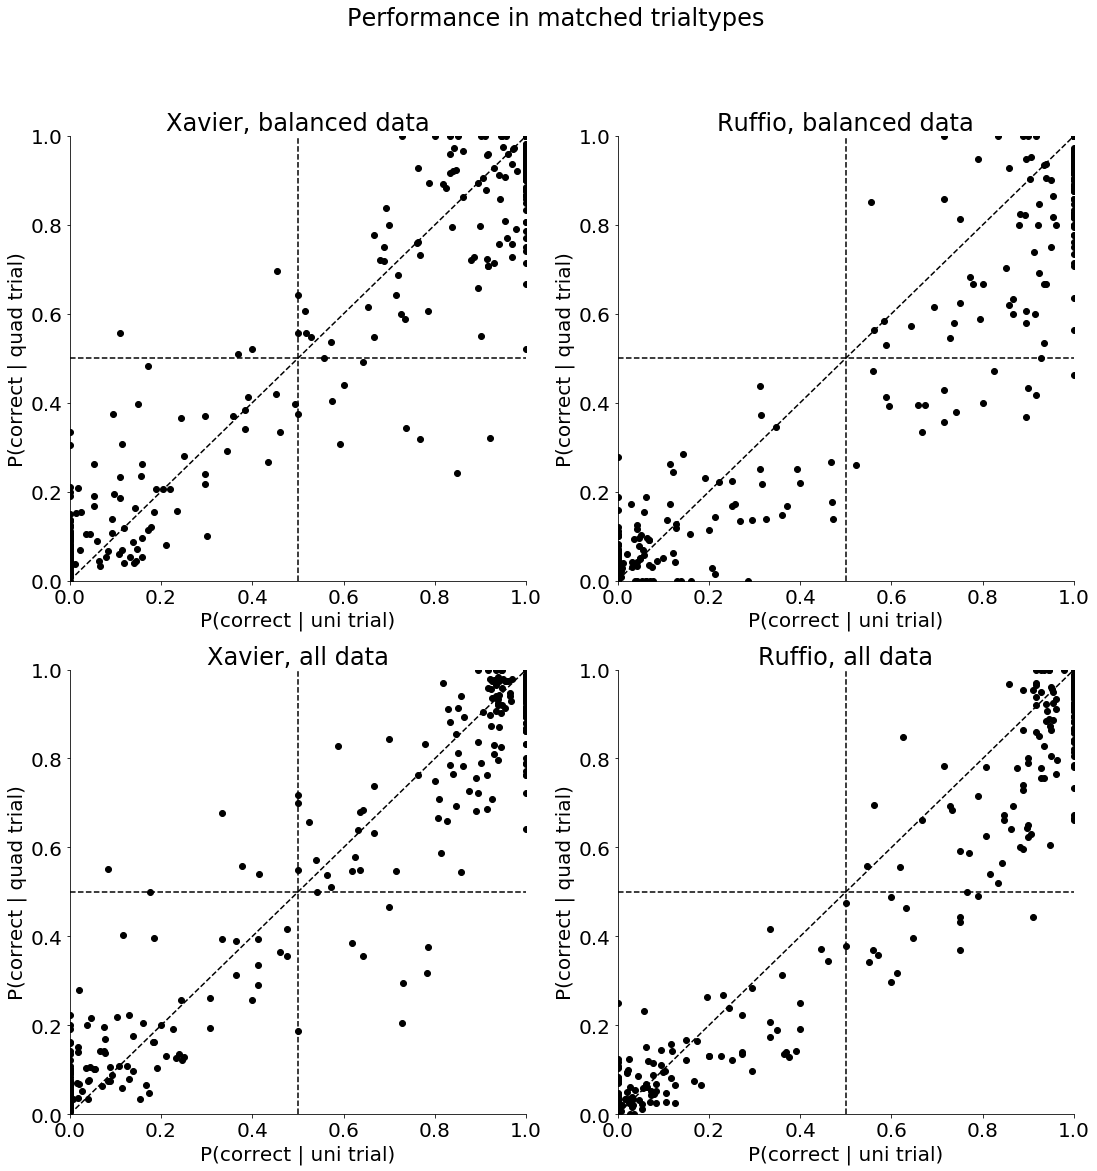

In [45]:

#Compare performance in individual trial types (defined by augend, addend, singleton)
#for quad and uni trials.
def compare_quad_uni_bytrial(data):
    gbvar = ['augend','addend','singleton']
    a = data.loc[data['quad_trials']==0].groupby(gbvar)['chose_sum'].mean().reset_index()
    b = data.loc[data['quad_trials']==1].groupby(gbvar)['chose_sum'].mean().reset_index()
    
    return pd.merge(a,b,how='left',left_on=gbvar,right_on=gbvar,suffixes=('_uni','_quad'))

def scatter_quad_uni_trial(merged_data,ax=None):
    #Make axes if they don't exist
    if(ax is None):
        _,ax = plt.subplots(1,1)
    
    ax.scatter(merged_data['chose_sum_uni'],merged_data['chose_sum_quad'],color=[0,0,0])
        
    ax.set_xlabel('P(correct | uni trial)')
    ax.plot([0,1],[0,1],'--k')
    ax.plot([.5,.5],[0,1],'--k')
    ax.plot([0,1],[.5,.5],'--k')
    ax.set_ylabel('P(correct | quad trial)')
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    
    return True

def compare_scatter_quad_uni_bytrial(data,ax=None):
    scatter_quad_uni_trial(compare_quad_uni_bytrial(data),ax)
    
    
#Compare performance in matched trial types
_,ax = plt.subplots(2,2,figsize=[18,18])    
compare_scatter_quad_uni_bytrial(all_balanced_data_x,ax[0,0])
ax[0,0].set_title('Xavier, balanced data')
compare_scatter_quad_uni_bytrial(all_balanced_data_r,ax[0,1])
ax[0,1].set_title('Ruffio, balanced data')

compare_scatter_quad_uni_bytrial(data.loc[data['animal']=='Xavier'],ax[1,0])
ax[1,0].set_title('Xavier, all data')
compare_scatter_quad_uni_bytrial(data.loc[data['animal']=='Ruffio'],ax[1,1])
ax[1,1].set_title('Ruffio, all data')

plt.suptitle('Performance in matched trialtypes')

#compare_quad_uni_bytrial(data)

It looks like Ruffio tends to be more correct in uni trials than matched quad trials, and perhaps also Xavier. This suggests that representations are more precise in quad trials than uni trials.

# Which trials do animals treat the quad and uni versions the most different?

Lets visualize the above data differently. 
Lets look at the trials where performance in quad and uni dots trials deviates the most. 
This way, we can get an idea of how the animals treat quad and uni dots differently.


Text(0.5,1,'Ruffio, Sing-quad trials')

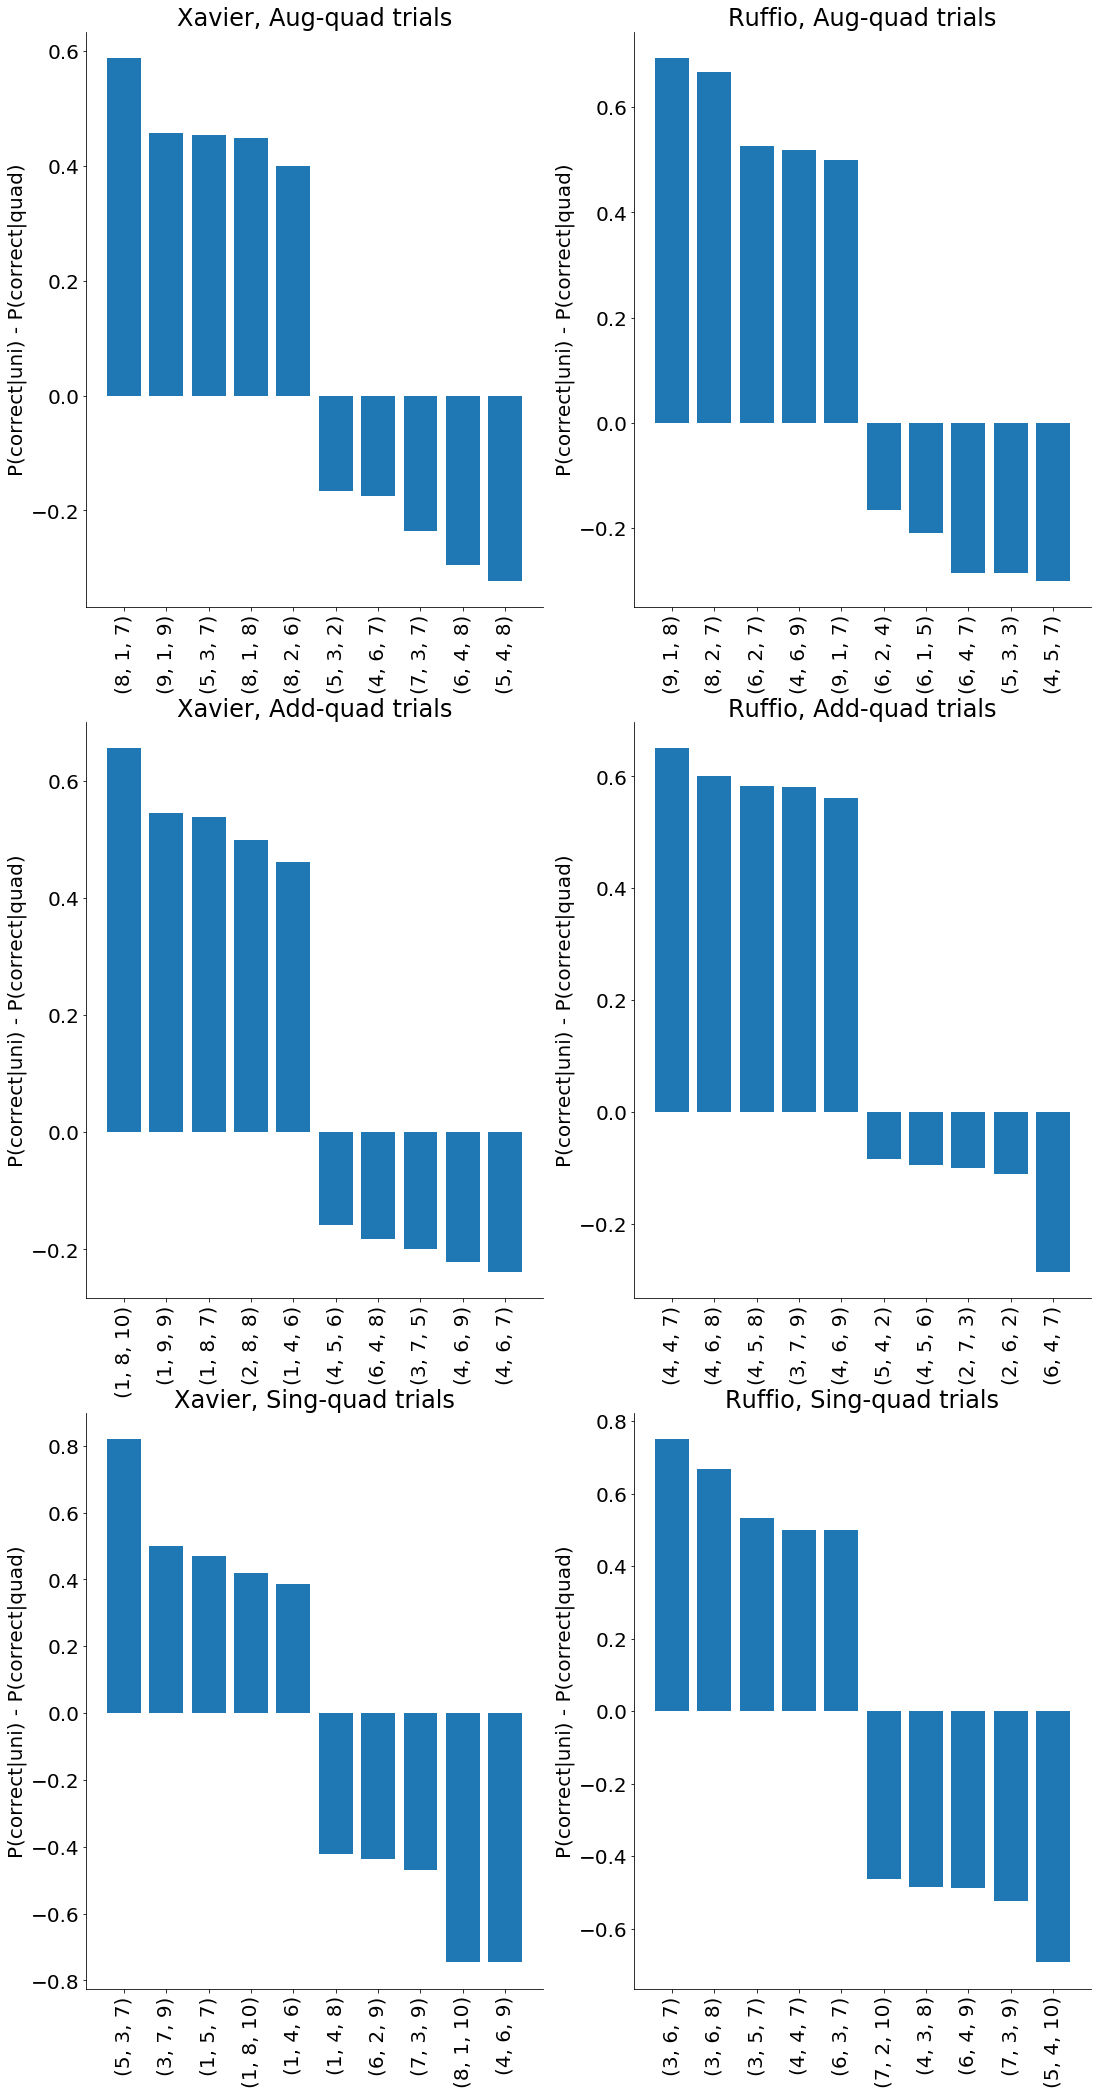

In [114]:
#Finds the difference in performance in quad and uni trials
#of a given type, and returns a data frame sorted by delta performance.
def delta_quad_uni(trial_data,ascending=False):
    
    output = trial_data.copy()
    
    #Figure out difference between quad and uni performance
    output['delta_performance'] = output['chose_sum_uni'] - output['chose_sum_quad']
    output.sort_values('delta_performance',ascending=ascending,inplace=True)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABEkAAASTCAYAAACGQGMEAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzs3XmcHFW5//Hvk5UMQTABggpJJCCriD9BBNEMCYJsigYQTYCgIUiMCirXJUECGFGvC6vsyBa9iCIqS9iDKHgRlYsIAVkmYQnBsAhhQkhmnt8f51Sm0qnq6e7pbWY+79erXj1dVefU6aqertNPn8XcXQAAAAAAAP3dgEYXAAAAAAAAoBkQJAEAAAAAABBBEgAAAAAAAEkESQAAAAAAACQRJAEAAAAAAJBEkAQAAAAAAEASQRIAQIqZDTGzk8zsETN7w8zczJgrvg8xs7Z4XVsbXZa+rFnPs5mNbYb/azO7LJZjThXzbI15tlUrTwBA/zOo0QUAgP7EzC6TdFTGptckPSnpVklnuvsz9SxXyrmSpsW/X5f0SoPKAdRcDGC0SnrA3a9rbGmaXyqgcYa796rPBjM7WNLOkha4+4IGFwcA0MRoSQIAjbFK0tK4vCBpuKT3SPqapH+Y2Z71LpCZbShpanw6yd2Hu/tm7r5ZvcuCmnpC0qOS2htdkCbQKulkSQc3uBy9xclx2agKeS1ReB8uq0JepThYoeytdToeAKCXoiUJADTGPe7emjwxsxZJkySdpfAF5Boz29LdV9SxTNso3BdedPdr63hc1JG7T2x0GQB3/6akbza6HAAAFKIlCQA0AXdvd/crJX0prtpM9f91e1h8XF7n4wIAAABNgSAJADSXX0rqjH+/r3BjHFh1ppndbWYvmdlKM1tkZpea2XZZGaYHSDSzoWY2y8weNLPX4vrj4yCOC2KSMcnAjnGZWpDfKDP7kZktNLN2M/uPmd1nZl81s6EVlmGjuN+C5Jhm9hYz+4GZPWFmK8zsSTM71czWS+U70cxuNrNlZva6mf3BzD6UU4aBZraXmZ1pZn81s6Vm9qaZPWdmvzGzCXkXpaBcw+LreDSW6wUz+x8z2zovfcxjpJmdEo/9Sjx3j8W0H89JU/b17k7egKLxtbmZLYjPDzKzO2NZl5vZn83s0xUeM339h5jZbAuDA7eb2WIzO8vM3pra/31mdq2ZPR/P8V/imBJ5+e9mZqfHMj4br+sLZjbfzA7J2H9sfM+fHFcdVfCedzMbm5FuXzP7lZk9E6/F8/GYs81siyLlG2FmPzazp2K6Z83sIjN7WzfnbayZnR3fa+3x/+WvZvZ1M1u/SLr1LAzAvNDCAMxL4vts+2LHK5LfZbb2QK9PFZyrywr3te7/13MHbjWzLS18ntwez9kb8X3457h+WGGaImVvjWVPxoI6ufBax/2+HZ/f301+R8f9njazAan1a943ZrZjPN/Px7IvjNcj8/MxlUfZ19vMNoh5/zXun3ym3W9m/21mO5Z6rgAAkbuzsLCwsNRpkXSZJFcYPDBvn6VxnwsL1r9N0gNxm0vqkPRq6vkKSZ8scszvSfrf+PebCoOyuqRPSXpe0kupfJ9PLZ9K5fV+SS+mjvlqPG7y/AFJm1ZQho3ifgvi8xMkPRL/Xh73TY7xu7jvDIWAUoek/6S2r5T0wYwy7JjaxyW9EfNOr/tWzjVJyvUlSX9LpW9PpX1R0ric9B9SGHshXcZ0mT0jTUXXu4T3YFtM31qwfmpcv0DSSaljvqK1z9HxPXjff1fSH1LlT793/iJpPUkfj+e2s+DYnZIOy8h7eEH53iw4Ty7pgoI0Wyi8t5enyvJ8wbJFav8hkq4syPMVhbGFkudzcs7zlNTfr8fXlqR5StJbc87ZJwvOT3t83yTPH5Q0Kud8/DnnvbZc0qfz3nNFrt+Z8Zwkef674FydWcH/erLfnIzj3V9w3V+Oj+n3ygYZ6Vrj9rbUuj1iGZNzubzwWsf9Nld4v7ukdxc5F3fHfb5TsD4p22dS76v/FFyzeyUNr9b1lrShpH+m9ulQ+BzvSK37Xrn/rywsLCz9fWl4AVhYWFj606JugiQKXV6SLwM/SK0fLOm+uP4uhS/dQ+K2UZJ+qK4vYeNyjvla/LLxqVTaMZIGx7/X+YJRkM9bJT2XqrDvGtcPlHSIuoIstxZ53d2VYYG6voAulLRnXD9EYdad5EvpSQpfvL6rri9dYyTdE7ffl1GGdym01DkwnjOL6zeVNFvS6njud8tIm5TrZYUvtvvG1z0gXoun4/ZfZqQdp64vqX+XtJekgalzuo+kXxekqfh6l/AebFPxIMnL8VzMTp3bUZKuUVdAYUSF7/tXFAbsPCCeu4EKQZEkqHF63OcSSZvFtJtIui5uf07SoIK8WyTdIOlwSW+XNCCu30jSzPiec0mHZpRrTtx2WTflPzfutzqmGRXXD5K0tcKAy9NzzvPL8brvnkrzsbh+rf/zVNpdFd7fqxWCDaMlWTxfu6krCHJzRtqL1PUle6q6/rd2UggurAk8VfD5lXzxHlvCte7ufz3Zb07Oa/iywv9OknaopIMUBnt1SedmpGtVzmdYseOl9rkx7vPjnO1bqStwU/g5m5ybVxT+d9+d+uyaqq6A6oUZ+VZ0vSV9O65/QeF/alDq82NrSV+XdEy515mFhYWlvy8NLwALCwtLf1rUfZBkZqqyPSm1flpcd5+koTlpfxr3OSfnmC5pnyJly/2CEbcnrQteVvwCW7B9n9RxJlRYhgVxn1WStsrYfkkqn0szto9RV5BpdJnXJnl9PytSrvacck2K299Q/FKX2vbLuO1RZfz6nVOWiq93CXm3qXiQxCXNyki3Xvwy5pKOrPB975LGFzn3LumOjO3rqyuQ8uEyj31ETHdnxrY56iZIImmH1HtqehnHTc7z85JGZmz/atz+ZMa2P8ZtJ+Tk/VZJz8Z9dil4/yetCKZmpBuRuoZeznmM6csJknT3v57sN6fMMmyp8PnwuqSWgm2t6lmQ5BPqCjoMztj+XeV8fqde81JlBBFT/18dksZU6XonQZ2vl3stWVhYWFjyF8YkAYAGs2CsmX1N0g/i6kWSfp/a7aj4eK67r8zJ6ufx8SM52x9091t6UNRkbIeL3f35wo0x73vj08N6WIZr3P3xjPW3pf4+PaMMiyQl6crti5+c7w8W2edXOeX6ncKXlaEKvzZLksxsuMIXL0n6tru/VmJZqnG9K/WGpDMKV7r7G5Jujk8rHefgXne/K2N9d9f1dYVf0ys5dnJdP2BmA8tMK4Ugi0la6O4XVpD+Qnd/MWP9dfHxnenxJsxsnMJ7cIWk87MydPeXJd0Un6av/ycVWug8J+mKjHQvSTqv3BdQoZ5+3mRy9ycVupi0SNq5ytn/XiHIsYlCi7M14vgjR8anlxbJ4/x4ngtdIekZheuTfCb09Hq/Gh+Ljm0DACgPUwADQGOMLxgIMW2JpIPd/U1JMrNBCmOBSNKPzez7OemSL4B5A0jem7O+W2Y2RF1fTu8ssusdknaX9P96WIZ/5Kx/IT6+oa5gSKGlCk3N31q4IQ74+HmFLh7bx30K74VvL1Kuv2StdPdVZvaCQreU9HF3ifm7pPlF8k2XsVrXu1IPx6BElmfj4zrntkTdXVdJeihnn6V5x47n7ChJh0p6j0KLiSEFu60X0y4rtbDRB+LjjWWmS2S+Z9R1LqXQNSg553vExyEKA6Tm5Ts8Pqavf/J/d7e7dypbVpCqFir+vJEkM/uIpM8q/C+8TV2zb6UV+18tm7uvNrPLJf2XpKMl/Sa1eV9J71AITPyqSDYLcvLuNLO7FcaESX8+9uR636jQnelLZjZSIXD6xzKCsQCADARJAKAxVimM4SF1jS3xpKRbFVpqvJzaN/2Fb0QJeefN/PDvCsqZLkPS+vDZIvs9Ex836WEZluSs74iPS909L8iU7DM4vTLOJLJAYWySxOvqGhRyoKSNFbp25Cn25eONjOOOio//cff/FEmbVq3rXalyX2M5uruucvfu9im8rsMVWrjskVq9QuG9lgQKkuuwvsoPkiRpF5eZLpF5Pt39jdQX4vRrSloFDEwdu5iW1N/J/91zRfYv9v9bTRV/3pjZWZK+mFqVfF6uis9HKJyzYv+rlbpYIUiyn5mNcvckOPfZ+Pg/7t5eJH2x85tsS38+Vny93f0KM/ugpOkKAwRPkdRpZg8qtIo5r8j/EwAgB91tAKAx7nH3zeLyNnffyt33cff/LgiQSGt/Vr/H3a27JeeYHTnry1V0GstuVKsMlThDIUDypMIYIiPcfbi7b+rum6mrxUA15f4sXES1rnd/cZJCgGSZQmuSUe7ekrqu70jtW8m5qvf5Ta7/30u59u4+tcz86/V6KvpfN7P9FAIkHQpjxmylMC7PyOQzU2HWHKkGr8Xd/6XQ2maQQlcrmdkIhcF2peJdbbqTVd4eXW93P1ahld+pCkHglQrdkE6S9K/YIgcAUAaCJADQ/F5U1xeO7RtUhpfU9av8mCL7bR4fe9Jqpepid6GPx6eT3f3ajGBUKb/ilisZu2VDM9uwxDTNcL17k0Pj4xfd/Qp3f6Fge0+va3INi73vqylpubB17EZUjuT/rlg3lGYfvyK5nhe7+ynu/kRGq7Fa/K+mXRwfj46PUxRadz3s7v+bnWSNUs59+vOxJ9dbkuTu/3T3k919L4WuWwcpdG1bX9LlZlZpyy8A6JcIkgBAk3P3VZLuj08/2aAyvKmusSL2KrLrhPj4t9qWqGwbq6sFzN9z9tm7Bse9X2FaT5O0XykJmuF69zJJYK6S65oE/oq1SEgGjC3p+lVBMpbHcIUZo8qR/N/tafmDW4yvqFRBEqyoZWuUotfTzMYoNThyGUq51olfKUzlu72Z7aauYEkprUgyz2+8Hh+KT9Ofjz253utw9zfd/Xp1BZvepjBGEwCgRARJAKB3uCw+TjKzYkEKmVmlg2p2JxmscGoc36PwuPsoDNoqhWlvm0kyfawkvbtwY3w9Xyxc31Puvlxdgz+eYmYblJj0svjYyOvdWyRjvWRd1+GSZhVJm8wOslGRfa5UeO9sa2bHVlTCMrj7QnUFZr6fnvmmkJkNM7N097drFYIB71Bo/VC4/1sVBi6uVCnnq6dyr2f0XVUWpCm57HEmp6vi0x8pdF9ZpfBe6M5xZpZ1jCkKg652Klyn5FgVX+/YQi7PitTfPekiCQD9DkESAOgdLlGoSA+QdL2ZfTn2k5ckmdmmZvZpM1sg6cs1KsM5CgNvDpM038x2icceaGaTJP1P3O82d7+jRmWoSAxWJF9ELjWznaUwraeZTVQYg6BWv45/S2HwzndJ+oOZ7RWnE5WZbWRmB5jZDQVpmuF69xa3xscfm9n4pAWFme0q6XaFVkR5/hkf9zSzzF/b3f2fki6IT881szlmtmk8xkAz2zqu60nwodAXFcaW2FHS3Wa2d9IVI75ndzCz2ZKeUKr7TJwCO2ntcL6ZHZl0tTCzdyvMsLReD8qVnK8jK5xOuRTJ9TzWzD6bBALMbHSceebTCoMtlysp+0ezgrwZLoqPyZTg12d05cqynsLn446SZGaDzewodU3ve4m7Fw4CXNH1lnSbmZ1lZh+OM3cpptlBXYHWJcqfVQoAkIEgCQD0ArELxscl/UlhdoMzJC0zs5fM7DWFfu0/V2jqnTfrS0/L8LKkgxW+oOwk6S9m9qqk5QqtTN4q6UFJk2tx/Co4QeHX1XdL+ruZLVco+22SRkr6XC0O6u6PK1y7VxR+kb5DUruZvaJwLq+XtH9BmoZf715ktsKgrVsoDFzZHq/tfQrX+tNF0i5Q+OI5QtKjZvaCmbXFZfPUfscrtI4aKOlkSUvN7GWF2X4ei+s2q9YLcvf7JX1CoVXFexUCB6+b2bJ4zIcknabwhbnw+p+gMLBpi6TLJb0W32sPStpB0nE9KFoyVsfxkpab2aJ4rn7YgzwLXaYQIBykECxsj+d6kaQjFc71gxXk+xuFsZXeJekZM1uSXOusnd39QXV1e5NKH7B1hsL77h/xvC9XeE0tCq/rKxnHqvR6v0UhwHKXwvV4ycxWxP33ktQu6Qh3X11i2QEAIkgCAL1G/BVzvEIQ4kZJLyj0YzdJCxW+UOyv0By9VmW4T2Ew0Z8ofDkcrDDmxv2STpS0W4m/ttZdHHBxd0nXKQQnBiucwwsUghf/V8Nj3ylpG0nfV/gCs1rhS+Bjkn6hrpkz0mkafr17A3d/UtL7FbpHvKAQyHhF0jxJu7r7LUXSrpI0UaEbxbMKgb4xcRmU2m+lu39KIXD1e4UgVTKd8J8VuvRcpCpy95sUvtB/R2EMizcUuoq8KukeSd+WtF1sPZJOt1xSa9z+WFz9hqSrFc7TvaqQu/9M0jEKAajVCoGpMSreWqfcY7ypMI7M9xRmouqMx7pV0kHuflqF+S5TCBxcqzBw6ibqutZ5km4xSyTdVOKh7pG0m0JQbaVCUONRhevRGq9PVvkqud7TFIJGdypMUZ20Jlmo0PJvR3e/vcRyAwAiW3fAcAAAAKB/M7NbFQI233f3b3Szb1Khfqe7t9W6bACA2qElCQAAAJBiZlsptDJydXUzAgD0AwRJAAAAgCjOinS2Qte26+O4QgCAfoIgCQAAAPo9Mzs+DuS6TNJHFcYFKdrNBgDQ9xAkAQAAAMJAqWMkdSgMlrqPuz/c2CIBAOqNgVsBAAAAAABESxIAAAAAAABJBEkAAAAAAAAkESQBAAAAAACQRJAEAAAAAABAEkESAAAAAAAASQRJAAAAAAAAJBEkAQAAAAAAkESQBAAAAAAAQBJBEgAAAAAAAEkESQAAAAAAACQRJAEAAAAAAJBEkAQAAAAAAEASQRIAAAAAAABJBEkAAAAAAAAkESQBAAAAAACQRJAEAAAAAABAEkESAAAAAAAASQRJAAAAAAAAJBEkAQAAAAAAkESQBAAAAAAAQBJBEgAAAAAAAEkESQAAAAAAACQRJAEAAAAAAJBEkAQAAAAAAEASQRIAAAAAAABJBEkAAAAAAAAkESQBAAAAAACQRJAEAAAAAABAEkESAAAAAAAASQRJAAAAAAAAJBEkAQAAAAAAkESQBAAAAAAAQBJBEgAAAAAAAEkESQAAAAAAACQRJAEAAAAAAJBEkAQAAAAAAEASQRIAAAAAAABJBEkAAAAAAAAkESQBAAAAAACQRJAEAAAAAABAEkESAAAAAAAASQRJAAAAAAAAJBEkAQAAAAAAkESQBAAAAAAAQBJBEgAAAAAAAEkESQAAAAAAACQRJAEAAAAAAJBEkAQAAAAAAEASQRIAAAAAAABJBEkAAAAAAAAkESQBAAAAAACQRJAEAAAAAABAEkESAAAAAAAASQRJAAAAAAAAJBEkAQAAAAAAkESQBAAAAAAAQBJBEgAAAAAAAEkESQAAAAAAACQRJAEAAAAAAJBEkAQAAAAAAEASQRIAAAAAAABJBEkAAAAAAAAkESQBAAAAAACQRJAEAAAAAABAEkESAAAAAAAASQRJAAAAAAAAJBEkAQAAAAAAkESQBAAAAAAAQBJBEgAAAAAAAEkESQAAAAAAACQRJAEAAAAAAJBEkAQAAAAAAEASQRIAAAAAAABJBEkAAAAAAAAkESQBAAAAAACQRJAEAAAAAABAEkESAAAAAAAASQRJAAAAAAAAJBEkAQAAAAAAkESQBAAAAAAAQBJBEqDqzKzVzNzM2hpdlnKZWVsse2udj7sgHndqPY/bm5jZnHiOLqtB3pfFvOdUO28AQPWZ2TZm9kszW2pmHfEz/OLU9iFmdrKZLTSzN+L21XHb3vH54417BWszsz/GMk2p83GvisedXc/j9iZmNi2eo9tqkPd3Ct+7QDMgSIKmZWY7mdmb8cPzs93s+8O431IzG1GvMgLIZmY7x8DO1EaXBQCqKRVYLlxeM7N/mtlPzWy7Gh5/Y0l3SzpU0iaSXpa0VNJ/UrtdIGmOpG0krY7bn69VmYBmYWZbxvrHlxpdFvReBEnQtNz9QUnfj09/ZGZvy9rPzN4v6fj4dKa7v1SP8hXRLulRSU80uBxAI+0s6WRJUxtcDgColVUKwYelkl6Q1CJpe0nHSXrAzA6t0XEnKwRHHpH0dnff2N03c/evSlL8seiIuO/B7j48bt88rntd1FPQd22pUP8gSIKKESRBsztN0sOSNpL008KNZjZE0qWSBkq6zt2vqW/x1uXu97n7tu4+sdFlAQAANXNPDD5s5u6jJK0naT9JbZKGSPqZmW1Sg+PuEB9/5+5ZrUO2VagXLXX33xZudPd7Yz1l3xqUDQB6PYIkaGru/qakz0nqlHRwxq8ysxUqC69ImlHn4gEAAEiS3H2Vu89XaOkhSetLmlSDQw2Lj8sr3A4AKIIgCZqeu/9Z0tnx6TnJmCNm9h5J34jrv+LuS7LSm9luZna6mf3ZzJ6N45y8YGbzzeyQnDT/iv2LZxYrm5ndHPf7cWpdtwO3mtlYMzvbzB41s/bYj/mvZvZ1M1s/J03S53msmW1nZpeb2dNmtsrMritWzkqY2Wgzuzge4w0zeyqO/bJhzv5DzOwAM7vIzP7PzJbFdIvMbJ6Zva/CcuxoZieZ2d1mttjMVprZi3Gw12lmNjAn3VoDnZrZUWb2v/Fcv2pmd5rZR7o59mAzm25mt5vZv+OxF5nZLXF93rU6yMx+a2bPp95vvzezor/aWRiI7xdx/xUWBtw72cyGlni6iuW9WyzDS2a23MweMLMvm1nR+0Al59/MXNLP4tPxtm6//dbUvm8zs+PM7Ib4f9cer8/fzewUM9uop68dAOrsXnUFKLYv3GglDIRpGQNaWhzcVFIyuOlpqc/V1Um+kpJ8xxV89k6J+XQ7cKuZTTSz36TuY8+b2bVWh4HdzWykmZ0Z6x1vmNkzZna+mW2Ws//AWN6zzexvFsanW2lmz/WkzGa2lZmdaGZ3pMryipnda2YnmNl6OenWur5m9vF4z3wl3n/vNbPDujn2ADP7tJndmHo9z8R8vmw54++Z2YfN7Oq4b3K/vtXMPtXN8Ta3UOd7Lr7OJ6xIna8cFuqsV1uoR60ws0divaJo3aaS829mz0i6NT4tfP+vNTBwfJ8dHd/nCy3UD5dbGFfoh3nvN/QT7s7C0vSLwq8xT0pySVdIGiTpr/H5LUXSDY/7JMubkl4tWHdBRrpT47Z7iuS9qcJgaC5pl9T61riuLSfdJyWtSB2/XdLK1PMHJY3KSJdsP0KhP7HH17JCoatRNc5zW8x3mkL/apf0WkF5/yXpbRlpDyw4r68XpFsl6Yic4y6I+0zN2LYslcdqhVZD6ePcIGlQRro5cftlki5Opf9PKm2HpEk5ZXqHpL8X7PuyQqumZF1rQZrBkq4qKN9/Cp7/IOd4H05d1yRd8r64R9J3k9dTwXU9PPVe9fg6VsW/fyXp8vj3nGqcf4XBAZPX/WZ8nl72SO37q4L8Xo7nOnn+uKTNG/0ZxMLCwpIs8b7ikhbkbDeFIIlLOjdj+7S47bYix/hO3Ofi1Lrfxs/Q5N76Wupz9RlJn4l/v5T6zE5/9k6K+eydfL7mHPt7qc/gzox732k1OKd/jHmfoK76XnvqPHp8DdtkpN254D7yRkE6l/RfOcdN7tmzM7Y9kHEe0nn+r6Thxa6vpFPUVYcovH/OzCnTRpJuzzh2+t44JeM998OC/F8tuG5XSRqQcbwdtfa9Pl3vWyjpa929X4tc1720dl0wXbe5W2HswbXe5z05/5L+pvz3/5r/gbjvGQX5vaK160rPS9qx0Z83LI1ZGl4AFpZSF0kTUx9cv42PyyWNLZKmReFL3OGS3p7cHOINaGa8EbikQwvSbZM6Vmb+kr4Qtz9WsL5VOUESSbsqfGlcrVAJGR1vbAMl7SbpzzHtzRlp0zevBckHd0w/rkrnuC11o/iXpD3j+gGSPi7p33H7OoGp+LovlTRB0sjU+tGSfhLTrZA0OiPtAuUHSa5VqHCMVvwyrhA0myJpSUx3Yka6Oer60r1C0ucltcRt75R0V9z+nNb9kj9UXUG4f0s6UtL6cdswSbvE17RbQbrkdT4l6dOKN2+FYN10dQUOPl2Q7q0KA/95PO574vrB8divq6tydVmZ13ScuiooN0vaMvW/8RWtHfiYU8XzP1VFvkSk9jtd0iyFX1vXS73u8ZLui3ncUKvPFRYWFpZyF3UfJPmguu7ZX83YXlGQJLUt94t93N5dECR3e/xsT8p+huL9XNLGks5NbTu8yuc0CZK8ovDldH9JFrftFe+rLun/tO49eztJ/yPpAIUfsJJ0oyR9O97nOiS9r5xzqVCn+VK8jw6J69ZTqA/9K6Y7s8j1fTke+1uSNozbNov3VVe4t29UkNYk3aSuOu7MZB+FcW7erTBe34EF6b4a0yyVdGwqzTBJn1LO/TrmuTBuy6v3JXWEsoIkkkaqq954n6R3p445VSEIluSd9T6v9PwXff8XnLO5CkG2pI43UKGOd0vM44Fqvs9Zes/S8AKwsJSzqKtFQLJ8sYf5HRHzuTNj29/itm/mpE1u6HMK1rcqP0iy5peSnDzfKunZuM8uBduS1/yEpGE1Or9t6gpmbJWxfa9UOfYsM+9LYrqTM7YtUE6QpJs8PxTTPZWxbU6qrJMztr9NXb9mfLhg2wx1/Rq1U4ll2VpdrU22zNnnsJjvQwXrT4rrl0naOCNdutJ6WYXnfaFiEKJg++xU3nPKzLvY+Z+qEoIk3eQ/Ql0tmt5Zzfc6CwsLS6WLcoIkCgHefdX1hf5NZbSEU5MGSRS+GCetOK7MSfvLJK1iMKJK5zSpH3VK2j1j+/bxfJYdoFFXa46Lyj2XRfLcSiEAslzS0Jzr65K+npG2RV0tNz5TsO1jqfOwd4llGaEQcFmpjEBQ3CcJ3C1TKsgk6Wh11Xe6q/eVGyRJzvsLkkZkbJ+aynud93kPzn9JQZJu8l9PXcGjD1brfc7SexbGJEFvc17q738p/KrRE7+Pjx+wdcdW+Hl8/HRhIjMbLWmPgv2KMrNxCjepFZLOz9rH3V9W+AVBkvLGyzjH3VeUcswe+KW7r9NX2d3vVOj6IUmZ47kUkZzrD/akYAXluVvhV4ixZvb2nN0WK+MaeRjD5r74dMeCzUfGx595mIq6FEcYGA4HAAAgAElEQVQqVDCvc/cnc/a5VqESs4OtPaV1ci4vcvdlGenmSVpUYjnWMDNT6N4lST9x9zcydjtD4decspV4/ivmYTrv5P22e7XzB4Ae2iOO1fG8mS1V+KI5X9JYhS+5n3f3ZxpZwDK9T6GlpRSCNFnmxMdxcf9qu9Pd7y1c6e4PS/pNfNoM9Y/HFb5Ery/pPTm7tUs6KyNtu7rGzcirf9zg7rlj1hQ4VCHw8gd3/2tOef+kUI8YKem9qU3JubymhHpfuZK8L4j380JXKHQTK1uJ579isb6UnP+qvW/QexAkQa8Rv/D9MLVqK0l7lpBukJl9zsJArUviQFYeBzd7Oe62nkIrjrRfKFRy3m1mhTexTys0ifyruz9W4ktIgipDJD2VqlittSh0DZKkLXLyWafyUAMLimy7Kz7+v8INZjYiDsZ1TxwsbHXqXCeVm7K/TJvZIWZ2nYWBQ1ekB+FS6DpVLN/73cPPAhmejY9rrr2ZDVZXxe/GMoqZXN9DilzbZxR+aZTi9bUwjXUyneNdyhDL/4cyypLYUl3nJy/v5QpdfHL18Px3y8zeb2aXxoHTlhfk//Ge5g8ANTJYoUvHKIVuHkm9+iVJH3D3SxtVsAol9/Ul7v5o1g4xWLG0YP9qWlBkW7H6R4uZfcXM7rIw+Pmq1H3kL3G3Suof+8ZBR5+0MLB4+v6U3Lvz8n2oyI9a69Q/og/Ex0rqH+mgXVYdJClnun6ZnMvMOkIJ2zKZ2TCFqahz07t7p8K4JMXy6cn5L6Wc25vZuWb2jzhwa2cq/y/0NH/0XoMaXQCgDNMVurKsVBi7Y7ykC83sPe6+MiuBmQ1XGIdhj9TqFQp9JDvj81HxcX2FZoiSJHd/1szujsf5tMK4CYmkdUlJrUiipOXAwNQxi2nJWf/vMo5ZqWdL2LZJeqWZbS/pDq392tKDfw1RqAxkzgiTxcwGKTTt/URq9UqF69SRKseAIvm+VuQQScuKwal1I9T12bi41LKq6/oOj0t3kus7QuE9IYXxUfIUuyZ50teo7LyrdP6LMrOvSfqBQtBR6uqy9GZ8vqFCELOi/AGghu5y91ZJsjBTx7YKXRgPkXSxmbXGFqK9RXLP6O5+84zCvX6TbvarRCX1j3coBFe2Sq1+XV0Dzg5UGFOlrPuImf1U0nGpVasUAmCr4vMRCvWHatU/pBBskyqrf7Qov+6Ylt5n4/hY7frHSHUFDSvKuwrnvygzm6zQdS6p83UqtI5N6h/DY97UP/ohWpKgVzCzzRW+SElhwKpPKdz8tlEYlCvPSQoBkmWSjlKYNabF3Td1980UZjBZc5iM9Ot0uTGz7RSa9nUqDBRWquT/7e/ubiUsU3Py6chZXy9Z50kKU76OUhjL5aOSNnD3t7j7qHiuD+0mfZZjFL6gt0v6sqQt3H09d9/E3TeL+SY333LyLabSfJLr++USr++COpWrJ3nX9Pyb2Q4KI9ubpHMUfhUa6u4jUvn/qtL8AaBe3H2lu/+fwthTN0vaSdIFjS1VxXo87XyN5N0HzlIIkDyhcM96q7sPT9X19uwm/boHMjtI4Qv6aoV65jiF+9PI1P0paYXZ6PtTUv/47xLrH1eVmX/d6x+1Pv9mNkrShQoBkp8rtCBer6D+cXal+aP3I0iC3uI8SW9RGNX8++6+VGFUakk60cx2ykmXfDH/ortf4e4vFGzvrkXHNQoR5XeaWdIEMgmY3OXuxaLjhZLmqVvHX+ibWbGmhckvFmtatMQxWt6vEMD5mLvfHLtxpJXSeqZQcv1Oc/ezCvt2x3FkNl43WY+8qHBTlqQxZaRLru/2ZR7vJXUFvko57+VItzqqJO9an/9JCvehm939i+7+sLsXBgEred8AQEPE7pFfUvhcP9TMxmfsltxj1iuS1YbVLlsJkntGd/e+zQv2r6Zy6x/rSTowPj3c3a9z91cK0vWk/nGBu5/m7k9mdN2txf0pqafWo/4hdbWgrnb940V1tdjuSf2jVuf/AIUWNf9QmE75b+6+qmAf6h/9GEESNL3YHO5AhQrH59x9tSS5+88U5pEfrNCsNev9nNzI/56T/d7Fjh2byd4cn34mPiZjhpTT1UbqGktkuKR9ykxbb1mVusJtf0utW1Nhcve8ppNFz3WO7q7fB1W8klm2eJNMfp3Yv4ykyfU9KI5rUurx3pT0z/j0w1n7xPF4Mrd140mFpqPF8l5fYbq7LD05/0nlqNgvMEXzj2X7QNY2AGhWcayyq+PTuRm7JJ/Lm2dsS+xa1UKVJrmvv8XMMscbiV1rRxXsX03l1j82VejOK0kP5KSrev3DzLZU1yC31fTn+FhJ/WMvMysc46Q7ybksVscodk0yxbFYFhbLO9ZtPpSTRU/Ofzn1j//LGrcufqfYq0h69HEESdDUzGwThdk3JOlHGaN2T1foCrCrQneAQv+Jj+/OyHu41h5nJE8SDDkstibZWqF1ya9LSLuGuy9U183v+/ELYCYzGxb7NzfKp+INaC1m9mF1jfJ9TWpTcp5HmdmmKmBm71ZXkKkcxa7fIOWPvt9TV8THqUVaKRW6XOHG/HZJ3yy2Y0YlJjmXx5jZiIwkhyvMllCWeONP3qfH57ynvqT8Psw9Of+vxseNiuyTm380S9IGRdIDQLP67/j4QTNrLdj2j/g4xszWmZkj7r9b7YqW668K0xdL0rdy9pkTH59QN4N+V2iima3z2s1sG3WNj5Wuf7ya+rtwkP2ku/YXCteXoLv70+kV5FmKpP6xv5mVGty5WqEu3KLQhTVXkfrHoSXU+8qV5D3dzLLqAlOUP0lBT85/Neofn1cF9S70HQRJ0OzOVmjO/y9JJxdu9DDVarL+NDMbW7BLMsXaj81sfIxay8x2VWiFUkpXgd8pzMM+Sl1TDt9U4WBsX1QY+HJHSXeb2d5J1xszG2BmO5jZbIXKRyXNG2Vmc1Ijc1fqTUk3mdkeqbIdpK7xIW6N08klHlEYyM0kXW1mW8V0g83skwrXobD7TSmS63eSmX08du+QmW2rMKXf+xUGZ6u2SxR+kRoq6XYzO8LMWuKxh1mYjeWidEXO3R9RV0DvlDha+poKh5kNN7OPmNmVWruCJ4X31QsK78ebk8BMPH9TJF2krht6uU5XGCBuO0nXmdk7U6/jeIUxfvLy7sn5T1rHbJ9V4S3I/wAz+1bqHG9iZv+tEGx6sZQXCQDNxN0fUNcUorMLtj2hrl/wr4jjM8nMhpjZpxSmi6/7gK9xtpGT4tNJZnZGErg3s43N7Fx1dYOYVfgLvJlNs67ZR4q1kinmVUm/MbOPpups4yXdpNBi5B9K/UgVu9Yks9dclgSdYr3lIwoDulZSH0ruTzPMbGrSQtTMxpjZVQrnoRbX6PeSblGoT11nZl8wsw3jsYeY2U5m9pNYJ5Mkufu/1fUeO8bMfpG8p2K69czsQ2Z2ntadKe/nkh5VaBWaV++rtP5xtkJ3nlGS5lucKTLWbY6SdH6RvHty/h9T6NI2wsw+nrPPrQrvi/fE93lyjjc0s28ojHND/aM/c3cWlqZcJH1M4QOsU9KHi+w3UOEG6ZLmF2zbUqHvqsdlhcKXdVeIuu+T2ja2yDGuSu3nkg4rsm9r3KctZ/t+Ck1tk7yS2ULeLDjGmIJ03ZYz7jcn2beCc94W005T+NLuCqOzt6eO/y9Jb8tI+wmFLlHJfq/G1+aSFin8YpB5XtRViZlasH6EpMdTeb6pcEN1hRvg1FSZW3POw2VFXu9lcZ85Gdu2UKiMeep4L8X3o+ccc6CknxZcx1fVNcJ+su7OjOONLzjPrygEN1zSPQrBjqKvp8jrPDyWP8n7ZYXR4ZOWJpdnnYeenP+Y/q5U2hfjvm0KU2Mm+/w6tU9nwTm+pNg1YmFhYWnEkvpcWtDNfh9Jfb7tXrBtD3XN/pbca5N75g2pz/yLM/JN6iSzc467d9z+eIXbv5cqV4e6xs5K1n0nJ9201D6bl3lO/xjTnaDQVdQVgvDLU3k+L2mbjLSF53J56vkySQcn961Sz6XCjyT3pfJcHe+dyfNvpso8Jec83Fbk9X6nyPV9q0Iwo9g1mJKR7mStXdd4PSPdvzLS7RjPU/q9mNRHFkr6Wnevp8jrnFBwbV5Jvc/vVpiUYZ3z0JPzH9PPKzhmW1wOTu1zVmofLzhXRf8HWfr+0hQtSczsEDM728zuNrNXYwS63JGXk7w2N7NLzew5M1tpZm0xQlhuHz00UIzonhefXuDuhZHvNTwM9DhN4QN0XzM7IrXtSYVfu69S+NI/UOHDcp6kXd39lhKLNC/193KFSH9F3P0mSe9SuEH+TeGL8EYKX6bvURjFezt3X1ThIZIWKPdXWkaFL8a7SLpU4UvxQIWby48k7eLuSwoTuPtvFG6GtyrcYAcrBEd+KOm9Ci1NyuLuLymMSXFeKv0KSddJGu/ul5WbZxnHflrhHHxJ4Ub8mkJT1sUK49Qco3ADT6fpcPcZCiPpX6Xw+odIGhbT/UZhlqWDM453l8J5ulohsDdU4ZzPUTivmdNcl/ha/kehuewNCu//IZIelnS8wq8xnpOup+f/kwpBo6cUxuIZE5f0OCafkvQNhdZIqxR+PfuTpKPc/XNlvEygx6iPoJrc/VZ1jalQ2JrkHoXxGJLP5YEKv4B/VeFHoobNZOfu31AI8PxOIcC9gcKX6N9KmuDus3OSJvWPxeoaTLRc/1boQn1W/HuwwjSxF0ra2d0fzSjvPQqBkt8qfJEepBBQOV/SzpIeKrcQ7r5S4d77A4V7WKdCPfNmSfu7e62628hDS+W9JB2t0Or5ZYVpaJ9T+FHpSwrvm8J0pyjUIy5WqMdZTLdEoSXO5xXOU2G6hxTO06Vx38EK5+9HCt2+CgfCLee13CHp/ym0oF2mULd5UqGuu7e6ptstTNfT83+MQtejpJVMUv8YnjrGlxTOyQMKdayBCvXyL0o6SI2fTRINZO6ZdeP6FsLsAYUpVZcrVMS3lTTP3aeUmc84hS+Zmyp8UC5U+IK8l8I/yQfdnaZT6NPMbKHC1MgHufv1jS4PAPQW1EeAypnZbZImSjrO3c9vdHkAoFJN0ZJEoWnduxSmeD2uB/n8VKFC8iV3P9jdv+HuEyT9ROFLY9YI40CfYWHe920k/Y0ACQCUjfoIUIE4ZsTuCsHFSxtcHADokaYIkrj7ne7+L+9Bs5Y4QOI+Cs3Tzy3YfLJCv7wjrMiMIkAfkEyzdmpDSwEAvRD1EaBiuyh0Sf2eh6ntAaDXaoogSZVMiI+3eBidew13f02hj3uLQv96oE9y92vc3dz9t40uCwD0U9RH0O+4+72x/lEYGASAXqcvBUm2iY+P5Wz/V3x8Vx3KAgAA+ifqIwAA9GKDGl2AKtowPubNt52s3ygvAzObLmm6JG2//fbv++c//1m90gFAHzJgwABl9UgwM3V2dmakaK4ydJe2lq8vL+9Kj1VqfuXkmZUuzd0tZ1dQHwGAqmuGekct1ON1VVJPaNbzXa/6SF9qSdKd5ATmvkPc/UJ338Xddxk2bFidigUAvc/o0aPLWt9sZegubS1fX6l5VHu/cvdNNMMseH0M9REAKFMz1DtqoR6vq5J6QjOe73oGZ/pSkCT5ZWbDnO1vKdgPQC8wffp0TZ8+vdHFQIG5c+eqpaVlrXUtLS2aO7d+k3b0pAzdpa3l68vKu1A5x5o7d66GDBnS7X6VlL+zs1MzZ84sKw2ojwB9EfWRxmqGekct1ON1ZR1j8ODB69Qd6lUPqsQbb7yhj33sY/U7oLs31SKpVeHXlavKTDctprsgZ/vNcfvEUvJ73/ve5wAab/z48T5+/PhGFwMZrrrqKh8zZoybmY8ZM8avuuqqXlWG7tLW8vUV5n3cccf16FhXXXWVjxw50uN9zkeOHNnjPDs6OnzatGkuyU888cQ1eYeqQ+PrC7VeqI8ASKM+0njNUO+ohXq8rqxjNLIeVI7XX3/d99lnH5fkF1xwQV3qI+beXM1ozaxV0p2S5rn7lDLSjZP0uMKUe+M8NaK8mW0gaYlCy5lN3P317vLbZZdd/P777y+v8ACqrrW1VZK0YMGChpYD6E86Ojr0uc99Tpdffrlmz56tU089Nd0PuF+MR0J9BEAa9RGg/l5//XUddNBBWrBggS655BIdffTR6c01q4/0uu42ZjbYzLaNlZA13P0JSbdIGivpCwXJTpG0vqQrSqmQAADQnx1zzDG6/PLLdeqpp+q0006TmWnGjBkaNGiQzKy5fl1pEOojAADUTkdHh/bbbz/ddddduvLKKwsDJDXVFLPbmNnBkg6OTzeLj7ub2WXx72Xu/rX49zskPSJpkUIFJG2GpHsknWVmE+N+u0naS2Eqvlm1KD8AAH3JpEmTtN122+nEE0+UJM2YMUPnnXdeg0tVe9RHAABoDgMHDtThhx+umTNn6rDDDqvrsZsiSCJpZ0lHFazbMi5SqIB8Td1w9yfMbBdJp0r6qKT9FZq1niXpFHd/qWolBlAXO++8c6OLAPQLK1eu1N133629995bBxxwgA444IA12y644IIGlqyuqI8AyER9BKiPl156SY899pg+8IEPaMaMGQ0pQ9ONSdIs6AMMAOht5s2bp1mzZmnx4sUaPXq05s6dq8mTJ3ebbsWKFZo0aZJuueUWLVy4UFtttdVa21PjkUiS3L1fjEvSDKiPAAD6i2XLlmnvvffW008/rba2Nm2wwQbFdmdMEgAAamnevHkaO3asBgwYoLFjx2revHmNLlJZ5s2bp+nTp2vRokVydy1atEjTp0/PfR3J6zUzjRgxQvPnz9f555+/ToAEAACg1pYuXarW1lY9+uij+sUvfpEbIEnVXzozd6gCgiQAmtqUKVM0ZUrJE0sAFSk3wNCMZs2apfb29rXWtbe3a9asdYe/mDFjho444ggtWrRIkvTGG29o8ODBGjZsWF3KCgC9DfURoHaee+45tba26qmnntINN9ygffbZJ3O/dH1NtCQB0F8988wzeuaZZxpdDPRx5QQYmtXixYtLWj9v3jydf/75Kuxu++abb/aq1wsA9UR9BKids88+W88884zmz5+vCRMm5O6XVV+rBYIkAIB+r5wAQ7N2yRk9enRJ62fNmrVOgCSRdx4AAABq5bTTTtN9992nD33oQ0X3S1rA1hpBEgBAv1dKgKHZu+TMnTtXLS0ta61raWnR3Llz11pXrIKRdx4AAACq6fHHH9eECRP07LPPatCgQdpuu+26TTNw4MA6lIwgCQAAJQUYmr1LzuTJk3XhhRdqzJgxMjONGTNGF1544Vqz27zwwgsaPHhwZnozWyegAgAAUG0LFy7U+PHj9eCDD+rFF18sOV1HR0cNS9WFIAmAprb77rtr9913b3Qx0Aelu87MmjVLRx11VNEAQ6ldcqpZrnK79EyePFltbW3q7OxUW1ubJk+evNYsNptvvrncXUOHDl0rnZnp85//fEnTBQNAf0R9BKiOhx56SK2trVq9erUWLFignXbaqdFFWofl9Uvu73bZZRe///77G10MAEANJF1n0i1DWlpa1gmMpI0dOzazq8qYMWPU1tZWlXLNmDFjnUFVuytXMVmvc+jQofrsZz+rG2+8UYsXL9bo0aM1d+7covmbrT2AvLvXbER5rI36CACgr3jooYe01157afDgwbrjjju07bbblpW+XvURgiQ5qJQAQN9VScCjksBKOebNm6cjjjgic1DVSgMx1QrsECRpHOojAIC+YtmyZTrqqKN0xhlnaOutty47fb3qI3S3AdDUJk2apEmTJjW6GOhjKuk6U8qYHz1Ri1ln8gZpZRYbACgP9RH0ZbWeve+hhx7SypUrtfHGG+uGG26oKEBSTwRJADS1F198sawBnYBSlDpdbqGsMT+qpVjgopJZZx577LHcUeCZxQYAykN9BH1VrWfv++Mf/6jdd99dJ554YlXyqweCJACAfqfU6XLrKS9wUcmsMw8//LDGjx+v9ddfX+utt95a2xr9OgEA6M1q3eqi1grL/+Uvf7lms/fdeeed2nffffWOd7xDX//613ucX70QJAEA9Du17jpTiazATSWzzjz44INqbW2VJN177726+OKLm+p1AgDQW9W61UWtZZU/r4VUT7vm3nLLLdp///01duxYLViwQO94xzt6lF89MXBrDgZKA5pD8mVvwYIFDS0HUA/z5s3TrFmzSp51ppC76/3vf7+WLFmiO+64Q+9617uqUi4Gbm0c6iNAc6A+Aqk+M93VUl75s/TkNbW3t2vcuHEaNWqUbr31Vm2yySYV5VOoXvWRQbXIFACqZeLEiY0uAlA3kydP7lErDzPTNddco46ODo0bN66KJQOA/o36CKTKBn5vJqWWs6ddc1taWnTTTTdp9OjRGjFiRMX5NAotSXLwyw0AoLe45557dPXVV+snP/mJBgyofk9aWpI0DvURAGgefbUlyciRIzV8+PCKW7ImrrnmGj3xxBP6xje+UY3iroMpgAEAQLf+8Ic/aJ999tFNN92kl156qdv9e/uAcwAANEozDvxejrzyn3nmmRXP3pfUK8xMhx12mH72s59p1apV1S56XREkAdDU9ttvP+23336NLgbQlG6//XZ99KMf1ejRo3XXXXdp4403Lrp/bx9wDgAahfoIpOYc+L0c1Sz/vHnztPHGG2vKlClrtU55+umn9ctf/rKaxV5j4MCBNcm3EN1tctC8FWgODJQGZJs/f74+8YlPaOutt9Ztt92mTTfdtNs0lTYTprtN41AfAZoD9RGgS/KjS+HUwYladT+iuw0AAMg1aNAgvfe979Udd9xRUoBE6v0DzgEAgMabNWtWboBE6v31CoIkAICGYGyM8qT7/I4dO1ZLly7Vn/70p2672KSNHj26rPUAAKB5NEvdqbsgSG+vVxAkAQDUHWNjlCd9viStOV8///nPy8qntw84BwBAf9VMdacNN9wwd1tfqFcQJAHQ1A488EAdeOCBjS4GqiyrmWZ7e7tmzZrVoBJ1aZZfadKqdb56+4BzANAo1EfQaM1Qd3J3zZkzR6+88krmIKojR47sE/UKBm7NwUBpAFA7AwYMUNb9x8zU2dlZ9/LMmzdPs2bN0qJFi2Rma5WtpaWl4Tf8woHK0uurcb6S17948WKNHj1ac+fOXev1MnBr41AfAQBIja87ubtmzZql008/XVOnTtWECRN00kkn5dYdaqFe9ZFBtcgUAIBiRo8enTnLSiP6sBaO0F5YAUl+pWlUkOSBBx7I3VaN81X4+pPmu5J6/S9BAAD0FY2uO1177bU6/fTTdeyxx+qnP/2pBgwYoCOOOKIux643utsAaGqtra1rpt1D39EMY2Mk3WqmTJlSdIR2qbGjtO+8886aOXOmhg0bttb6ap2vZmi+CwDNjvoIGq3RdadPfOITmjdvns477zwNGNC3wwh9+9UBAJpSo8fGKBwItTuNaOFyxhlnKOlmcfbZZ+uiiy6qyfliWmAAAJpfI+pOnZ2dmj17thYtWqQBAwboM5/5TG4X4L6EIAkAoCEmT56strY2dXZ2qq2tra5dO7JaT+RpxCjtp512mk444QRdfPHFa9Zlna9qDDLLtMAAAPQO9aw7dXR06LOf/azmzp2rX//61zU7TjMiSAIA6He6ayWR/EpS7xYu7q6TTjpJ3/72t3XkkUfq3HPPzd23WlMBNrr5LgAAaC6rV6/WkUceqcsvv1ynnHKKTjjhhEYXqa4IkgAA+p1irSTGjBmjK6+8Uu5e1xYu7q6vf/3r+s53vqNp06bpZz/7Web0eoliY4mU08Kk0V2fAABA81i1apU+85nP6Oc//7lOP/10ffvb3+4XXWzSCJIAaGqHHXaYDjvssEYXA31MXuuJq666qq6BkcJgxu23367jjjtOF1xwQbeDouW1hklalJTTwqSRXZ8AoDegPoL+YsWKFXryySf14x//WN/4xje63b8aXX9LNWTIkJrlnWZZcy1D2mWXXTwZMA8A0PfMmzdPs2bN0uLFizV69GjNnTu3rsGBwql3JWnYsGG68MILNWXKlG7Tjx07NnPg2YEDB6qjo2Od9WPGjFFbW1tFZS38Bcnd+9dPSg1EfQQAUEtJfWjRokXaYostdPrpp+vQQw8tKSCRVZdpaWmpWYvUGTNm6LzzzlvzvFb1EYIkOaiUAM0h+dAt/NUf6O3yghylBjPyKiZ5A9KamTo7OysqK0GSxqE+AjQH6iPoi/J+sLnoootKCnLk1WVGjhyp4cOHV/2HqMLj1ao+QncbAE1t//331/7779/oYgBVlzf9cKlT7+aNJTJmzJjM/ZmtBgAqR30EfVHW+GYrVqzQrFmzSkqfV2d58cUXezywfJa8ulO1ESQBAKDOVq1alftrZDnBjKyxRJitBgAAlKKnP9iUWmdJBpbvLQiSAACaXj0HBauV9GsYOXKk2tvbNXjw4LX2qUYwg9lqAABAKYYNG5a5vtTgR9YPM3lKDbw0A4IkAICmlvSXraTZZrMEVwpfw2uvvaYhQ4Zo2rRpNQlmMFsNAADozuzZs9cZoLWcH2yyfpgZOXJk5r69qdsvQRIAQFPL6i9bSrPNngRXqi3rNbz55pu68cYbe0UwY/vtt290EQAAQBX8+9//1rnnnitJ+ta3vqVLL720Rz/YFP4wc+aZZ9as2+/EiRN7nEcpmN0mB6PJA83hsssukyRNnTq1oeVA4wwYMEBZ96ruZmvp6ewx1VQ4O0x6faUzztTbDjvsoIcfflgSs9vUE/URoDlQH0Ff8Pzzz2vixIl66qmn9NBDD2nLLbesyXGSaYWrPbtNui4iMQVw3VEpAYDmUGmwo9LgSrW99tpr2mSTTbRy5cp1tjUiYFOppMKzaNEid3daotYJ9REAQDU8++yzmjBhgp599lldf/31am1tbXSRylb4oxNTAAPol5YtW6Zly5Y1uhhooEpna8nr++rudRuf5D//+Y/23XdfrVq1qkd9fhst3XVJEq1IAPQ71EfQmy1evLNwfdoAACAASURBVFjjx4/XkiVLNH/+/F4ZIKkngiQAmtohhxyiQw45pNHFQANVOltLsRHX6zU+yaOPPqpHHnlE11xzTY/7/DZS1pgqANCfUB9Bb/aXv/xFL7/8sm699VbtueeejS5O06O7TQ6atwLNIYl0L1iwoKHlQO+U6iKSub1W3V1WrlypoUOHSpJeeeUVbbTRRt2mqVX/3WqoV/NWrIv6CNAcqI+gN6qkPtLMBg8erNWrV695TncbAADKlIy4njdw6uLFi6t+zBdeeEG77rqrLrjgAkkqOUDSLDPxAACA3u+RRx7Rtttuq/nz50sqrT7S7NIBkloiSAIA6PPyxifJW1+pJUuWqLW1VY8//ri22mqrktNVOs0xAABAoYceekitra1asWKFtthii0YXp9chSAIA6PMqHfy1HM8884zGjx+vxYsXa/78+Zo4cWLJafNatNSipQsAAOi7HnjgAbW2tmrQoEG66667tMMOOzS6SL3OoEYXAACKOe644xpdBPQBydgetRrz4/XXX9f48eO1bNky3XLLLdpjjz3KSj969OjMcVOq3dIFAFAZ6iPoDdra2jRhwgQNHz5cd9xxR1mtWtGFgVtzMFAaAKAc55xzjnbbbTftuuuuZadNxiRJd7lpaWlpmhlwNthgAy1fvnzNcwZurR/qIwCAUrm75syZo6OPPlpjx45tdHGqrl4DydPdBkBTe/rpp/X00083uhhApscee0z33nuvJGnmzJkVBUikyqc5rpfddtut0UUAgIaiPoJm9sc//lGPP/64zEynnHJK0wRI5s2bp7Fjx2rAgAEaO3ZsjwekL6crc0/QkiQHv9wAzYEp99BM0tP0brbZZmpvb9emm26qhx9+WIMG9d0erAMGDFC6vkBLkvqhPgI0B+ojaFZ33HGHDjroIO255566+eabG12cNWrVSnbvvffW7bffLomWJAAANFThNL1LlizRq6++qmnTpvXpAIkk8YMKAADN5+abb9YBBxygLbfcUldccUWji7OWWs3cd9ttt8nda/qDDUESAABKkHWzd3f99Kc/bVCJgmo3ZQUAoBlxv1vb9ddfr4997GPadtttdeedd2rUqFGNLtJaajVz39577y0zk5nV7Becvv3TFwAAVdKM0/QWNmVdtGiRpk+fLklVHc9k6NChWrlyZdXyAwCgHPW63/UW7q4f/ehH2mmnnXTzzTdrxIgRjS7SOmoxc1+6q00t0ZIEAIASbLHFFpnrGzlNb62ashYaPnx4VfMDAKAc9brf9QbuLjPTddddp1tvvbUpAySSNHfuXLW0tKy1rqWlRXPnzq04z3oESCSCJACa3Fe/+lV99atfbXQx0M8tWLBAgwYN0rBhw9Za39ObfU/Vq3XLSy+9VNX8AKC3qXV9hK4kxTVja85GuPLKK7Xvvvuqvb1dG264oTbaaKNGFylXs8/cVwxBEgBN7aCDDtJBBx3U6GKgH7vtttu0//77a+jQofrBD37QVDf7vFYs1W7d0sjWMgDQDGpZHykcGDzpSkKgpEu97nfN7NJLL9VRRx2ljo6OXjOg+uTJk9XW1qbOzk61tbX1igCJRJAEQJN79NFH9eijjza6GOinbrzxRh144IHaaquttGDBAs2cObOpbva1aMqaZf/9969qfgDQ29SyPkJXku7V637XrM4//3x97nOf0z777KPrr79e66+/fl2P3ywtnSZOnFiX4xAkAdDUjj32WB177LGNLgb6oVtuuUUHH3ywdthhB915553adNNNG12kddSrKeuNN95Y1fwAoLepZX2EriTd681dN3rqoosu0nHHHacDDzxQ11133Tpdf2utmVo6HX300RowoPYhDOstTXXqbZdddvH777+/0cUA+r3W1lZJYUwIoJ6WLl2qr33tazr77LObus9vPQwYMGCtpr3ubg0sTr9CfQRoDrWsj4wdOzZzFpAxY8aora2t6sdD7/Lwww/rjDPO0DnnnKMhQ4bU/fjN9P4sLEut6iO0JAEAIOWuu+7SqlWrNGrUKF155ZX9PkAi9a8+3wBQb/29Kwmy3XbbbXJ3bb/99rrwwgsbEiCRmqulU72OSZAEAPqpZulf2kwuv/xy7bXXXvrBD37Q6KI0lawKPACgOvpzVxKsy9118skn6yMf+YiuueaaRhenqQbNrdcxCZIAQD/UTP1Lm8VFF12ko48+WhMnTtQJJ5zQ6OI0lXQFXhL9dAGgynrrLCCoLnfXN7/5TZ166qk6+uijNWnSpEYXqalaOtXrR5tBNT8CAPTA7NmzG12EPqnYSPr9sWJ27rnnaubMmdpvv/107bXXar311mt0kQAATYT6CGrN3fWVr3xFZ5xxhj7/+c/r3HPPrcsgpd1J6oWzZs3S4sWLNXr0aM2dO7ch9cXJkyfrT3/6ky688EJ1dHTU7DgM3JqDgdIA9GWFA3EmzEydnZ0NKFHjLF26VFtvvbUmTJigq6++WkOHDm10kZpO0vIoCawxcGv9UB8BgP7h73//u3bddVd94Qtf0BlnnCEzbrWF6lUfoSUJgKb2wAMPSJJ23nnnBpekbxk9enTmSOX9cYDOUaNG6Z577tE222yjwYMHN7o4TSmr5REA9CfUR1Br733ve/WXv/xFO++8MwGSHPWqjzS+/Q4AFHH88cfr+OOPb3Qx+pxm6l/aCO6uU089VT/5yU8kSTvuuCMBkiIaMYI9ADQT6iOohY6ODk2bNk2/+c1vJIVACQGSfMxuAwComf48kr67a/bs2Tr55JP14IMPZnY7wtr6YwsjAABqafXq1TriiCN0ySWX6OGHH656/n1xFsP111+/LschSAIA/VR/HEnf3fVf//Vf+u53v6tjjjlGl1xyCb/YlIApgAEAqJ5Vq1bp8MMP1y9+8Qt973vf06xZs6qaf94shjNmzOjVgZPly5fX5TiMSQIA6DdOOOEEnXnmmfrCF76gs846qylGje8N0iPbL1q0iKY3AABUaNWqVTrkkEP0u9/9Tj/+8Y91wgknVP0YebMYnn/++Wta0CaBE0n94oeyclA7BAD0G1tvvbW+8pWv6OyzzyZAUqak5ZG7c+IAAKjQoEGDNG7cOJ1zzjk1CZBI+WN3FHYxbm9vr3orlrTe2uWHKYBzMOUe0BzuueceSdIee+zR4JKgt+ro6NDChQu1ww47NLoofQX9k+qI+gjQHKiPoKfa29u1ZMkSjRs3rubHGjt2bOYshlnMTJ2dnVUvQ+F0vVKYJKAnY+AVdpGu1RTA/BoEoKntscceVEhQsdWrV+uoo47S+9///v/P3p3HR1Wdfxz/nLAIQURFFBcywbXSWqmguJUERBZFXEBFI4raRkGtWG0V404HbNUWrQWJCoikglUU2RQBE6SKSBFtXXCdxLUCBVmCATLn90cy/LJnJrl37p2Z7/v1mlfI3DtnniRD5slzz3mOdmgREZEmUz6S+Lyc1bBt2zbOOusssrOz47KFbV29xOrrweZWc/b6lvy4OXPFKSqSiIivvfHGG3uu3ojEYteuXeTk5FBQUEBeXp52aBERkSZTPpLY6mtkGo9CyQ8//MCAAQNYsWIFDzzwQFwaode1i+G1115b67nT09MJBoOuxFDfxalEuGil5Tb10PRWEX/Izs4GoLCw0NM4JLHs3LmT4cOH88ILL/Dggw9y8803ex1SXEUKQyUlJWRkZBAMBp1syqblNnGkfETEH5SPJLb6lp8EAgFCoZBrz7tp0yYGDhzImjVrmDVrFkOHDnXtuaLhcn5QjRvf85RbbmOMOcwYM9UY840xpswYEzLGTDTG7BfjOKcbY+ZWPv5HY0yJMWahMWagW7GLiIi/TJ48mRdeeIFHHnkkJQskblwtGz16NC1btsQYk9RXV5SPiIgkH69mNdx5552sXbuW559/3vMCCfx/E/ZwOEwoFHJ1V5u6lvw0d+ZKu3btmhtWVHxRJDHGHAH8C7gSWAX8BfgcuBF40xjTMcpxRgGvA2dUfvwLUARkAYuMMf5fACUiIs12/fXX88orr3DDDTd4HUrcubEGePTo0UyePJny8vLmhudrykdERJJTfUtu3V6Ke//997NkyRKGDBni6vP4UV1LfprTtBVgypQpcdmd0BdFEmAScCDwG2vtedba26y1falIKo4BGi03GWNaAROAH4Ee1toR1tqx1toRQE+gDMgzxuzl2lchIiKe2b59O1dffTVff/01LVq0oH///l6H5Ak3rpbl5+c3+bEJRvmIiEgScmNWQ32+/fZbrrrqKrZt28bee+/NL3/5S8efI1E4PXMlJyeHGTNmEAgEAFyb2ep5kcQYczjQHwgBf6tx+G5gOzDCGNPY3Jr9gQ7Ax9badVUPWGs/BD4G2gJ7OxC2iEhSSdR97CO2bt3KoEGDmD59Om+99ZbX4XjKjatlyT6DBJSPiIgkMzdmNdTl66+/Jjs7m2effZYPP/zQ0bFj4WRe59RYTo3zz3/+k6+++grc7JFmrfX0BvyKiirQlHqOv1J5/IxGxjHA98AO4Kgax46uvP+daOPq0aOHFRHvvfPOO/add97xOoykNnPmTJuenm4rf9dawKanp9uZM2d6HVpUNm/ebE8++WTbokULO2vWLK/DadTMmTNtIBCwxhgbCAQc/z678fNs0aJFtfGsx7mDGzflIyLSEOUj0phQKGQPP/xw2759e7tixQrP4nAyD3BqLKfGGTVqVFzyET8kJQ9UfpE313P80crjo6IY60IqprFuAZ6iYrrrDGArsBo4Mtq4lJSISKoIBALV3nAit0Ag4HVojdq4caPt2bOnbdWqlZ0zZ06TxnC7aFHzueJRkHL6a4pXUuLlTfmIiIg01WeffWYDgYDt0KGDfeuttzyNxcm8zqmxnBonXhdtWuK9DpUff6jneOT+fRsbyFr7D2PMN8AzwOVVDv0XmEZF87V6GWNygVxwv4mPiERnyZIlAPTr18/jSJJXIu9jb63FGMOcOXMYPHhwzI+P7AQTaXQa2QkGcKXje0NNVZ18vpycHEfHmzRpElDRmySJl94oHxGReikfkYaEw2H22Wcf5syZwwknnOBpLE7mdU6N5dQ48cpBPO9JEoXIWqNGG7MYYy4DllDRSf5YIL3y41IqrgDNaujx1tp8a21Pa23PTp06NStoEXHGH/7wB/7whz94HUZS86rje3OsX7+esrIyOnbsyMqVK5tUIAF3doJpiB8LUtGuEZ40aRK7d+/GWuveGmB/Uz4iksKUj0hdvvnmG6y1HHnkkaxdu9bzAgk4m9c5NVai5Zp+KJJErsx0qOf4PjXOq5Mx5mhgKvA+MMJa+5G1doe19iNgBBVb+l1ojMlufsgiIskjnh3fnfDNN9/Qu3dvrrrqKoBmbQUX76KF35KEyEya4uJirLV7ZtIkWuNehygfERGRqP373/+me/fu3HvvvUDz8hEnOZnXOTVWouWafvhJRjq/H13P8aMqP37cyDj9gVZAkbU2XPVA5efLKz/t0ZQgRUSSVbw6vjvhyy+/JCsri6+++oprr7222ePFu2jhtyQhlpk0kRknxphwrYPJQfmIiIhE5Z133qFPnz60bt2aSy+91OtwqnEyr3NqLKfGqdz613V+6EnyWuXH/saYtKoJhTGmPXAaFZ3gVzYyzl6VH+ublxq5f2dTAxURSVZO97BwwxdffEHfvn353//+x+LFiznllFOaPWYwGKzWkwTcLVpEvsd5eXmUlJSQkZFBMBj07Hsf7UyaGr1bknW5jfIRERFp1KpVqxgwYAD77LMPy5Yt44gjjvA6pFqczOucGsuJcerK29zg+UwSa+1nwGIgE7iuxuF7gXbADGvt9sidxpifGGN+UuPc1ys/DjPG/LzqAWNMd2AYFeuIlzkXvYiIxEM4HOb888/nhx9+YOnSpY4USMCbWTQ5OTmEQiHC4TChUMjT4lS0M2nqmnGSbJSPiIhIY7Zt28bZZ5/Nfvvtx/Lly31ZIElmVfM2ougR1lTGWtfGjj4IY44A3gAOBOYCHwK9gD5UTGs91Vq7scr5FqjVPM4YMxW4koqrMy8AxVQkO+cBrYGJ1tqboompZ8+edvXq1c36ukSk+datq5gBf8wxx3gciXjt7bffplWrVnTv3t3rUJJGzd19oGImTc1CUVpaGlXzhWRt3qp8RETqo3xEIhYtWsRxxx3HYYcd5nUoqc61XMTzmSSw5+pNT2A6FcnIzcARwCPAKVUTkkZcTUVS8iYwoHKcM4EVwCXRJiQi4h/HHHOMEpIoRbtLSSJ5//33efjhhwE48cQTVSBxWLQzafzafd5pykdEpD7KR1Lb0qVLmT17NgCDBg1SgcRDo0ePpmXLlnsuVLjBFzNJ/EhXbkT8Yd68eQCcc845Hkfib9HOCEgk7777Lv369aNVq1a8//777Lfffl6HlLJqvr6SdSaJHykfEfEH5SOp6+WXX+b888/n2GOPZdWqVbRs6Ye2nqlp9OjRTJ48ec/nbuUjKpLUQ0mJiD9kZ2cDUFhY6GkcfpeZmUlxcXGt+wOBAKFQKP4BNdPq1avp378/7dq1Y9myZRx11FGNP0hcVVBQQF5eHsXFxdZa64uZqKlA+YiIPygfSU3z5s1j2LBhdOvWjVdffZUDDjjA65BSWsuWLSkvL9/zuVtFEiU5IiJJINpdShLBypUrOeOMM+jQoQPLly9XgaQZknEJloiISDw8//zzXHDBBRx//PEsW7ZMBRIfqFogcZPmComIJIGMjIw6Z5IkYi+JdevWcdBBB7FkyZKEjN8vai6RKS4uJjc3FyDmJVgpsgWwiIjIHmvXruWkk05i4cKFdOjQwetwBGjRokVcCiWaSSIikgSCwSDp6enV7ktPTycYDHoUUey2bNkCwBVXXMF7772nAkkz1bVtb2lpKXl5eY6MJSIikowi+ch9993H0qVLVSDxkcjFHrepSCIikgSi3aXErxYvXkzXrl15/fXXAWjTpo3HESU+J5dgJeKyLRERkVg9+eSTHH300XzyyScYY5SP+MykSZMYNWoULVq0cPV5tNxGRHzt6aef9jqEhJGTk5MwRRGo1ggUqFga9JOf/MTjqJKHk0uw6htLRCRVKB9JfpMmTeK6665j4MCB2uLXx0477TQWLlxIcXGxazvQaCaJiPhaly5d6NKli9dhiMNGjx7NiBEjqv3hvX79ehYvXuxhVMnFySVYdY0lIpJKlI8kt4kTJ3Lddddxzjnn8OKLL9K2bVuvQ5I6RHqkVeaPrvVIU5FERHxt9uzZzJ492+swxEEFBQU89thj1NyCfseOHU3ql5HKGtq9pr4lWEDMO95UHQtw7cqNiIhfKR9JXs8++yw33XQTQ4cO5bnnnmOvvfbyOiSpR7x6pJmaSapU6Nmzp129erXXYYikvOzsbAAKCws9jUOck5mZWe/SDWMM4XA4zhElppq710DFTJGGetE05TF10O42caR8RMQflI8krx07djBx4kRuueUWWrVq5XU40oC0tLRqF9msta7kJJpJIiIicdVQbwvtaBO9puxe4+SONyIiIonKWstjjz3GDz/8QNu2bRk7dqwKJAkgXnmiiiQiIimmoSUaboss96iLMSahtiz2WlN2r2nOjjeR140xRlN9REQkYVlrufXWWxk1ahRTpkzxOpyk5FauGQwGad26tSNjNURFEhGRFFK14ZW1luLiYnJzc+NSKHn00Ue55ppr6N69e62GaMYYrr322oTancdr9V1NaegqS1MeA/FrlCYiIuImay033XQTDzzwAKNHj+aWW27xOqSk43auGY92ISqSiIikEK+WW/z5z3/mhhtu4LzzzuOtt97i8ccfr9ZQ9Omnn2bSpEmuxpBsmrJ7TVN3vIlXozQRERG3hMNhrrvuOh5++GHGjBnDo48+Slqa/hx2mpu5Zl5eHrt27Wr2OI1R49Z6qFGaiD9s2LABgAMOOMDjSJJDzYZXEW42TC0rK+O0007j8MMPp6CgQGt+HVRQUEBeXh4lJSVkZGQQDAYbnY3TlMfEq1Ga1KZ8RMQflI8kvu+//56ePXty6aWXMmHCBIzRW5kb3Mw145WPqEhSDyUlIpKM6ttZJhAIEAqFHH0uay27d++mVatWbN68mb333puWLVs6+hwSHzVfNyqSxI/yERGR5ikvL8cYQ1paGhs3bmT//fdXgcRFbuaa8cpHNL9IRHxt+vTpTJ8+3eswkkZTl1vEylpLXl4egwcPpqysjH333VcFkgR21llneR2CiIinlI8kpl27dpGTk8OoUaOw1tKxY0cVSBrR3KarbuaadY3tBhVJRMTXlJQ4Kycnh/z8/Gr9QPLz8x1tmGqt5ZZbbmHChAl07dpVy2uSwMKFC70OQUTEU8pHEs/OnTsZPnw4s2fP5sgjj1RxJApONF11M9esOjbg2pIYXdYTEUkxOTk5ru0iEw6HufHGG3n00Ue54YYbePjhh5WUJIFotggWERHxi7KyMi688ELmzZvHxIkTufHGG70OKSE01HQ1ltzRzVwzHjSTREREHDN27FgeffRRbr755qgLJM2d1inua2yLYBERET+55JJLmDdvHpMmTVKBJAb1XRTxy8WSqjNdANeuwmkmiYiIOObSSy+lffv25OXlRV0gyc3N3XPVIjKtE0joKxDJJhgMVvs5iYiI+Flubi5nn302V199tdehJJSMjIw6m6765WJJXTNd3NDkmSTGmNbGmEOMMfs5GZCIiCSW3bt389xzzwFw/PHHc8cdd0S9xKahaZ2Jzq8zZJoSV7zWADeF8hEREQHYunUr8+fPB2DgwIEqkDRBvBr8N1W8ZrREvQWwMaY9MBw4E+gNdKpyeDfwHrAMmGOtfcvhOONOW+6J+EPkD+h4dLKW2EW6xv/jH/9gxYoVnHbaaTE9vuZ+9xHGGMLhsFNhxl3NGTJQ8Rp2ukmuR3F52mRG+YiIeEH5iL/98MMPDBo0iH/96198+umndOnSxeuQElZBQQF5eXmUlJSQkZFBMBj0zezeeG0B3GiRxBhzKHAnkAO0q7x7M/Ad8D+gLdAROBRoQcUVprXAg9baZ9wIOh6UlIiINKysrIyLL76YuXPn8tBDD/Hb3/425jFqvtlFBAIBQqGQA1F6o6lfl9uJiUPfb0+KJMpHRESkLps2bWLAgAG88847zJo1i6FDh3odkrik5sUet4okDS63McbcC6wDrgZeB0YCR1lr97fWdrPWnm6t7WGtzQQ6AH2BP1FxVafAGLPSGPNzNwIXkdQwadIkJk2a5HUYCc2NZR8//vgjF1xwAXPnzuWvf/1rkwok4P9pnbGKfK/rKkRAw9NEndh2rzF+b8hWH+UjIuI15SP+tGHDBvr27cu7777LnDlzVCBJcnFb/mutrfcGlAJ/Bg5u6Lw6HmeAc4B/AXfF8li/3Hr06GFFxHtZWVk2KyvL6zAS1syZM216erqtfCOxgG3durXt2LGjNcbYQCBgZ86cGfO4r776qm3RooWdMmWKIzEGAoFmxeMHdX2va94CgUC9jw8EAjE/JlYOPUfc35OVj4iI15SP+NOUKVNsmzZt7KJFi7wOReLPtffeBpfbGGMOsdZ+05wijDGms7X2u+aM4QVNbxXxh+zsbAAKCws9jSNRNTSrISKWnhTW2j1NWT///HMOP/xwR+JMBo19rxv7PsejP0ui9iRRPqJ8RMRrykf8RfmI4GI+0uBym+YmJJVjJFxCIiKSLKJZRhHtbjJbtmyhX79+LFy4EEAJSQ0Nfa8DgUCjhYj6tteL3O/Esqmq01SNMVHFFRF5fmNM3DvqKh8REZGIr776ilNOOYW1a9cCykdSTTzykSZvASwiIv4X7b72jRVTNm/eTP/+/Vm+fDnbt293IrSkU9/3OtIUtbFCREP9WZzsV5KTk0MoFCIcDkcVF1Tvl4LHu9uIiEjqCoVC9O7dmw8//LDarEhJDfHKR1o2dNAY07upA1trlzf1sSIi4oxgMFhreUVdGiqmbNy4kf79+/Pvf/+b5557jnPPPdfpMJNCXd/rWJrQRooVde1uk5mZWetnGJkBFI9t+fLy8jxNRpWPiIjIZ599Rt++fdmyZQtLlizhxBNP9DokibN45SON9SQJ08SusdbaFk0Nyg+0BlhEkkXVbWX3339/tmzZwq5du/Ycb6gnxZYtW/jlL3/JunXrmDNnDmeddVY8Q084TmzhO3r0aPLz8ykvL6dFixbk5uby2GOPud6vpCE1+6VYl7bcq4/yEeUjIpLaQqEQp512GmVlZbz66qv84he/8Dok8UC88pHGiiT30PSk5N4mxuQLSkpEJFnF8oe8tZbf/va3nHXWWZx55plxjjT1jB49msmTJ9e6v127dnUuc4os5XFbzaa0HhRJ7kH5iIhIyiorK+PXv/41v/vd7zjuuOO8Dkc8csABB7Bx48Y9n3tSJEllSkpE/OHBBx8E4JZbbvE4ktTy9ddf8+OPP3LEEUd4HUpKadmyJeXl5bXuT0tLo02bNs3dlabJau6KE+8iSSpTPiLiD8pHvPH+++/TuXNnOnbs6HUonnFilmqyiFeRRI1bRcTX5s+fz/z5870OI6WUlJSQlZXFueeeW+cf7OKe+r7f4XC4ybvSOKHqrjg0cUaHiEgiUz4Sf2vWrKF3795cddVVXofiGScbtyeD//3vf3F5HhVJRERkjy+++IKsrCw2bNjAk08+SYsWCd3OIeHU9/1u0aJFk3alcVLk+a21yh1ERMRVb731Fn379qV9+/b85S9/8Tocz9TVqDTSuD0VRbtrY3PFnOiYChcaY54wxiwyxiyr47bUjWBFxL8ie5anpaWRmZmZshXuRPbJJ5/Qu3dvtmzZwtKlS+nVq5fXIaWc3NzcmO5PZcpHRESS04oVKzjzzDPp2LEjRUVFHH744V6H5JmSkpKY7k92wWCQ9PR015+nwS2AazLG7AUsBLKp2JfYUn1/YlvlfhFJETX7FUSmAgIpu2YyEY0dO5Yff/yRZcuWcfzxx3sd+DBKaAAAIABJREFUTkqaNGkSQK3dbSL3SwXlIyIiySkcDnP99ddz8MEHs2zZMg499FCvQ/JURkZGtcbpVe9PRZG/K/Ly8iguLnbtPT7WmSS3An2APwCdqEhA7gEOAS4FvgRmAa2dC1FE/M7NqYBt27albdu2zR5HGvfkk0+yYsUKFUg8NmnSJHbv3o21lt27d6tAUjflIyISV8pH4iMtLY2XXnqJoqKilC+QQN0zJ9LT0wkGg3GNw08zxuOx/Dem3W2MMf8Gyqy1PSs/DwP3WGvvq/z8cGAtcK+19iEX4o0bdZMXiV7NPcsjjDGEw2EPIpJovfPOO4wfP56nnnoqLtMXJSl4vrON8hERkeSycOFC5s6dy+TJk0lLU+urqrze3abmjHGI7w57DXAtH4n1FXgE8M8qn1ug1Z5PrP0cWACMbHZkIpIw6pvyl6pTARPF22+/Td++fXnrrbdYv359o+f76SqCpDzlIyIiSWLu3Lmcd955rF69mm3btnkdju943bg9FZvHxlok2QX8WOXzrVRMc62qGEjd7joiKcjNqYDjxo1j3LhxzR5HqnvzzTfp168f++23H8uXL49s7VovbUEnPqN8RETiSvmIO5577jmGDRvGL37xC5YuXco+++zjdUhSQyo2j421SPIVUHVx2MfAKTXO+QUQnw2MRcQXcnJyyM/PJxAIYIwhEAg4NgVv6dKlLF2qDSqctGLFCvr378+BBx5IUVERmZmZjT4mFa8iiK8pHxGRuFI+4rxZs2YxfPhwevXqxauvvsq+++7rdUiAZs7WlIozxmMtkvwTOLXK5y8CxxljnjTGnG2MeQDoBxQ6FJ+IJAivpwJK9Pbff39OOOEEioqK6NKlS1SPScWrCOJrykdERBJcp06dOPPMM3n55Zd9M4NEM2dr80vz2HiKtUjyd2CdMSaz8vOJwNvAlcBLwM3AZ8BtDsUnIiIO+eijj7DW0q1bNwoLCznkkEOifmwqXkUQX1M+IiKSoD766CMAzjjjDBYuXMjee+/tcUT/TzNna3NzxrhfxVQksdYWWmsHWWtDlZ+XAqcBFwK3A5cA3a21XzsdqIiINN38+fM5/vjjefTRR4GKnYdikYpXEcS/lI+IiCSmv/3tb3Tr1o1FixYBsecjbtPM2bql2ozxls0dwFq7G3jegVhERGrp2LGj1yEkvBdeeIGLL76Y448/vslvapHHebkFnUhDlI+IiJuUjzTfX/7yF377299y7rnn0rdvX6/DqVNGRgbFxcV13i+pw1hrvY7Bl3r27GlXr17tdRgiIs0ye/ZscnJyOPHEE3n55Zfp0KGD1yFJ4vPXZb8kp3xERJLBH//4R2677TaGDRvG3//+d1q1atX4gzwQ6UlSdclNenp60i8vSVCu5SMNziQxxlxe+c8XrLVbq3zeKGvtjGZFJiIizfL1119zxRVXcOqpp7JgwQLat2/vdUgiTaJ8REQkca1cuZLbbruNSy65hBkzZtCyZbMXM7hGM2cFGplJYowJAxY41lr7cZXPGxwTsNbaFs6FGX+6ciPiD2PHjgVgwoQJHkeSmJYsWcIpp5xCu3btvA5FElxBQQF5eXkUFxdba22sjd+bRfmI8hERrykfaZ758+czaNAgWrRIrF/Jkfe+xgom0Z6XTKrkBbRo0YLy8nICgUA8v3ZvZpIAV1GRhHxb43MRkbh48803vQ4h4UyZMoVOnTpxwQUX0K9fP6/DkSRQY/qxF8ttlI+IiKeUj8TGWsvdd9/N2WefTa9evRg8eLDXIcWs5tKbyHbAQLUiQLTnJZOaX3N5eTmQPF+7epLUQ1duRPwhOzsbgMLCQk/jSBSPPPIIN954IxdccAHPPfec77rGS2LKzMys1sjOWqsXVpwoHxHxB+Uj0bPWMmbMGB555BFuvfVW7r//fq9DapKa730RgUCAUCgU83nJpL6vOSJOX7truUhM02WNMVONMTe5FYyIiDTdAw88wI033sj555/PM888owKJOMZvWx8qHxER8adwOMyoUaN45JFHuOmmmxJ6eVK02wGn4rbBjX1tif61x7qm+FLgQDcCERGRpgsGg/z+97/n4osvZvbs2bRu3drrkKSGgoICMjMzSUtLIzMzk4KCAq9DipoPtz5UPiIi4jPl5eX86le/YsqUKdx222089NBDCX3Bpr73vpr3R3teMmnsa0v0rz3WIkkIJSUiEkeHHXYYhx12mNdh+Jq1lg0bNjBixAhmzpzp2231Ullk7W5xcTHW2j1rdhOlUBIMBklPT/c6jKpCKB8RkThSPtK4cDjMpk2buPvuuxk/fnxCF0ig7ve+9PR0gsFgk85LJg3lBcnwtcfUk8QYcxdwLfBTa+0m16LyAa0BFhG/s9by/fffc9BBB2GtJRwOJ1zX+FSRDOuVvdzdpiblIyIi/rFr1y62bNlCx44dKS8vT6pcRLvb1C+Zd7eJtUjSCngeyADuAN621v7Xpdg8paRERPzMWstvf/tbZs2axZo1azj44IO9DkkakJaWRl3vt8YYwuGwBxE1i+eXBpWPiIj4w86dOxk+fDiffPIJb7/9Nm3atPE6JEkdnm0BXNOPlR8NMBeobxqVtdbGOraISC1jxowBYOLEiR5H4h/hcJgbbriBSZMm8Zvf/IbOnTt7HZI0IiMjo86ZJIm+ZtdDykdEJK6Uj9T2448/MmzYMBYsWMDDDz+sAokkjVgTh9cB7RksInGzdu1ar0PwlXA4zDXXXMMTTzzB7373O/74xz8m/JrfVBAMBsnNzaW0tHTPfcmwZtdDykdEJK6Uj1S3Y8cOzjvvPBYvXsxjjz3GNddc43VIIo6JqUhirc12KQ4REYnCQw89xBNPPMEdd9zBfffdpwJJgoiszU219cpuUT4iIuKtG2+8kVdffZWpU6dy5ZVXeh2OiKM8bbwmItKQgoICVq5cSVFRUcJtmeqWUaNGMW3aNMaNGxe3Akkib13rJzk5OYRCIcLhMKFQSAUSERFJWPfccw//+Mc/VCCRpBRTkcQY87kx5jeNnHOdMebz5oUlIqkusmVqWVkZQMJtmeqknTt3cs8997B161b23ntvRo4cGbfnTvStayU5KR8REYm/zZs3c++997J7924OOeQQhg4d6nVIIq6IdSZJJrBvI+fsCwSaFI2ISKW8vLxq/RsASktLycvL8ygib5SVlXHhhRdy7733smjRorg/v34O4lOZKB8RkTg6+uijOfroo70OwzP/+9//6NevH8FgkDVr1ngdjoir3Fhuszew04VxRSSFlJSUxHR/MtqxYwfnn38+L730En/729+46KKL4h6Dfg6SwJSPiIhj8vPzyc/P9zoMT6xfv56+ffvy73//mzlz5nDSSSd5HZKksMgycGNM2K3naLRIYozJiNwq79q36n1Vbl2NMVnAMEDTW0WkWerbGjVVtkwtLS1lyJAhvPzyyzz++OOMHj3akzhS/ecg/qF8REQk/r777jv69OnDunXrmDdvHoMHD/Y6JKki1frGVV0GDrjWnC+amSQh4IvKG8CNVT6vevsUWAYcATzudKAiklqCwSDp6enV7kulLVO///571q1bx7Rp0/jVr37lWRyp/nMQXwmhfEREPJKbm0tubq7XYcRdcXEx69evZ8GCBfTv39/rcKSKVOwbV9cycDcYa23DJxgzHbBUVGouB94F6toovBzYCCy11i52Nsz469mzp129erXXYYiktIKCAq6++mrKysoIBAIpsWVqaWkpbdu2xRhDaWlprQKFFwoKCrR1rVTlyb7TykdExEvZ2dkAFBYWehpHvGzfvp127doB+CYfkeoyMzMjMyqqCQQChEKh+AcUB2lpaVStX1hrXclJGi2SVDu5Yt3PPdba+9wIxk+UlIj4QyolJZs2bWLAgAFkZWXxwAMPeB2OSH08KZJUC0D5iIjEWSrlI1988QVnnHEGt956K9dcc43X4Ug9ahYMIowxhMOutevwVM3CkFtFkpgat1pr01IhIRERibeNGzdyxhln8O677/LLX/7S63BEfE35iIiIOz799FOysrLYvHkzPXr08DocRyVb/45U7BtX1zJwN7ixu42IiMTg+++/p0+fPnzwwQfMnTuXIUOGeB2SiIiIpJiPPvqIrKwsduzYwbJly+jZs6fXITkmGft3pGLfuJycHPLz8wkEAlCxBNcVKpKIiK91796d7t27ex2Ga8rLyxkwYACffvopCxYsYODAgV6HJCIiIjUkez6yefNm+vTpQ3l5Oa+99lrSfa11NfwsLS0lLy/Po4iapupsmLy8PK644goCgQDGGAKBAPn5+UnfNy4nJ4dQKIS11rVaRkw9SVKJ1gCLSLzMnTuXfffdl6ysLK9DEYmG5z1JUonyERGJl/z8fHr37s1PfvITr0NxXDL074jMhqla7ElPT0+Jwkg9PN0CWEREHFZcXMwLL7wAwLnnnhtTgSTZ1tSKiIiIN1avXs2KFSuAim2OvSiQxCOvSYb+HckyGyYRqEgiIr522WWXcdlll3kdhqM+//xzevfuTW5uLlu2bInpscm4plZERMTvkjEfWblyJWeccQbXXXedZ7Mp4pXXJEP/jpKSkpjul6ZTkUREfO2rr77iq6++8joMx3zyySf07t2bbdu28corr7DPPvvE9HhdRRAREYm/ZMtHVqxYwZlnnkmnTp2YN28eaWne/FkYr7ymasPPRO3fkQyzYRKFiiQiInHy4Ycf0rt3b3bu3Mlrr73GCSecEPMYuoogIiIizVFYWMiAAQM49NBDKSoq8vSP7HjmNZGGn+FwmFAolFAFEkiO2TCJosEiiTGmd1NvsQZijDnMGDPVGPONMabMGBMyxkw0xuzXhLGOM8bMMMZ8WTnW98aYImPM5bGOJSL+lIh9OV588UWgIjn5+c9/3qQxUvEqQiL+rMVZykdERJwzY8YMMjMzKSws5NBDD/U0llTMa5rKqdkwyqsa1+DuNsaYME3cf9ha2yLqIIw5AngDOBCYC3wEnAT0AdYBp1lrN0Y51kjgCaAUmA+EgH2BnwHfWGuHRzOOusmL+EN2djZQUViISLTu3rt376Zly5ZYa1m/fj0HHnhgk8dKtK+9uVLt600Qcd/dRvmI8hERr9WVjySaSD6ya9cutm7dyv777+91SHqfj7Mk+367lo80ViS5h9pJSS9gIPAZsAL4DugMnA4cASwCVllr7406CGNeAfoDv7HW/rXK/X8GbgKmWGuvjWKckytj+g8w0Fr7XY3jray1u6KJSUmJiD+MHTsWgAkTJuy5LzMzk+Li4lrnBgIBQqFQvEKLyqpVq7jssst44YUX+OlPf+rImAUFBeTl5VFSUkJGRgbBYDAR39iikkg/6xTiRZHkHpSPiIiH6spHEsmLL77IXXfdxeLFi+ncubPX4VSTSnmN15Isr3IvH7HWRn0DTgZ+BG4A0mocSwNuBHYAvWIY83AqEp8v6hizPbAN2A60i2Ks5ZVj/SyWr6uuW48ePayI+JMxxlb+X692M8Z4HVo1//znP2379u1t165dbSgU8jocR82cOdMGAgFrjLGBQMDOnDnTledJlJ91imnW+6sTN+UjIiLRe/bZZ23Lli1tr1697KZNm7wORxwUaz4WbV4VrzyvmVzLM2Jt3DoOWGKt/au1tto+UdbasLX2YWApcF8MY/at/Li4jjG3Av8E0qlIiOpljDkM+CWwGnjfGNPHGHOLMeZmY8wZxhg1qRVJEomwfnX58uX079+fzp07s3z5cgKBgNchOSae2xAnws9aPKF8REQkCgUFBQwfPpyTTz6ZxYsXs++++3odkjikKflYNHlVPPM8v4r1jfokYG0j57xLIwlEDcdUfvy4nuOfVH48upFxTqxy/rLK2wPAg8ASYK0x5sgY4hIRHxg6dChDhw6tdp/fu3u//fbbDBw4kIyMDIqKijjssMO8DslR8dyG2O8/a/GM8hERiau68hG/mzNnDiNGjCArK4tFixaxzz77eB2SOKgp+Vg0eVU88zy/irVIYqhY59uQWN/4O1R+/KGe45H7Gyt7RjohXgQcC1xQOfaRwNPAccACY0zr+gYwxuQaY1YbY1avX78+mthFxGUbN25k48bqfRL9vtf9z372M0aOHElhYSEHH3yw1+E4Lt7b9fn5Zy2eUT4iInFVVz7id6effjrXXnst8+fPZ++99/Y6HHFYU/KxaPKqeOZ5fhVrkeQNYKgxZnBdB40xQ6hIBv7Z3MCqDlv5sbGu9i2qfPyVtfYFa+0Wa+1nwBVUTHs9Gqi3BGytzbfW9rTW9uzUqVNz4xYRF/lxr/tly5axefNm2rZty6RJk5q1i42fxXsJjB9/1uI55SMiIvWYN28eO3fu5MADD2TSpEm1Zg5IcmhqPtZYXqWlzrEXSfKAXcBcY8wyY8w9xphRlR9fA14AyirPi1bkykyHeo7vU+O8+myq/FgGLKx6wFprqdjKDyqm6IqIOOr5559nwIABe7rfJ7O6pmq2atWKbdu2kZaWRmZmZkqtWxVPKB8REanDQw89xJAhQ3j00Ue9DiXpFRQUkJmZ6Vnu49aSZC11hpaxnGyt/Zcx5kxgKpBdebP8/9WVdcDV1tp3Yhh2XeXH+tb4HlX5sb41wjXH2Vqz4VqlSNLSNobYREQa9cwzzzBixAh69erF/fff73U4rotccYhs17f//vuzdevWPdOQIw2+qp4r4iTlIyIitY0fP568vDwuvPBCbrjhBq/DSWqR5qaR3h1e5D418zGntk92a9xEYiouajThgcacCpxAxRWXH4A11to3mjDOEcCnQAg4ompCYYxpD3xLxYyXTtba7Q2M07Ly3AOAztba/9Y4Phm4FhhrrW30r5iePXva1atXx/rliIjDxo0bB8Cdd97pcSR1mzFjBldeeSWnn3468+fPp3379l6HFHeZmZkUFxfXuj8QCBAKheIfkLjNNH5K/CgfEZF48GM+UlBQQF5eHsXFxXTo0IEffviBnJwcpk+fTsuWMV0Llxgp9/EF1/KRJhdJHA3CmFeA/sBvrLV/rXL/n4GbgCnW2mur3P8TAGvtRzXG+QMVU2tnAFdGEhxjzHHAKipmzhxrrf20sZiUlIhIY3bs2EG3bt044ogjmDt3Lu3atfM6JE+kpaVR13uJMYZwuK4L6ZLgfFUkcZLyERFJFDVnMgC0aNGCadOmMWLECA8jSw3KfXzBtXwk1p4kbhkNfA88Yox50RgzwRizjIqE5GNqryn+sPJW03hgJXA5sNoY82djzNPAW0Ab4NZoEhIRkcZYa2nbti1FRUXMmzcvZQskoAZfklSUj4hIQqhrm9by8nJfzXTxSjx6hSRy7uN1L5VE0KSZJMaYg4EzgEOBveo4xVprx8U4ZhfgPmAg0JGKqaovAvdaa/9X41xb+SS1qkfGmHTg98BwoCvwI/A28JC1dlG08ejKjYg/DBo0CIBFi6L+7+u6iRMnsm7dOiZNmoQxSXtRPWp1Xc1KT0/XVr3JyzcveuUjIhIvfstH6ss/Un0mQ7xykkTNfRI17nr4Z7mNMeZe4DaqN301/P+WeIaKpKRFzccmEiUlIv6QnZ0NQGFhoadxRPzpT3/i1ltvZejQoTzzzDO0atXK65B8IbIuOlUbfKUYXxRJlI+ISDz5KR8Jh8N06NCBbdu21TqW6j0x4tkrJBFznyTrpeKP5TbGmBzgTuB1YBgVgT0FXAo8DoSBWUBfZ8MUEfHeuHHjuPXWWxk+fDizZs1SgaSKnJwcQqEQ4XCYUCjk+yRBEpvyERFJVeXl5Vx11VVs27atVnNWN7dpTZQlGiUlJTHd3xyJmPvE8/uTyGLtSTIK+AoYaK19ofK+kLV2VmUjs8HARcA+DsYoIuK5++67j7vuuosRI0Ywc+ZMdY0X8ZbyERFJOdZaRo4cyVNPPcW9997LtGnTCAQCGGMIBAKuLZmILNEoLi7GWrtnu1s/FkoSuVdIPOj7E51YiyTHAQuttbur3LdnGqu19hXgFeB3DsQmIuIbJ510EqNGjWLatGm0aJHQs/dFkoHyERFJOcYYTj/9dCZMmMBdd93FZZddFpeZDHU1iS0tLSUvr2Yva+8Fg0HS09Or3efmDJtEo+9PdGK9FNoK2Fjl8x1Ahxrn/Ae4FhERBwwePNiz57bWsmrVKnr16sXAgQMZOHCgZ7GISDXKR0QkrrzMR8rKynj//fc54YQTuOaaa+L+/Im0RCNSKEq0XiHxou9PdGJq3GqM+QwostZeVfn5h8C31tq+Vc6ZCQyy1nZ0Oth4UqM0kdQWDoe5/vrreeyxx1i1ahU9e/b0OiQRv/C8cavyERFJZlUbgnbp0oX99tuPTz/9lE8//ZTOnTvHPZ4ka/YpCS7y/6O4uNhaa2NdGROVWAd9h4oprhHLgF8aY0YYY9oZY84GhlaeJyKSkMrLy8nNzWXy5Mn8/ve/p0ePHl6HJCLVKR8RkaRUs/9HSUkJ7777LhdffLEnBRLQEg3xj6r/P/DL7jbAfOCnxpiulZ/fD/wATAe2AC9REewdTgUoIqktOzt7z7Z78bB7926uvPJKnnzySe666y4mTJiAMZ5fOBeR6pSPiEhcxSsfqav/B8DSpUtdf+765OTkkJ+fH5cmsSINqe//h9NiKpJYa6dba9OttV9Ufv4lcCIwGVgM5AMnWmtXOh6pxCRRtukSaUhBQQErV66kqKioztexG6/zefPm8fTTTzNu3DjuvfdeFUhEfEj5iIgkK7/2/0jE7W4l+cTr/0Gz97CsTFCudyAWcUhkGlKkyhbZpgvQLzRJGJHXcVlZGVD7dezW6/z888/n9ddf5/TTT2/mVyAi8aR8RESSQUZGRp39P7RFq0j9/z+c5kqjE/FWIm3TJVKfxl7HTr7Oy8rKuPzyy3nnnYr2BSqQiIiISLxt3LiRgw46iDZt2lS7X/0/RCrU1R/HDTEVSYwxGdHe3ApYGufXaXoisWjsdezU63zHjh2ce+65PP3006xZsya2IEWaSEsim0f5iIgkm/Xr19O3b1/effddxowZo/4fInWo2h8HiH6b3hjFOpMkBHwRxe1z50KUWNU3HU/T9CSRNPY6ru/4/vvvH/Ufn9u3b2fw4MEsXryYJ554gquvvrr5gXtIf3gnhpo7F0SWiunnFZMQykdEJI4uuugiLrroIlfG/u6778jOzuaTTz5h3rx5TJgwQf0/ROoR6Y/j1va/EHuRZEY9t5eAEio6yRcBTzsYo8RI23RJMmjsdVzX8datW7Nly5ao/vjctm0bgwYNorCwkKeeeiopCiT6wzsxaEmkI5SPiEhcjR49mtGjRzs+7jfffENWVhbFxcUsXLiQM8880/HnSHa6SCSOs9Y6cqOi4HI38C3Qxalxvbr16NHDJrKZM2faQCBgjTE2EAjYmTNneh2SSMxmzpxpu3TpYoE6X8c1X+cdO3a0VEy9q3YLBAK1xv7xxx/tkCFD7KxZs+L01bgrEAhE/bWLt4wxdf6sjDFehxYtz9+jG7opHxERN2zfvt1u377d8XE3btxoe/fubVesWOH42Klg5syZNj09vdr7aXp6uv72SQ2uvfcaa51dymOMeRP43Fqb0PPCevbsaVevXu11GCIpLzs7G4DCwsJGz01LS6Ou32nGGMLhMACbNm0iHA7TsWPHil+CSbLFbzRfu/hDZmZmnZ3ZA4EAoVAo/gHFLiH+0ygfEREnxZKPROPLL7+kU6dOtGnTJqnykXhLgvdUaTrX/tO4sY7nDaC/C+OKiDSosT4mGzZsoG/fvpxzzjlJl5CoF1Hi0JLIuFE+IiK+9Mknn3DqqaeSm5sLkFT5SLxpwwpxgxtFkv2Bdi6MKyLSoIb++Pz+++/p06cPH330EXfddVfUCUmirHPVH96Jo2pndu1c4CrlIyLiOx999BFZWVn8+OOP3HzzzV6Hk/B0kUjc4GiRxBjTD7gY+I+T44qIRKO+Pz779u1LdnY2n332GfPnz2fgwIFRjZdIzVD1h3diiXRm184F7lA+IiJ+9J///IesrCzC4TCFhYUcf/zxXoeU8HSRyDuJciGxKWLqSWKMWVbPoZZAFyBSsjvXWju/mbF5SmuARfzBiTXAgwYNYsWKFSxYsIDevXtH/TitcxWpk+fzwpWPiEi8NTcfKS8vp1u3bmzbto1ly5ZxzDHHOBdciisoKCAvL4+SkhIyMjIIBoO6+OCyyIXEqrv1paenx/sCnWv5SKxFkvq6/1lgE7AKeNBaW1/ykjCUlIj4w/Tp0wEYOXJkk8coLi7m22+/5eSTT47pcWqGKlInPxRJlI+ISFw5kY/861//okOHDhx55JHOBFVJRQKJN59cSPRHkSSVKCkRSWyfffYZU6ZM4f777yctrWkrC33yBiDiN54XSVKJ8hGRxPbmm2/y+uuv8/vf/96V8X1yRV9SjE8uJCbU7jYiIo7ZsGEDGzZsiOkx69ato3fv3kydOrXOIke0tM5VREREoGn5yPLly+nfvz+PP/44W7dudSWuvLy8agUSgNLSUvLy8lx5PhFI/oa5KpKIiK8NGzaMYcOGRX3+Bx98QFZWFrt376awsJCuXbs2+bnVDFVEREQg9nxk2bJlDBo0iMMOO4yioiLat2/vSlzaAle8kOwXElvGcrIx5vKmPpG1dkZTHysizZMqa1Xfe+89+vXrR8uWLVm6dCnHHntss8fMyclJyu+VSKwiv0eKi4vD1lpPL7IoHxERP3vllVc477zzOPLII1myZAkHHXSQa8+VkZFR56zZZLmiL/4UyY2T9e+LmIokwHQqmqI1xlQ5L/JvJSUiHqi5VjWyjS2QNL/IIjZu3Mi+++7LggULOOqoo7wORyRp1Pg94oeeJNNRPiIiPvXdd9/RrVs3XnnlFQ444ABXnysYDNbZkyRZruiLfyXzhcRYd7e5ArgAOAcoAgqB74DOQB+gN/AS8ELNx1prn2p+uPGjRmmSLBK9+Wg0W+5t2LBhTxKye/duWraMtf6UaxWmAAAgAElEQVQrIg2p+XvEWutpoUT5iIjEm5/zkVSZMSxSg2u5SKz/c9cDA4FzrbXzahy71xhzLvAs8Ji19mUnAhSR5kn2taorVqzg7LPP5rHHHuOSSy5RgUTEBT78faF8RER8Zfbs2fzqV7/i5Zdf5rTTTotrPpLMV/RFvBDr/9484IU6EhIArLVzjTEvAncCSkpEfCDR16qOGjWq3mOFhYUMHjyYQw89lN69e8cxKpHUUt/vEQ8pHxGRuGooH3n66acZOXIkp512Gj//+c/jGJWIuCHWxmvHA582cs6ngH47iLigoKCAzMxM0tLSyMzMpKCgoNHHJHr36YsvvpiLL7641v1LlizhrLPOIhAIUFRUxKGHHupBdCKpoa7fIx5TPiIicVVfPjJ16lSuuOIKsrOzWbRokWu72IhI/MRaJNlJRWLSkOOBXU0LR0TqE2mcWFxcjLV2TwPWxgolib6N7ZdffsmXX35Z7b5QKMTgwYM58sgjee211+jcubNH0Ymkhqq/R4iuYarblI+ISFzVlY8sX76cq6++mv79+zN//nzatWvnUXQi4qRYG7f+g4pGaTcCf7NVHmyMMcD1wETgeWvtRQ7HGldqlCZ+k+gNWJuqvkZp06ZNY8iQIXTs2DH+QYmkNs93t1E+IiLxVlc+Eg6HmTx5MldffTVt2rTxJjCR1OWbxq23UdE1/mFgjDFmBfBf4CDgdKAr8L/K80TEQcnegDUac+bM4dBDD6VXr15ceeWVXocjIt5RPiIinnnssccYOHAgmZmZXHfddV6HIyIOi2m5jbX2M+BkYClwOHA58LvKj4cDS4BTrLWfOxynSMqrr9FqojRgba6///3vXHTRRYwbN87xsZvS60VEvKN8RES8EgwGGTVqFI888ojXoYjEXarkzDHvTWWt/RTob4w5FPgF0AH4AXjHWvu1w/GJSKVgMEhubi6lpaV77kukBqzN8d1333HZZZfRu3dvZs2a5ejYkV4vke9rpNcLkDB9W0RSkfIREYm3UCjEHXfcwYgRI/jTn/7kdTgicZVKOXNMPUlSSfv27W2PHj2q3XfRRRcxevRoSktLOeuss2o9ZuTIkYwcOZINGzYwbNiwWsdHjRrFxRdfzJdffsmIESNqHb/55ps555xzWLduHddcc02t43fccQf9+vVj7dq1jBkzptbx8ePHc+qpp/LGG29w++231zo+ceJEunfvzpIlS/jDH/5Q6/iUKVM45phjmDdvHg899FCt408//TRdunRh9uzZTJ48udbx5557jgMOOIDp06czffr0WscXLlxIeno6kyZN4tlnn611PLLG88EHH2T+/PnVjrVt25ZFixYBMG7cOJYuXVrteMeOHXn++ecBGDt2LG+++Wa144cddhgzZ84EYMyYMaxdu7ba8aOPPpr8/HwAcnNz+fjjj6sd7969OxMnTgTgsssu46uvvqp2/JRTTmHChAkADB06lI0bN1Y7fsYZZ3DnnXcCMGjQIHbs2FHt+ODBg7nllluA/1/zWlXktTd16lRGjx5NWVkZe+21F127duWggw5K6tfeqlWr2LFjB/369WPEiBFMnTq11uOb89pbuXIlZWVltR6z1157cfLJJ+u1p997+r1H9ddeYWGh5z1JUonyEf2/rErvCd699iL5wlVXXUW/fv2YMmVKrcfrtafXXjL/3quvP2J6ejrbt28HkicfiXV3GxHx0PDhwzn55JPJysri5JNP5qCDDvI6JNe1atWKn/3sZ8ybN4+99trL8fHrKpA0dL+IiIiklnA4TFpaGllZWTz++OOkpelPKEk99fVBrDrLPVloJkk91E1exFs7duygbdu27Ny5E2utKwUS8P+uQQUFBeTl5VFSUkJGRgbBYDDppjRKwtFMkjhSPiLinXA4zM6dO2nTpg3btm2jXbt2VGygJZJ6fJgzayaJiKSO+++/n5NOOolNmzbxxRdfuPqLNxgMkp6eXu0+v/R6iaz9LC4uxlq7Z+1nsjbJEhER8YtwOMw111zDkCFD2LVrF19//XWtZQAiqcTPObPTVCQREd+w1nLfffcxduxYjjvuONq3b88111xT59pQp+Tk5JCfn08gEMAYQyAQID8/3xezNfLy8mpNYSwtLSUvL8+jiERERJJfeXk5V111FU888QS9evWiZcuWrucjIn7n55zZaTHvbiMi4gZrLXfccQfjx4/niiuu4Mknn6RFixZxee6cnBxf/oKvb+1nffeLiIhI8+zevZvLL7+cZ555hvvuu29Ps1ER8W/O7DTNJBFHpMqe2eKeP//5z4wfP55f//rXTJ06NW4FEj/LyMiI6X4RERFpnuuvv55nnnmG+++/XwUSkRSlmSTSbKm0Z7a455JLLmHHjh3cfvvt6hpfKRgMVvu/Bcm79lNERMQPrrvuOn7+858zevRor0MREY/oLxFpNvVNkKYKh8M8+eST7N69m0MOOYQ77rhDBZIqUmntp4iIiFd27NjBU089hbWW4447TgUSkRTX4EwSY8xUB5/rRWvtSw6OJz6hvgnSFOXl5fz6179m2rRptG/fnosuuqjO8+644444R+YvqbL2U6QhykdExC2lpaWce+65LF26lJ/97Gf06NGjzvNSPR8RSSWNLbcZ6eBzhQAlJUkoIyOjzj2z1TdB6rN7925GjhxJQUEBd999NxdeeGG95/br1y+OkYmIT410cKwQykdEBNi2bRuDBw/m9ddfZ9q0afUWSED5iEgqaXBeu7U2zcHbffH6oiS+UmnPbGm+Xbt2cemll1JQUEAwGOSee+7BGFPv+WvXrmXt2rVxjFBE/Eb5iIg47YcffmDAgAGsWLGCmTNncsUVVzR4frzyEW2GkPz0M/Y/NW6VZossBcjLy6OkpISMjAyCwaCWCEid1q1bx6JFi3jwwQe5+eabGz1/zJgxABQWFrocmYiIiKSKN998kzVr1jB79myGDh3a6PnxyEe0GULy0884MRhrrdcx+FLPnj3t6tWrvQ5DJGmEw+E9TVm//fZbDj744Kgel52dDahIIuIj9U/9EscpHxFxlp/zkczMzDqXsAcCAUKhkGvPK/Gjn7GjXMtHtI2EiLiutLSUQYMG8eijjwJEnZCIiIiIOOX777/npJNOYt68eYD/8hFthpD89DNODCqSiIirtm/fzuDBg3n11Vdp166d1+GIiIhICvr222/Jzs7mgw8+oG3btl6HU6f6Nj3QZgjJQz/j5ov0dDHGhN16DhVJRMQ1W7duZdCgQRQVFTFjxgyuvPJKr0MSERGRFPP111+TnZ1NSUkJixYt8u1ONdoMIfnpZ9w8kZ4ulUuWXFtuo8atIuKKXbt2MWDAAFatWsUzzzzDRRdd1KRxxo8f73BkIiIikio2btxI7969Wb9+Pa+88gqnnXZak8aJRz6izRCSn37GzZOXl7en6a2b1Li1HmqUJtJ8Dz/8MBkZGZx//vlehyIizlHj1jhSPiLSPNZabrvtNoYOHcpJJ53kdTgi0gxpaWlUrV9Ya13JSVQkqYeSEpGmWb9+PZ9//jm9evVyZLw33ngDgFNPPdWR8USk2VQkiSPlIyJN8/HHHwNw9NFHOzKe8hER79XcHcitIklMPUmMMVONMUMaOWewMWZq88ISkUT03//+lz59+jBkyBC2b9/uyJi33347t99+uyNjiUhyUD4iIg354IMPyMrK4pJLLsGpC8LKR0S8V1dPFzfE2rh1JNC9kXOOB65oUjQikrC++eYbsrOz+eKLL3jmmWe0k42IuGkkykdEpA7vvfce2dnZADz99NMYo8lvIskiJyeH/Px8AoEAgGtLYtzY3WYvoNyFcUXEp7788kuysrL46quvePnll+nbt6/XIYmIKB8RSTFr1qyhT58+tG7dmqKiIrp16+Z1SCLisJycHEKhENZa13bqbcruNvVWbIwxewG9ge+aHJGIJJyJEyfy/fffs3jxYk455RSvwxGR1KB8RESqufvuu9l7771ZtmwZRxxxhNfhiEiCarRIYoz5vMZdNxljrqzj1BZAJyqu3DzmQGwikiD++Mc/kpubyzHHHON1KCKSpJSPiEhjCgoK2Lx5MxkZGV6HIiIJLJopKmlUdLI3VFy1MfXcdgH/Bv4I/M6NYEXEPz766CP69u3Ld999R8uWLV0rkEycOJGJEye6MrZbCgoKyMzMJC0tjczMTAoKCrwOSSQZKB8RkVqKiooYPHgwpaWl7LPPPq4VSBIxHxGRpml0Jom1NjPyb2NMGPiLtfY+N4MSEX/7z3/+Q79+/bDWsnHjRjp37uzac3Xv3lhvRn8pKCggNzeX0tJSAIqLi8nNzQUq1lCKSNMoHxFpXEFBAXl5eZSUlJCRkUEwGEzq956lS5dyzjnnkJmZydatW13d9SLR8hERabpYm530AZ5yIxARSQzvvvsuffr0IS0tjaKiIn7605+6+nxLlixhyZIlrj6Hk/Ly8vYUSCJKS0vJy8vzKCKRpKR8RKSGSJG+uLgYa+2eIn2yzmZ8+eWXGTx4MEceeSSFhYUcdNBBrj5fouUjItJ0xqm9w5NNz5497erVq70OQ8RX1q5dS9++fWnXrh3Lli3jqKOOcv05I9v4FRYWuv5cTkhLS6Ou36vGGMLhsAcRiThO+2nGkfIRiVZmZibFxcW17g8EAoRCofgH5KJFixZx3nnn0a1bN1599VUOOOAA158z0fIRkcYkwcwz1/KRmGaSGGPuMMbsMsYcWs/xQ4wxO40xtzkTnoj4ySGHHMIpp5zC8uXL41IgSUT1rYVWEzkR5ygfEamtpKQkpvsTWdeuXenfvz/Lli2LS4FEJNmk2syzWMW63OYcoNBa+3VdB6213wCvAec2NzAR8Y/33nuPnTt3cuCBB7JgwQK6du3qdUi+FQwGa62JTk9PJxgMehSRSFJSPiJSQyoU6desWYO1lp/85CfMmzeP/fbbz+uQJI7UGN85Wh7esFiLJEcCHzRyzgeV54lIEnjttdc45ZRTGDt2rNehJIScnBzy8/MJBAIYYwgEAuTn5yfa9EURv1M+IlJDshfpZ8yYwYknnsiUKVO8DkU8oJkPzkqlmWdNEWuRJB0obeScH4H2TQtHRPxk8eLFnHXWWWRmZvK732knzWjl5OQQCoUIh8OEQiEVSEScp3xEpIZkLtI/+eSTjBw5kuzsbEaMGOF1OOIBzXxwVirMPGuORrcAruFL4ORGzjkZqHP6q4gkjgULFnDBBRdw7LHH8uqrr9KpUydP4tAVIxGpg/IRkTrk5OQkRVGkqkmTJnHdddcxcOBA5syZQ9u2bT2JQ/mItzTzwVnBYJDc3NxqhadkmnnWXLHOJHkZ6G2Mubiug8aY4UAWsKi5gYmId7Zt28bIkSM57rjjWLZsWaMFEjfXiB5zzDEcc8wxjo0nIklB+YhICvjiiy8YM2YM55xzDi+++KJnBRJQPuI1zXxwVjLPPHNCTFsAV3aRfw/YF5hLRZLyNXAoMAgYAmwCultrv3I82jjSlnuS6tasWcPhhx/Ovvvu2+B5kTWiNSvRTv2inTdvHgDnnHNOs8cSEUd4vgWw8hGR1LFixQpOOukkWrdu7Wkcyke85Xa+KbUlwBbBruUjMRVJAIwxPYF/AAGg6oMNEAIutNb+y6kAvaKkRFJRQUEB3377LbfcckvUj8nMzKS4uLjW/YFAgFAo1OyYsrOzASgsLGz2WCLiCM+LJKB8RCSZjR8/nqOPPpphw4Z5Hcoeyke8lwB/tCeNBClKuZaPxLrcBmvtauBoYBjwEPBk5cdhwDHJkJCIJLqmLH+ZNm0aI0aMYOHChezevTvq59IaURHxgvIRkeRjreXOO+8kLy+PRYu0Wi5aqbI1rhrjx0+qN8qNtXErANbaXcCcypuI+EjNym9kizSg3jeTKVOmcO2113LmmWfy4osv0rJl9L8aMjIy6pxJojWiIuI25SMiycNay6233soDDzzA1VdfrUapUWpK3ifSmFS/CBrzTJKqjDH7GWO6OBWMiDRfrJXfv/71r1x77bWcffbZvPTSS6Snp8f0fMFgsNZj1B1bROJJ+YhIYrPWctNNN/HAAw8watQo8vPzadGihddhJYRUv+Iv7kj1RrkxF0mMMXsbYx4yxnwHbAC+qHKslzFmoTHmhCaMe5gxZqox5htjTJkxJmSMmWiM2S/WsaqM2dsYU26MscaYPzR1HJFEEmvlt3Xr1px//vnMmTOHNm3axPx86o4tIl5QPiKSXFq1asWYMWP429/+Rlpas67jppRUv+Iv7kj1i6Cx7m7TAVgB/BRYC//H3p3HOVWdfxz/nGEfVFSQigqZuoDWurRgLdqyi8qPuoAt6uDaFgF3ra06WhUd0aqIGyAWEJyxxaUICCqyDNS6tKDY2ipqdQaUVhQ3yj6T8/sjCYYhyWS5W5Lv+/XKK5Dl3id3MpMnzz3nObQEDrPWNoveXwp8Akyy1l6TwXYPAl4GOhLpUv8O8AOgL7AKON5auz7tQCPb3J1I5/sOwG5ApbX2hnSfr0Zpkq/SbaRaV1dHKBQCImdwjAlEL8ZdrFmzBoDOnf07SaxGYSI78f2PhfIRkcLQ0NDA2rVr6dy5M7HvJMpHMuN2A30pXnmQ/wamcWsFkYTkfGvt94l0ld/BWrsJWAr0z3C7E4gkJJdZa0+z1l5rre0H3At0A7IpWd0HtAPGZvFckbzVVOXXWsvNN9/MYYcdxltvvQUENyGBSDLid4FkxIgR1NXVYa3dMde3UJuiieQJ5SMiea6+vp4LLriAY445hs8++wxjjPKRLBT7GX9xTzE3ys20SDIEeMFaOyPFY+qA/dPdoDHmQGAgkeX6Hmp0903ARuAcY0zbDLZ5KnABcBmwNt3niRSCVNNfrLVUVFRwyy23MGzYMA477DC/w23SzJkzmTlzpm/711xfkUBSPiKSx7Zv387w4cN57LHHuOSSS+jQoYPfITXJ73wkGU17DoZiWWGoWGRaJDmAyJDRVP5H5IxJuvpFrxdYa8Pxd1hrNwB/AUqBH6azMWNMR+AR4BlrbVUGcUgC+oXPT4kqv9ZafvWrXzF27FguuugipkyZEsimaI3fczfffDMTJ070LR7N9RUJJOUjInlq27ZtDBs2jJkzZ/K73/2OG25Ie/aZryZOnOhrPpJKMZ/xDwKNOi48mRZJNhAZhprKt4k0UEtXt+j1u0nufy963TXN7U0m8rpGZhCDJKBf+MLyhz/8gXHjxnHppZcyceLEQDZFS/See/fdd/nkk098i6nYu3uLBJTyEZE8dfvttzNr1izGjx/PNdek3TJIAizVSdViOOGqUceFJ9NvSX8DBkebkO3CGNMJGESkmVq6Ymd5vkpyf+z2PZvakDHmQuBUYLS1NuNvVcaYEcaY5caY5Z9++mmmTy84+oUvLMOGDePxxx/nvvvuC+yc30TvuXA4zIcffpjkGe7TXF+RQFI+IpKnrrnmGp5++mkuv/xyv0MpSF4XJVKdVC2WE64adVx4Mi2S3Ae0B+YbY3ZqZhD9/5NAa+B+Z8KLbDp6nXIZHmNMGTAeeNJa+0Q2O7LWTrbW9rDW9thnn32y2URB0S98/mtoaOC6667jo48+olmzZpx11lmBLZBA8vfW1q1bPY7kG5rrKxJIykdE8sjGjRu56qqr2LBhA23btmXIkCF+h1SQ/ChKpDqpWiwnXDXquPBkVCSx1r4A3AwcD7wFXAdgjPks+v/jgOustS9nsNnYmZlk84b3aPS4ZKYCm4HRGexbUtAvfH6rr6/n3HPP5Y477uCZZ57xO5y0JHtvtWrVyuNIdqa5viLBonxEJH9s2LCBk08+mfvuu48///nPfodT0PwoSqQ6qVosJ1w16rjwZNyUwFo7hsiSenOAL4AGImdV5gMDrLV3ZbjJVdHrZHN8D4leJ5sjHPN9IvOTPzXG2NgFmBa9vyJ6W358WwwA/cLnr+3bt3P22Wfz+OOPM3bsWC655BK/Q0pLovdcmzZtGD9+vE8RiUhQKR8RCb6vvvqKE088kZdffpnHH3+cQYMG+R1S1p566imeeuopv8NIyY+iRKqTqsVywlWjjgtP82yeZK1dAixxKIbYdgYaY0riO8pH5xofT+SMzKtNbGcGka7zjR0C9AJWAiuAN3KOuEjEfrErKipYvXo1Xbp0obKyUr/wAVVdXU1FRQV1dXW0adOGzZs3c88993DVVVf5HVra9J4TkUwoHxEJri+++IITTzyRlStX8sQTT+T9FJt8WKa4S5cu1NXVJbzdLZWVlYwYMWKnESzxJ1VT3VdIysvLla8WEmtt2hdgMXBrJs9Jc7svEDn7c2mj28dFb5/U6PZDgUPT3Pb50W3clklM3bt3tyL5oqqqypaWltroe90CtkWLFraqqsrv0HI2bdo0O23aNL/DEJFvOJoDZHNRPiISfB988IE98MAD7dy5c/0OxRH5kI8kygdLS0tdzwerqqpsKBSyxhgbCoV22l+q+0Ry5FqeYaxN2X9sJ8aYTcB4a+31mZVimtzuQcDLRIanzgbeBo4F+hIZ1nqctXZ93OMtgLW2yQ6UxpjziQxxrbTWpr0Qe48ePezy5cszeBUi/ikrK0t45iAUClFbW+t9QA7q06cPADU1Nb7GISI7+N79WfmISHB9+eWXtGvXDmMM27Zto2XLln6H5Ih8yUdiI4s1IlfHogi4lo9k2pPkPaCz00FYa/8N9AAeJZKMXA0cRKQrfc/4hEREdpWoQAKF1xhLRCRK+YhIAK1du5aePXvy61//GqBgCiT5RM3mI4pl+WFxR6ZFkt8D/2eMcXxim7V2jbX2AmttJ2ttS2ttyFp7ubX28wSPNemctYk+9tHo49M+a5MvvF4HXYLp66+/Trr6S743xqqurubVV19l6dKleo+LSDzlIyIBs2bNGnr37s1HH33EKaec4nc4UuSKZflhcUemRZK5wEvAX4wxlxhjjjXGhIwxXRpfXIhV4qg6KhAZ0jpw4EDq6+t3OVuT742xYu/xrVu3Aug9LiLxlI+IJOHHSbTa2lp69+7NunXrWLBgAT/+8Y9d36dIKsWy/LC4I9MiyQfA/wH7A/cRmbf7AfBho8sHDsYoCag66j2vk4509jds2DBef/11nn76aaZOnVpQS4/pPS4iKSgfEUnAj5No27dvZ+DAgXzxxRcsXLiQnj17urYvkXQVy/LD4o5MG7c+SqRTcpOstRdkGVMgBL1RWklJCYl+dsYYwuFwgmdILmJJR+MlzNwqRKS7vxUrVvDJJ58waNAgx2Pwm97jIoEVhMatj6J8RGQXfjVynzdvHvvttx/f+973XNuH32I5WWlpohW+JWi8zt3zSQE1tHUtH8moSFJMgp6UFPJqJtly8xfe6+Odan+vvvoqs2bNYtSoUY7vN0j0HhcJLN+LJMUk6PmIBIuXJxj+9a9/8Y9//INhw4Y5ul0RpxRQMcAxBVY8CkaRxBhzLvCJtfYFtwIKiqAnJQX2Bs+Z28fD61ENyfYH0LVrVz766CPefvvtgh4yqPe4SGD5XiRRPiKSmFcnGP7+978zYMAAWrVqxapVq4pidMWECRMAGD16tM+RiGSvwE5CBmYJ4KnASW4EIpkpLy9n8uTJBdWDIhdu96/wel5jsu02b96c//znP7zwwgsFXSCBb97jsZV7iv09LiI7UT4ikkBlZeUuBQunG7m//vrr9O3bl5YtW7Jo0aKiKJAAPPHEEzzxxBN+hyGSEzW0TU+mRZL/ZvEccYnWQf+G27/wXiQdTe3PGEPLli158cUX+dGPfuTKfoOmvLycH/7wh/Tu3bvo3+MishPlIyIJuH0S7bXXXqNfv37svvvuLFu2jK5duzqyXRHxhhrapifTBON5oK8xRomJBIrbv/Bej9xpvL8OHTqw2267sWzZMo499lhX9ikikkeUj4gk4eZJtIULF9K+fXuWLl3KgQce6Nh2RdLhx/LWhcbrE7/5KtPkogLYHZhijOngQjwiWfHiF97rkTvl5eWsWrWKcDjMp59+yurVq+nevbur+xQRyRPKR0Q8tHXrVgCuv/56Xn/9dUKhkM8RSbHxY3nrQqSWDenJtEjyB+Ar4FxgjTHmbWPMEmPM4kaXRc6HKpJcIf7Cv/XWW3Tt2pWFCxcCsOeee/ockYhIYCgfEfHIwoUL6dq1K//85z8xxtCuXTu/Q5Ii5Hb/wWKilg1Ny3R1m3SX8bDW2mbZhRQM6iYvfnrjjTc44YQTaNWqFYsXL6Zbt25+hyQiEhOE1W2Uj4h4YP78+QwZMmTHSZuOHTv6HZIUKa9XmpS8EIzVbay1JWle8johEfHT3/72N/r160dpaSlLly5VgUREpBHlIyLumz17NqeddhqHH344S5YsUYFEfKWGo+IlNTwTCZD333+fAQMGsNdee7Fs2TIOPvhgv0Py3d13383dd9/tdxgiIiIFL9YY0xjDaaedRpcuXVi0aBHt27f3OzTfKR/xlxqOipdUJBEJkAMPPJDLL7+cpUuXUlZW5nc4gfDss8/y7LPP+h2GpEFd50VE8ld8Y8yYtWvXMm/ePB+jCg7lI/4qxP6DElxZFUmMMWcaYxYaY9YbY+qNMZ8bY140xpzpdIAixaCmpoYPP/yQkpISxowZQ+fOnTPehr6gip/UdV78oHxExDmJGmNu3rxZjTElMNRwVLySUZHERDwGVAP9gD2AT4ksw9cfqDbGPO54lCIF7IUXXuDkk0/msssuy3ob+oIqflPXefGS8hER58WPIIm3evVqjyMREfFXpiNJLgLKgdeBAUBra20noHX0/yuAYcaYkY5GKVKgnn32WU455RQOPfRQpk2blvV29AVV/JYsiVZyLS5RPiLioIceeijpfWqMKSLFJtMiyYVALdDLWrvYWtsAYK1tsNYuBnpH7/+5k0H6YcWKFZqyIK6aNWsWQ4YM4cgjj2TRokV06NAh620F7Quqk1N/2rRpQ5s2bRyMTtygrvPisaLJR0TcNm7cOEHXw9wAACAASURBVC655BK6d+++y+etGmN+Q/lI+jQFXPJdpkWS7wCzrLWbE90Zvf0Z4LBcAwsCTVkQt4TDYe655x569OjBwoUL2XvvvXPaXpC+oDo99ee5557jueeeczhKcZq6zovHiiofEXHLhg0beOCBBzjjjDN45ZVXeOSRR9QYMwnlI+nRFHApBMZam/6DjdkAPGKtvSrFY8YBI6y1uzkQn2+MMTsOTCgUora21sdopJBYazHG8MUXX9C8eXN23333nLcZ+0CKn3JTWlrqS3JTVlaWcF6zfo8KX3V1NRUVFaxevZouXbpQWVmp5LowGd8DKKJ8pEePHnb58uV+hyEFJpb/G2NYu3YtHTt2pHnz5j5HJYVAeaB4yLV8JNMiyV+BjsBhic7eGGPaAP8EPrPW/sCxKH0QXyQxxhAOh/0MRwrE1KlTeeKJJ3jmmWdo3bq1o9sOyhfUkpISEv1dyfb36NZbbwXgxhtvzDk2EXFEEIokRZOPqEgiTrPWcsMNN7Bu3ToefvhhSkqyWuyy6CgfSY/TeaBICq7lI5n+VZwKdAGWGWP6G2OaAxhjmhlj+gJLgFD0cQVDc+rFCZMmTeLnP49Mj8+kOJmuoCyL5vTUn0WLFrFo0aJcQhKRwlOU+YhIrqy1/PrXv+b222/HGN/rnXlF+Uh6gjQFXCRbmRZJHgb+AHQHFgCbjTGfAFuAhcAPgCettZMcjdJHmlMvTrj//vsZNWoUgwcP5plnninoxl/qTSEiHii6fEQkV9ZarrjiCu6++24uvvhiJk2apFEk4jjlgVIIMvrLaCPKiSy7txj4Ctg7er0YKLfWnul4lD5RwypxwkMPPcTll1/O6aefztNPP+34NJugKS8vZ/LkyWr8JpIjrQ6QXLHlIyJOuOqqq7j//vu58soreeCBB1QgEVcoD5RCkFFPkmKiOcDilH/84x889NBDPPDAA7Ro0cLvcPJOnz59AKipqfE1DnFPUPrpBEmQmjEnoDH6HlI+Ik5ZsGABf/7znxkzZoym2mRB+YhI4ASmJ4mIpMFay4svvoi1liOOOIJJkyapQJKl9u3b0759e7/DEJdoqcDEKioqdiqQAGzatImKigqfIhKRfFRfX8+SJUsAGDhwILfeeqsKJFlSPiJSPDIqkkSbo001xuyX5P79ovf3cSQ6kTxkreW6665j4MCBzJ492+9w8t7TTz/N008/7XcY4hIVAxJbvXp1RrcXG+UjIk3bvn075eXl9O/fn7feesvvcPKe8hGR4pHpguiXAodaa9cmutNau9YY0xNoB9TkGJtI3rHWcvXVV3PvvfcycuRITjnlFL9DEgk0FQMS69KlC3V1dQlvF0D5iEhK27Zt48wzz2TWrFncfffdfPe73/U7JBGRvJHpdJvvAy838ZiXgB7ZhSOSv8LhMJdeein33nsvl112GRMmTFBTNAdcd911XHfddX6HIS7RUoGJaXWAJikfEUliy5YtDBkyhFmzZnH//fdz9dVX+x1SQVA+IlI8Mv0G1xFIeNYmzifRx0kAaHUE7yxfvpyJEydyzTXXMH78eM35dcgrr7zCK6+84ncYKen3LHsqBiSm1QGapHxEJInZs2czb948Jk2axKWXXup3OAUjH/IREXFGptNtvgI6N/GYzsDG7MIJjhUrVlBWVpbXqyw0Xh0h1hARyNvXFGQ/+MEPWLFiBUcddZQKJEVEv2e5iR0jrW6zq/Lych2H5IomHxHJ1LBhw+jatSvf+973/A5FRCQvZTqS5K/AacaYfRPdGW2gdlr0cXkv31dZUENE99XX13Peeecxd+5cAI4++mgVSIqMfs9yV15eTm1tLeFwmNraWhUGJB1FlY+INGXDhg2ccsoprFixAkAFEhGRHGRaJHkA2B34szHmFGNMKwBjTCtjzKnAMmA34H5nw/RPPn/ZUUNEd8Waos2YMYNVq1b5HY74RL9nIr4ounxEJJkvv/ySgQMHMn/+fGpra/0OR0Qk72U03cZau8AYcytwIzALsMaYL4C9ABO9jLHWPu94pD7K1y87Wh3BPVu3buVnP/sZc+bM4d577+WKK67wO6SCdcABB/gdQkr6PRPxXrHmIyKNff7555x44om8+eabPPnkk5x++ul+h1Swgp6PiIhzjLU28ycZM5DI8nvHAnsCXwKvAg9Ya190NEKfGGN2HJhQKJSXlfnGvRIg0hBRzf9ys23bNk477TSee+45HnroIUaPHu13SOIj/Z5JEQrMnMJiyEd69Ohhly9f7ncYEkCff/45/fv351//+hdPP/00gwcP9jskEREvuZaPZNq4FYicwQEWOBxLIOXzKgtqiOiOFi1acPDBB/PII4/wi1/8wu9wxGf6PRPxTzHlIyKN7bbbbhxyyCHccccdnHjiiX6HIyJSMLIaSVIMjDE2FArpy47s8L///Y9169Zx4IEHOrrd6upqfcFOITaVafz48T5HIiJRgRlJUgw0kkQaW7t2LS1btqRDhw5+h1JUlI+IBI4/I0mMMW2stZtz2YET2/BD9+7dUVIiMV9//TWDBg3io48+4p133qF169aObFfLxzZt5cqVfocgIj4r5nxEJN6aNWvo168fnTp1YunSpVpRz0PKR0SKR1Or23xojLk81jU+E8aYo4wxs4FfZReaSDB88cUXnHDCCbz22mvcc889jhVIQMvHioikSfmIFL3a2lp69+7NunXruPPOO1UgERFxSVNFkgXAOOA/xpiJxpi+xpg2yR5sjDnQGDPKGPMK8DpwFLDEuXBFvLV+/Xr69+/PypUrefrppxk6dKij29fysSIiaVE+UoSqq6spKyujpKSEsrIyqqur/Q7JN++//z69evXiyy+/ZNGiRfTs2dPvkEREClbK6TbW2nONMfcDtwMjopcGY8zbwH+AL4DWQHugG9CByNygT4AK4F5r7Vb3whdx13XXXce//vUvZs+ezUknneT49rV8rIhI05SPFB9NR93ZL3/5SzZv3szixYs5+uij/Q5HRKSgNTWSBGvtcmvtQOBQ4C7gTeA7wEBgGHAq8KPow/8EnA10sdbeoYRE/OLU2ae7776bxYsXu1IgAaisrKS0tHSn2/J5RSU3dO3ala5du/odhoj4TPlIcdF01J3NmDGDmpoaFUh8pHxEpHhktbqNMaYU2J/IGZvNwDpr7X8cjs1X6iafvxqffYJI4WHy5MlpnX36+OOPufHGG3nggQdo27atm6ECWt1GRPJOYBohFEM+Uqyr7ZWUlJAoRzXGEA6HfYjIe2+++SZTpkzh3nvvpVmzZn6HIyISNK7lI1oCOAkVSfJXWVlZwiksoVCI2tralM+tq6ujX79+fPrppyxbtkxnbEREdhWYIkkxMMZYyKzYXwhy+SwvBMuXL2fgwIG0bduW1157jf3228/vkEREgsa1fKTJ6TY7IjCmizFmqDFmiDGms1sBieQq22aoH3zwAb169eLzzz9n4cKFKpAExIgRI3bMQxcRKdZ8pNimmhTzdNRXX32V/v37065dO5YtW6YCSUAoHxEpHikbt8YYY+4GruCbao01xtxrrb3GtchEspRNM9T33nuPvn37snnzZhYtWsT3v/99N0OUDLz77rt+hyAiAVHs+UgxrXwWGzFTbNNRX3rpJU4++WS+9a1vsXjxYjVyDxDlIyLFo8mRJMaYs4GriCQk7wCrov++yhhzlrvhiWQum7NP4XCYvffemyVLlqhAIiISQMpHim/ls/LycmprawmHw9TW1hZ8gQSgoaGBrl27smzZsqL7eYuIBEU6021+DtQDA6y1h1trvwOcCISj94kESnl5OZMnTyYUCmGMIRQKJZ3H/fHHH2OtpVu3bqxcuZIjjzzSh4iDz6nVgkREclDU+UixTDUpVh9//DEAvXv35m9/+5um2LhAuYyIpCudIsmRwDPW2iWxG6y1C4HZgJo2SCClc/bpjTfe4KijjmLs2LFApJO+7Cq2WlBdXR3WWurq6hgxYoSSCxHxWtHmI6mK/ZL/5s2bx8EHH8wTTzwBKB9xg3IZEclEOn+F9yIypLWxd4A9nQ2n8OV7FTvf44/561//Sr9+/Wjbti3Dhg3zO5xAq6io2Gk5ZfC2geDRRx+tJroiAkWaj3Tv3r0gppoUSv7gtGeeeYbTTz+dww8/nAEDBvgdTsFyIpdRPiJSPNJp3FoCbE9w+3a0DGBGYlXs2B/pWBUbyIvkJ9/jj3n55Zc56aST2GeffVi8eDGhUMjvkAIt29WCnDJ+/HhP9iMigad8JE8VSv7gtCeffJKzzz6bHj168Nxzz7HnngVb6/OdE7lMOvlIdXV10TUbFilE6Y7ns65GUST8PiOfq3yPH+Crr75i8ODB7LvvvixdulQFkjQkaxynhnIi4gPlI3moEPIHp7377rucddZZ/PCHP+SFF15QgcRlXuQymtIjUjiMtanzDWNMmMyTEmutTWt54aDq0aOHXb58uaPbLCkpIdHxNsYQDocd3Zcb8j3+mPnz5/O9732PTp06+R1KXmh8BhAiDQS9mh8/fPhwAKqqqlzfl4ikxZdRG8pH8leh5A9O++Mf/8jgwYPZbbfd/A6l4DmRyzSVj5SVlVFXV7fL7aFQiNra2syDFpGmuJaPpDuSxGR4UcepBPL9jHw+x//888/z1FNPATBo0CAVSDKQyWpBbvjoo4/46KOPPNmXiASe8pE8lM/5g9OmTJnCK6+8AsCZZ56pAolHnMhlmspH/J6eLCLOaTJ5sNaWZHPxIvh8U1lZSWlp6U635dOSfvka/9y5czn11FO56667aGho8DucvJTOakEiIm5SPpK/8jV/cNqDDz7IL37xCx588EHX9hHEBrlBicntXEbFQJHCoeTBQ36fkc9VPsb/9NNPM2TIEI466iief/55mjVr5ndIIiIiRSUf8wen3XPPPVx66aWcdtppTJs2zZV9BLEnRhBjcouKgSKFo8meJMWqEOYAF7s//OEPnHPOORx77LHMnz+fdu3a+R2SZKFPnz4A1NTU+BqHiOyglWQ8pHwk/91+++1UVFTw05/+lOrqalq0aOHKfoLYEyOIMWUrnXxEq9uIeMr3niQieefNN9/k+OOP5/nnn1eBJI/17NmTnj17+h2GiIg4JCjTL7wQDod5/fXXOfvss3n88cddK5BAMHtiBDGmbKWTj2h6skhh0EiSJHTmJn99/fXX7LHHHlhr2bp1K61bt/Y7JBHJMzobmJJGknio0PIRv1dM84q1lg0bNrDHHnuwfft2SkpKXJ/yG8RRG0GMSUQKhkaSiKRjwoQJdOvWjQ8++ABjjKMFkmI68yVSzIppDr2I1yoqKnYqkABs2rSJiooKnyJynrWWX/3qV/Ts2ZOvvvqKFi1aeNITLYg9MYIYk4hIU1QkkYIxfvx4Lr74Yo455hj2339/R7etL03+GTp0KEOHDvU7DCkixfAlTsQvhTT9IhFrLZdddhnjxo2jf//+7LHHHp7tO4gNcoMYU7aUj4gUDxVJJG1BHknxu9/9jiuvvJKhQ4fy1FNP0apVK0e3ry9N/lm/fj3r16/3OwwpIoX+JU7ET4W8TGo4HGbkyJE8+OCDXH311dx3330Y4+3stCD2xAhiTNlQPiJSPFQkKVBOFzSCPJKiqqqK3/zmN5x55pn88Y9/pGXLlo7vQ1+aRIpHIX+JE/FbIU+/GDNmDJMnT+b666/nrrvu8rxAIiIizlCRpAC5UdAI8kiK008/nTvuuIOqqiqaN2/uyj70pUmkeBTylzgRvwVh+oVbI2MvuugiHnjgAW677TYVSERE8piKJAXIjYJG0EZSWGt56KGH+Prrr2nbti2/+c1vXG2Kpi9NIsUjCF/iRAqZn9MvnD6RtH37dsaPH099fT2dOnXikksuUYFERCTPuXPaXXzlRkGjS5cuCZdw82MkhbWWK6+8kvvuu4/6+nouv/xy1/cZS+C0JKj3+vfv73cIUoTKy8v1+y1SgFKdSMr0d37r1q0MGzaM2bNnc8ghh/B///d/ToYqAaN8RKR4GGut3zEEUo8ePezy5cv9DiMrbqxJHzvzEp9YlJaWen52NRwOc/HFFzNp0iSuuOIKxo0bpzM2IiLe0h9dD+VzPhJEJSUlJMp9jTGEw+G0t7NlyxaGDh3K/PnzefDBB7n44osTPq66ulonWERE3OFaPqLpNgXIjakhQRh+3tDQwC9/+UsmTZrEb37zGxVIREREJCO59BiL9TIxxrDXXnvx3HPP8fDDD6cskAS16b2IiCSnIkkBcqug4fcSbuvWreOFF17gt7/9LWPHjlWBpEicfPLJnHzyyX6HISIiBSDbE0nxBQ+IjCRp0aIFbdu2TfqcIDe994tbTXO9oHxEpHioSFKg/C5oOKm+vh5rLZ06deLNN9/klltu8aVAks8f7Pls8+bNbN682e8wRESkAGR7IilRwWPbtm0pCx5+Nr0PYs6S7yNrlI+IFA8VSSTQtm3bxrBhw7jsssuw1tK+fXtf4sj3D3YRERGJyOZEUqJeb5C64JHL1J5cBDVn0cgaEckXKpJIYG3dupUzzjiDP/3pTxx88MG+Tq/RB7uIiEhx+vzzz2nZsmXC+1IVPNzoEZeOoOYsfo6sERHJhIokSaxYsSIwwxOL0ebNmzn11FOZO3cuEyZM8GSZ31T0wS4iIlJ8Pv30U/r27Yu1llatWu10X1MFD7+a3gc1Z/FrZI2ISKZUJEkh0fDEIM7xLDTWWs444wwWLFjA73//e0aNGuV3SPpg99HgwYMZPHiw32GIiEiR2bp1K/369eO9995j3rx5TJkyJeOChx894oKas/g1ssYpykdEioi1NhAX4ABgKrAW2ArUAuOBvdJ8flugHHgceAfYCGwAlgNXAy0zjMfGLqFQyFprbVVVlS0tLbXx95WWltqqqiorqVVVVdlQKGSNMTYUCu10zBLdN3fuXDtjxoyUz/M6fv3sRUSstQHIGdy8BC0f6d69e5Y/JnHCQw89ZJcsWeJ3GBkJcs4SlLxORAqCa7mAsZEPdF8ZYw4CXgY6ArOJJBU/APoCq4DjrbXrm9jGScBzwOfAEuB9YG/gJ8C+0e33t9ZuSTMmG/dvwuEwZWVlCRt3hUIhamtr09lsUYo1EIufH1taWsrkyZMBsrrPj9V6qqurqaioYPXq1XTp0oXKysq8XjVIRCRLBbv+ehDzkR49etjly5dn9XokO6tXr2bNmjUcf/zxfoeSNeUsIlIEXMtHglIkeQEYCFxmrX0g7vZxwJXAw9bakU1s42jgcOBJa+22uNt3B2qA7wO/stbek2ZMOw5MrAhSUlJCouMVK6JIYqmKS5C4Y3xT96koVTz69OkDQE1Nja9xiMgOhVwkCVw+oiKJtz788EP69etHfX0977///i59SKR4KR8RCRzX8hHfe5IYYw4kkpDUAg81uvsmIsNUzzHGtE21HWvtSmttdXxCEr19AxBLRPpkGl/Lli13zJUM6hzPoEvVQCzb+0RERJwU9HxE3Pfee+/Rq1cvvv76a5555hkVSEREipTvRRKgX/R6gbV2p+EY0YTiL0Ap8MMc9rE9el2f6RPjR47ke8Mpv6QqLu2///5J71NRSkREPBTofETc9fbbb9O7d2+2bNnC4sWL6d69u98hiYiIT4JQJOkWvX43yf3vRa+75rCPC6PXz2f6xO3bt+9YV96vpdxSyYfVdlIVl/r167fL42P3qSglIiIeCnQ+Iu6aNGkS4XCYmpoajjrqKL/DERERHwWhSNIuev1Vkvtjt++ZzcaNMZcAJwEriXSrT/XYEcaY5caYnSb/xk/v8GMpt2RiDVHr6uqw1iZcsjgIEhWXHn74YcrLy3n00UcZN25cwsJTEItSIiJSsAKZj3z66afZ7E7SFBsxfM899/DXv/6Vww8/3OeIRETEb0EokjQl1pAl4w6zxpghRJbt+y8w1Fq7PdXjrbWTrbU9rLU94m93cnqHkyM/Kioqdlr5BWDTpk07Rr4ESXxxqaamhvvvv59//OMfGGO48sorkxaeglSUEn/87Gc/42c/+5nfYYiI+JKP7LPPPplHKmlZvnw5PXv2ZO3atTRv3lzTeSUl5SMixSMIRZLYmZl2Se7fo9Hj0mKMOQ34I7AO6GOt/SC78GDQoEHZPnUnTo/8yMfGpv/+97/p3bs37733Hlu2pLX6oRS50aNHM3r0aL/DEJHCF8h8ZMWKFZ5Mp82H6btOeuWVV+jfvz+ffPIJ27Zta/oJUvSUj4gUjyAUSVZFr5PN8T0kep1sjvAujDE/BZ4EPgF6W2tXNfGUlObPn5/L03dweuRHqsamQUx2Vq1aRa9evdi4cSOLFy/mmGOO8TskyQObNm3a5fdGRMQFgc1H3J5Omy/Td52ybNkyBg4cSMeOHVm2bBllZWV+hyR5QPmISPEw8au3+BKAMQcB7xNZcu+g+I7yxpjdgf8QKebsY63dmMb2zgZmAB8DfbMdQWKMsXH/JhwOp3p4WkpKSkh0vLPdfiypif+DXVpaynnnncf06dN3ud3Pfh7//ve/Of7447HWsnDhQo444ghf4pD806dPHwBqamp8jUNEdjBNPyT/5EM+EgqFqK2tzWYzKZWVlVFXV7fL7W7tz09/+ctfGDhwIF26dGHRokXst99+fockeUL5iEjguJaP+D6SxFr7b2ABUAZc3OjuW4C2wIz4hMQYc6gx5tDG2zLGnAc8BqwGeuUyxSaeU3NUnV7SNllj0/nz5weuV8n+++/PCSecQE1NjQokIiISOPmQj7g1nTYfp+9mq1u3bgwePJiamhoVSEREJCHfR5LAjrM3LwMdgdnA28CxQF8iw1qPs9auj3u8BbDWmrjb+gILiRR+pgJrEuzqS2vt+DRjsuDsCIxkIz+cHuHh9IiVXPz973+nc+fO7LXXXp7uVwqHztyIBE5BjiSBYOcjoJEkuXjllVfo3r07LVu29DsUyVPKR0QCp3BHksCOszc9gEeJJCNXAwcB9wM94xOSFEJ883ouBG5KcLkik7icXnLWqyVtnR6xkq3XXnuNXr16MWLECE/3KyIiko2g5iMQOalSWVmZ6dPSUllZSWlpqWf789qsWbPo3bs3N998s9+hiM+C2LNPRIInECNJgqhHjx52+fLlfoeRFa9GrKTy0ksvMWjQIPbZZx8WL15MKBTyZL9SeHTmRiRwCnYkSRAZY2woFKKystLVz/Dq6moqKipYvXo1Xbp0cX1/Xpk5cybl5eUcc8wxPP/887Rrl2zxIil0uebHykdEAqewR5KIs7wasZJMTU0NJ510Ep06dWLZsmUqkEhOzj//fM4//3y/wxAR8UX37t2pra1N6zM8l7Pk5eXl1NbWEg6H095fJvw4g//YY49x9tlnc9xxx7FgwQLfCyQaxeCvXFeZVD4iUjw0kiSJfB5J4qeGhgaOPPJIABYtWsS+++7rc0QiIuIwjSTxULr5SBBGkSbjR2xffvklBx10EEcddRRz586lbdu2ruwnXUH++RSLIPXsExFHaCRJoSj0swjNmjXj2WefZcmSJSqQiCM+++wzPvvsM7/DEBEJtFzPkrvJj9j23HNPampqePbZZ30tkMTyvuHDhwf255OtfMtpc+3Zp3xEpHioSOKh2FmEuro6rLXU1dUxYsSIwH+opGP27NmMHj2acDjMt7/9bTp27Oh3SFIgzjjjDM444wy/wxARCbQgL+PrZWz3338/d9xxBwBHHHHELg1pvRSf9yUThJ9PNvIxp821QbHyEZHioSKJh4J8lidepmcGnnrqKc444wxWrFixy+sTERER9wVlZbtMYnA6trvuuovLL7+cv/71r4GYPpEo72ssCD+fbORLThvP7559IpI/VCTxUJDP8sRkembg8ccf58wzz+TYY4/lxRdfZLfddvM4YhEREQnyMr5exFZZWcmvf/1rhg0bxsyZMykp8T/FbSq/C8rPJxv5kNMm4naDYhEpDP5/ghSRIJ/licnkzMBjjz3GOeecw49//GOef/559thjD6/CFBERKQorVqxIa1RnkM+Sux3bzTffzA033MA555xDVVUVLVq0cGS7uUqV3wXp55ONfMhpRUSypSKJh4J8licmkzMD3/rWtxg0aBDz5s3zZQRJvjUMExERyUa6/R6CfJbczdj2339/fv7znzNt2jSaN2/u2HZzlSzvq6qqCtzPJ1P5kNOKiGRLRZIcZPolPchneWLSOTPw9ttvAzBw4EDmzJmTsimaW4WMfGwYJtkZNWoUo0aN8jsMERFfudXvIV9POFhrd+Qjv/zlL3nkkUdo1qyZz1HtLB/yvmwV8mtLRvmISPEwidYLF+jRo4ddvnz5jv9XV1dTUVHB6tWr6dKlC4MGDWL69OkFt959rPiQ7HWNGzeOX/3qVyxYsIABAwbktK1clJWVJewWHwqFqK2tzWnbIiKSkvE7gGJijLFx/3a0Iambn9NuCofDXHrppUydOpU333yTrl27+h2SiIh4z7V8REWSJIwxNhQK7Rg22DiJMMaQ6NgVwpf0xgWhyspKysvLueOOO7juuuv46U9/SnV1dZNzft0sZJSUlCQ8/k4nkOK/NWvWANC5c2efIxGRKBVJPBRfJHE6x8jHEw7hcJiLLrqI3//+91xzzTXceeedGKO3pLhP+YhI4KhI4rVYUlJaWkqbNm1Yv359us8ryC/pY8aM4aabbuLss89m+vTpac35dbOQkY+JnWSnT58+ANTU1Pgah4jsoG+kHorPR5we4ZFvJxwaGhq48MILmTFjBjfccANjxoxRgcQjyU6gFRPlIyKB49oHgHqSNGHTpk1pF0igMLt6L1u2jJtuuonzzjuPGTNmpN0Uzc3O52oYJiIixcKtfg/5tkLJtGnTmDFjBmPGjOHWW29VgcQj6gMnIsVGRZIcNP5wLtQv6b169WLu3LlMnTo1o6ZobhYyirFhmIiIFJ/u3bu7thJKvp1wuOCCC5g7dy433nijJ/vL16a2TquoqNhpi/eF7wAAIABJREFUyjm410hYRCQIVCRJQ/v27RMmESNHjizYL+nWWq6//npWrFgBwODBgykpyezt4nYhI8hLHYqIiARdPpxw2Lp1KxdffDGrV6+mWbNmDB482JP9avTEN1avXp3R7SIi+U5FkiaUlpZy3333JUwiJkyY4NuXdDfPboTDYUaPHs3YsWOZPXt2TttSIUNERCS4gvw5vXnzZk4//XQmTJjA0qVLPd13oY2eyCVvzLdpWU3RCCERaZK1VpcEF8ACtn///jZoqqqqbGlpqY3FCNjS0lJbVVWV87br6+vthRdeaAF77bXX2nA47EDEItmbM2eOnTNnjt9hiMg3fP+MLqZL9+7d0/yxBE9VVZUNhUI2umJgRnnKxo0b7YABA6wxxj7yyCMuRplYtGHuLhdjjOexxMvmmOaaN7qZd3otl9eifEQkcNyrBbi58Xy+xP/xHDVqVHo/Jo+EQqGEH9yhUCin7W7fvt0OHz7cAvamm25SgURERBLx/TO6mC75WiTJ5cvohg0bbO/evW1JSYl99NFHPYh2V27lWo1lUvTI9pg68VpyKXgFiVc/VxHxhGufvVoCOInYknvRfwdqKTy3luzbtm0bQ4cOpWfPnlx//fW5hCjimFWrVgHQrVs3nyMRkSgtKeKhHj162OXLl/sdRsbKysqoq6vb5fZQKERtbW3K537xxRecdNJJXHHFFZx11lkuRZharCdJ/JQbp5dhznQf2R7TfFvq2U25HAvlIyKB41o+oiJJEvFFEiDhH1S/5JJ4JLJt2zb+97//sffee9PQ0JDRCjYibuvTpw8ANTU1vsYhIjuoSOKhfC2SZPNl9Msvv6R169a0bt06EPlIdXU1FRUVrF69mi5dulBZWeloz5ZM87lsv+A7nTfms1yOhfIRkcBxLR9R49Y85OSSfVu2bGHIkCH079+fbdu2+Z6QiIiISP5Lt9lnrImmMYZvfetb/OhHPwIIRD7idlPbTFeNybaBar4t9ewmHQsRSYeKJGnYbbfd/A5hJ04t2bdp0yZOPfVU5s2bx8iRI2nZsqVLEYuIiIhf/FjNI50vo/HL7EJkZOtbb71VNKuNZFr0yPYLfj4s9ewVHQsRSYem2yQRP91m1KhRTJgwwc9wHLdx40Z+8pOfUFNTw5QpU7jgggv8DkkkIQ1vFQkcTbfxUK7TbbzorZFq36mmqxT7NJBsfjZuTwGS5JSPiASOepJ4Lb5IUogf1ueffz6PPfYY06dPZ/jw4Y5uWx/g4iQlJSKBoyKJh6KriWT9WRrkQoQxid9KxdRQVDlT/lA+IhI4KpJ4LciNW7PR+EP4qquuIhQKceqppzq+H7/OWElhWrhwIQADBgzwORIRiVKRxEOxfCTbz9Igr2wS5AKOSGPKR0QCR0USr8UXSZo1a0Z9fb2f4eTEy8KFEh4RkYKnIomHch3ZGsTP5Q8++IDZs2fz3nvvMXHixF3uL8RpziIi4jitbuOnhoYGv0PISUVFxU4FEog0ba2oqHBsH7GmcIkSMUjeqV2kKStXrmTlypV+hyEi4rtsPksHDRqU0e1ue/fdd+nVqxe33XYbc+fOTfiY+fPnexqTH41tJf8oHxEpHhpJkkQh9SRxe85vopEqjeX7MRT/aA6wSOBoJImHCmkkyb/+9S/69+9PQ0MDCxcu5Oijj/Z9KpCmCUu6lI+IBI5GkvjJr7MtTvj4449p3rx5wvuSLTGXqUQjVeJp/XkREZHcZZOPJBt94vUIz7///e87fck88sgjM14C1w1ejLYVEZH8oiJJGrwe9pmOdIeG1tbW0rZtW1q1arXT7U4WLlIlWlp/XkRExBnZ5CNBKERAZBRJ69atWbp0Kd/5zncAqKyspLS0dKfHeX1iJShFJBERCQ4VSdKQrM9GIo2LF6NHj3Z8nmtsaGhdXR3WWurq6hgxYsRO2964cSMAxx9/PGvXrmXKlCmEQiGMMY4XLpIlWrGhvCqQiIiI5C6bL+5+FyJi+ciZZ57JO++8Q9euXXfcV15ezuTJk7PKT5zqIxKUIpKIiASItVaXBBfAxi4lJSU2HVVVVba0tNTGP7fxpbS01FZVVaW1vWRCoVDCbYdCIWutte+9957t0qWLnTJlSk77SVei1+3E6xSx1trevXvb3r17+x2GiHzD98/oYrrEf7a2b98+zR/RzqqqqmwoFLLGGBsKheyoUaN2+r9bn9d/+ctf7D777GNffPFFR7frZN6hHEbSpXxEJHBc++xV49Yk4hulAaRznFKt7hIv12ZpJSUlCeMxxuxoirZt2zZefPFFjj766Kz3k4nq6moqKipYvXo1Xbp0obKysmBHkBTTaw2Cl19+GYDjjjvO50hEJEqNWz0Un4+0b9+ezz77LKftedWodNmyZQwaNIj99tuPxYsXc8ABBzi2baeb0epzXdKhfEQkcFzLR1QkSSKbIkmy4kWCbefUtT1ZctCpUyfC4TDWWhYtWsR3v/vdrPchiakLvoiIiiReyiYfScWL1W4WLVrET37yE8rKyli0aBGdOnVyZLsxqU4WebUqjoiI+E6r2+SDdOev5jrPNdH84jZt2rBx40ZKSkpYunSpawUSp+YA5yt1wffeyy+/vOPsjYiIZK+6ujrpiNfVq1c78hn/1ltvMXjwYA4++GBqamocL5CA+oiIP5SPiBQPjSRJIpszN4lGGTTm1KiDRENDv/76awYMGMAhhxyS07ZT7bPYR1Ho7JX34peMFJFA0EgSD2U7kqRxnjBo0CCmT5+eNEdp3749mzdvzvkzPhwOc+eddzJixAjat2+f9vMyoXxE/KB8RCRwNN3Ga04mJfPnz3dtnuurr76KtZaePXs6ts1kvBiiG3Q6Bt5TUiISOCqSeCg+H2nWrBn19fVNPidREcEYkzSXKS0tpU2bNqxfvz7h/aNGjWLChAkp9zlnzhwOP/xwDjrooCbjc4L6iIjXlI+IBI6m2+SL8vJyamtrCYfD1NbWMmHChJ3+H/8Bnuuw1pdeeokTTjiBSy+9NOc5yulItvRgNksS5iu/l1IUEZHiNWLEiLQel2hqaKo8YfLkyXz++edJ7584cSKjR49Oev8f//hHhgwZ4unU08b5lgokIiLiFBVJfBI7y1NXV4e1lrq6OkaMGJF2oWTJkiWceOKJ7L///syZMwdjci+kNVW00RzgSFI2efJkQqEQxhhCoZCG94qIiKuaNWuW1miOmExOXoRCIcrLy5v8LJ88eXLC22fMmEF5eTnHH388jzzySNr7FRERCSoVSXySSwPQBQsWMGjQIL797W+zdOlS9ttvv5zjSadoo1EUETp7JSIiXunevTv19fVpF0gg+cmLxidU4j/DE33Gx2toaNjltilTpnD++efTt29f5s+fz+677552jCIiIkGlniRJOL3kXmO5NAAdPnw4b731Fi+++CL77LOPI/Gk22tDc4DFaytXrgTg6KOP9jkSEYlSTxIPGWNsKBTK6PM2WWPT8847L2WftOrqaoYPH55wm437oTQ0NPDjH/+Ydu3a8ac//Yk2bdpk+QpF8oPyEZHAUeNWr8UXSVq2bMnWrVsd3X42DUDr6+tp3rw527ZtY+PGjey1116OxROUVVtUhBERCTwVSTwUy0eaNWvG9OnTMyqUZPN5Onr0aCZOnLjL7fHTfWL5yFdffUXr1q1p1apVJi9JRETECWrc6qeWLVs6vs1Mp648+eSTdO/enXXr1tGyZUtHCyQQjH4jufZpkcK0cOFCFi5c6HcYIiK+amho4KKLLkr78YmmhqbTMH7ChAmMGjWKZs2aAbv2Q7nzzjs58cQT2bx5M+3atVOBRIqG8hGR4qGRJEm4Pd0G0j/LU11dzbnnnstxxx3HvHnz2GOPPVyJJdHQXC+bkmp5XUlES+6JBI5GknjIqXzEic/5W2+9ld/+9recddZZzJgxg+bNm2cVi0g+Uj4iEjiabuM1L4ok6Xj00Ue58MIL6dOnD3PmzGG33XZzbV9+T3UJypQfCRYlJSKBoyKJh5zKR3I5EWGt5be//S233XYb5557LlOnTt0x0kSkWCgfEQkcTbcpRjNnzuSCCy5gwIABPPvss64WSGDXoblAk8NynRSEKT8iIiJBVVKSfdqWbFngdJYLvv3227ntttv4xS9+wbRp01QgERGRgqYiSZbSmdebq969e3PxxRczZ86clMvypZJtnH70B9ESwyIiIsn17ds36+cmO+FQUlLSZI5w2mmnce211/Lwww/nVKgRERHJB/qky4LbBYQ5c+ZQX1/Pvvvuy4MPPkjr1q2zKnbkEmdFRcVO85YBNm3aREVFRdavqynl5eVMnjyZUCiEMYZQKORpTxQREZEge//997N+bqITERBpCJsoRwiHw8yaNQtrLYcffjhjx45VgURERIqCepIkkWoOsJsNRseOHcv111/PAw88wCWXXAJk32wtlzjVH0SCYtWqVQB069bN50hEJEo9STzkZI+0+N5jJSUlNDQ07PKYUCjEBx98wEUXXcTvf/97nn/+eU488cSs9ylSKJSPiASOGrd6LT4padWqFVu2bNlxnxsFBGstY8aM4eabb6a8vJxHH310R9f4bIsducSplWZERCQJFUk85FYj+WQ5AsC5557LjBkzuPHGG7nlllswxtkfud+N4kVEpCCocauftm3bttP/nW4waq2loqKCm2++mfPPP5/p06fvtKxeps3WYlNzkiU/6cSp/iASFHPnzmXu3Ll+hyEiEji59EdLlguUlpYyY8YMbr31VsaMGeNKgcTrnmciTlA+IlI8NJIkiVRnbrKd/pJMbW0tRxxxBOXl5UyYMGGXOb+ZjOpIFFu8TOLUmR4JAi25JxI4GknioWT5SK65SLJ8wRjDnXfeyTXXXONE+LvQSFXJV8pHRAJHI0mCxKkGo7FEp6ysjNdff52JEycmbIqWyaiORA1XYzKNs/GSwCqQiIiIBEOuDdbLy8s577zzdhkp0qpVK/bbbz/H4mwsl6WIRUREvKAiSZZyLSCEw2FGjhzJfffdB8AhhxyScEhrbDTHpk2baNasGZC62JEsyTDGJIwz06G6Xix9LCIiIqk5UWyYP3/+LlNzt2zZ4upKdk5PWRYREXGaiiQ+aGho4MILL2Ty5MmsW7cu6ePi5+3GnhcbQZKsKJNJ8pHpvGDNIxYREfFP/MmUbIsN8Sc7Ek17gexHdaRzIkU9z0REJOhUJEmDk03L6uvrOffcc5k+fTq33HILt912W9LHZjOUNtepOam2n+vQXhEREcle/KiPbIoN1dXVXHjhhTtOdiSTzaiOdE+kODVlWURExC1q3JqEG0vuWWsZNmwYTz75JGPHjuXaa69N+fhsl/BNt+Fqptt3Y+ljkaasWbMGgM6dO/sciYhEqXGrh5pqJJ9Jg/UOHTqwfv36lPvLthG9GrJKoVM+IhI4atxaCIwx9OrVi3vuuWenAkmy4anZDqVNt19Kqu0niknziMUPnTt3VkIiIpJApv3RUhVIMhnVkShHUENWKXTKR0SKh4okHtiyZQtvvPEGAJdccglXXXXVjvtSDU91e95usu0PGjQoYUyDBg3SPGLx3MyZM5k5c6bfYYiI5IVEBYzYbamkW2hJlrfsvffeCR+f6kSKmsFLPlE+IlJErLW6JLgANv6SrY0bN9oTTjjB7r777nbdunW73B8KhWzjfQE2FApZa62tqqqyoVDIGmNsKBSyVVVVWcWRbDuNbx81apRt1qxZ0picikckXb1797a9e/f2OwwR+Ybvn9HFdIn/HI599ib7DK6qqrKlpaU7fXa3aNHCtmzZMuHneuzSvn37VD/vnSTLW9q3b7/LvktLS5PmCYliTfV4Eb8pHxEJHNc+e9WTJInGc4BDoVDac35j/ve///GTn/yEpUuXMnXqVM4///xdHuNFn4/YWZ/4pquJ5hwnepxbMYmkq0+fPgDU1NT4GoeI7KCeJB5qnI/Ea/xZnqwvSCotWrRg2rRpafcgSZW3PPbYY2n3SFEPE8k3ykdEAkc9SfyW6bK3X3/9NSeddBJ//vOfqaqqSlgggez7jmQi3VVpEj3OrZhEREQkN40/yzPt/xEKhRIWSFJNg0mVt2TSI0U9TEREJKhUJMlCOsve3n///bz22mv84Q9/4Oyzz076uER9QYwxDBo0yJFYIf1EJFViot4jIiIiwRP/2Z3JyYzYiI1EBZJUS/k61S9NzeBFRCSoVCTJUlNnOq699lpeeuklfvrTn6Z8XHl5Oeeddx7GfDNayFrL9OnTHWtglm4ikuxxzZo1y2o5QBEREXFX/Gd3ZWUlLVq0SOt5yU7GJBt9Onz48B3NXydPnkwoFMpoRZzG3G5OLyIiki0VSbKUqKDw6aefMnToUNauXUvz5s059thj09rW/Pnzd5nfm85olXSlm4gke9z06dNVIBHfPPXUUzz11FN+hyEiEjiJPsvjT7qkMn/+/IS3pzoJFBtVAmS09HAi5eXljhRbnKYVdyQZ5SMixUONW5PIpFEawH//+1/69+/Phx9+yHPPPUfv3r3T3pdXzVvTaaaW7uNERKRoqXGrh5LlI8YYRo4cyYQJE3bclknj1mQ5RjrbKNTmquk2uhcRkUBwLR9RkSSJTFa3+fjjj+nfvz8fffQRzz777I7u1+lSh3eR5B599FGApM2PRcRzKpJ4KNVJm8Z5QrqjSBI9N6aple5i+ynE1e6Uj0kqykdEAkdFEq/FJyUlJSU0NDQkfNyaNWvo27cv69atY/78+fzoRz/KeF86cyGSnJbcEwkcFUk8lKpIEl+seOONN+jRo0fC4oUxZqcRq03lGLFRpclGlBRq0cCLkb2Sv5SPiASOlgD2U5s2bVLe16lTJxYsWJBVgQSCOy9XREREgiu+P1rbtm058MADad269U6PKS0tZeTIkRnlGLGlfKuqqoqquapW3BEREdBIkqQan7lpfJzq6uro1KkTLVu2xFqb0RBXEUmfztyIBI4+8DyUqifJY489xrHHHstBBx20Y7TI448/7mhvsWLqVaaRvZKK8hGRwNFIkiB5++236dmzJ6NHjwYymwMsIiIikitrLfvvvz9HH300d911FxDJR2KjQHJZeSae09sLssYje9u3b0+bNm0455xztNKNiEgRUZEkQ2+99RZ9+vQhHA5z5ZVX+h2OiIiIFKGOHTsyaNAgQqEQ5557rt/hFIxYUeixxx5j8+bNrF+/HmvtjuWPVSgRESl8mm6TRKLpNitXrmTAgAG0atWKxYsX061bN7/CEykasWHPjefFi4hvNHzSQ4mm27Rq1YpwOMxhhx3GwoUL2WefffwIraBppRtpTPmISOBodRuvNU5Ktm3bRrdu3aivr2fx4sUcfPDBfoUmIiLiJxVJPNQ4HykpKaGkpIQjjzySBQsW0L59e79CK2ha6UZEJPAKvyeJMeYAY8xUY8xaY8xWY0ytMWa8MWavDLezd/R5tdHtrI1u94Bc4mvRogUzZ85k2bJlKpCIeGjChAlMmDDB7zBEpEgEPR8Jh8M0a9aMiy66SAUSF2mlG2lM+YhI8QjESBJjzEHAy0BHYDbwDvADoC+wCjjeWrs+je20j26nK7AY+BtwKHAqsA7oaa39IM2YUq5uIyLeUDd5kcAp2JEk+ZCPxGjah7u00o00pnxEJHAKfiTJBCIJyWXW2tOstddaa/sB9wLdgMo0t3M7kYTkXmtt/+h2TgMuj24/6/Lvxo0bs32qiIiI5IfA5yMxq1evznUTkkLjlW5CoZAKJCIiRcL3Iokx5kBgIFALPNTo7puAjcA5xpi2TWynLXBO9PE3Nbr7wej2T4zuLyMlJSW0bZty9yIiIpLH8iEfiZfOtI/q6mrKysowxtC8eXOMMTuWso3dV1JSQllZGQMGDNjxmObNmzNgwIAd93fo0IEOHTrseKzTK7w0jmX06NE7/T/Z/ho/z+m4grD8sduvUUREdtXc7wCAftHrBdbanTphWWs3GGP+QiRp+SGwKMV2egJtotvZ0Gg7YWPMAmAEkSGzaQ1xjenbt28mDxcREZH8E/h8JKa0tJTKytSDWhpPF2loaACgrq6OCy64AGMM27Zt23Fb/EouDQ0NLFr0zUtcv/6bGUaxpXABR4oGjeOsq6tj4sSJTe4v0fOcjCsIiuE1iogEke8jSYgMXwV4N8n970Wvu3q0nV28//77mT5FRERE8kvg8xEg7WkfFRUVO/XTiLd9+/YdBZJsbNq0iYqKiqyfHy9VnKn2l+h5TsYVBMXwGkVEgigII0naRa+/SnJ/7PY93d6OMWYEkbM7O6mrq8MYs6KJ/Uv2OgCf+R1EkcjbY21MXvaKzNvjnYd0rL3zlrX2u34H4YLA5yMAdXV1K4YPH87w4cObCIPuTT0gFw7mRmnFmWB/CZ+XY1xB+zvixmsMiqAd67TlYT6St8c6T+l4e8e1fCQIRZKmxP4S5bq8TJPbsdZOBiYDGGOWW2t75LhPSYOOtXd0rL2l4+0dHWvvGGOW+x2DT5SPFDgda+/oWHtHx9pbOt7ecTMfCcJ0m9gZlXZJ7t+j0ePc3o6IiIgUH+UjIiIiEogiyarodbK5uYdEr5PN7XV6OyIiIlJ8lI+IiIhIIIokS6LXA40xO8VjjNkdOB7YDLzaxHZejT7u+Ojz4rdTQqQjffz+mjI5zcdJ7nSsvaNj7S0db+/oWHunUI+18hHRsfaOjrV3dKy9pePtHdeOtbE216m1DgRhzAtEkobLrLUPxN0+DrgSeNhaOzLu9kMBrLXvNNrOw0QanY2z1l4dd/tlwH3AC9bak9x8LSIiIpKflI+IiIhIUIokBwEvAx2B2cDbwLFAXyLDUY+z1q6Pe7wFsNaaRttpH91OV2Ax8FfgMOBUYF10O/92+/WIiIhI/lE+IiIiIoEokgAYYzoDY4CTgPbAf4BngFustZ83emzCpCR6397ATcBpQCdgPfAc8Ftr7UduvgYRERHJb8pHREREiltgiiQiIiIiIiIiIn4KQuNW1xljDjDGTDXGrDXGbDXG1Bpjxhtj9spwO3tHn1cb3c7a6HYPcCv2fJPrsTbGtDXGlBtjHjfGvGOM2WiM2WCMWW6MudoY09Lt15BPnHpvN9pmL2NMgzHGGmNuczLefObksTbGHGGMmWGMWRPd1jpjzFJjzLluxJ5vHPyb/SNjzOzo87cYY1YbY+YbY9QLAjDGnGGMecAY82djzNfR3/mqLLfl+N+iQqR8xDvKR7ylfMQ7yke8o3zEG0HMRwp+JInZdX7xO8APiMwvXgUcHz+/OMV2Gs8v/htwKN/ML+5prf3AjdeQL5w41tE/Fs8BnxPp/P8+sDfwE2Df6Pb7W2u3uPQy8oZT7+1G29wd+DvQAdgNqLTW3uBk3PnIyWNtjDkf+D2wCXgWqAX2BL4LrLXWnulw+HnFwb/Zo4AJwEZgFvARcAAwBCgFbrDWVrrxGvKFMWYlcBTwPyLH51Cg2lo7PMPtOP63qBApH/GO8hFvKR/xjvIR7ygf8U4g8xFrbUFfgBcAC1za6PZx0dsnpbmdh6OPH9fo9suitz/v92v1++LEsQaOBsqBlo1u3x1YEd3O1X6/1iBcnHpvN3ruVCIJ4fXRbdzm9+sMwsXBvyM/BOqBlcC+Ce5v4fdr9fvi0N+RFsCXRJZh7dbovsOALUSSwlZ+v16fj3Vf4BDAAH2ix7fKj59ZMVyUj+TXsVY+4u3xTrBN5SMuHmvlI94ca+UjaR/rwOUjvh8Ulw/4gdED8iFQ0ui+3YlUqzYCbZvYTtvoG/h/wO6N7iuJbt8CB/r9mvP9WDexj7Oj+5jr9+v1++LG8SZyFtICw4HzlZQ4f6yBZdFtfdfv1xXEi4N/s78V3c6bSe7/e/T+9n6/5qBcsk1KvPjbXwgX5SP5d6yb2IfyERePt/IR94+18hFvjrXykayOfSDykULvSdIver3AWhuOv8NauwH4C5FhTj9sYjs9gTbAX6LPi99OGFgQ/W/fnCPOX04d61S2R6/rc9hGoXD0eBtjOgKPAM9Ya7OaA1jAHDnW0V4BPwaWA/80xvQ1xvwqOre9vzGm0P8ep8Op9/U64FOgqzHmkPg7jDFdiZytWGk1BcQJXvztLwTKR7yjfMRbyke8o3zEO8pH8o+jf4sK/ZegW/T63ST3vxe97urRdgqZF8fowuj18zlso1A4fbwnE/l7MDKXoAqUU8f6mLjHL45e7gLuBhYCK40xB+cQZyFw5FjbyGmDi4m8p1cYY6YbY8YaY2YQGSb/T+CnDsQr+nxMl/IR7ygf8ZbyEe8oH/GO8pH84+jfouY5hxNs7aLXXyW5P3b7nh5tp5C5eoyMMZcAJxGZOzk1m20UGMeOtzHmQiJDW4dZaz9xILZC49Sx7hi9/hnwGZGGXYuAfYCbgHOAecaYI6y127IPN6859r621j5pjFkL/AGI79L/CTANKOrGlg7S52N6lI94R/mIt5SPeEf5iHeUj+QfR//2F/pIkqaY6LUNyHYKWdbHyBgzBBgP/BcYaq3d3sRTJM3jbYwpI3Jsn7TWPuFyTIUq3fd2s7jrX1hrZ1lrv7bW/hs4j8iw167AUHfCLAhp/x0xxgwnckbsz0Sao5VGrxcBDwJ/dClG2Zk+H9OjfMQ7yke8pXzEO8pHvKN8JP9k9Le/0IsksYpRuyT379HocW5vp5C5coyMMacR+eOxDuhji3xZwzhOHe+pRDpuj3YiqP9n787jo6ru/4+/PmEPiNbgUhcStSqutYoLbkTBBXDfbeALLl8UW2v71V9rjXWpptYuirVCRYuixlatS7XFDSWgtdqCS2sVt5rgvgRkEWRJzu+Pcwcmk7mTmWRm7k3yfj4e8xjmLueeeyfkfnLuOZ/TReXrWi8O3lcBM5NXBN0x/xx83CfXCnYhebnWwTjf6fhurOOccwuccyudcwvwT8jmAyebWWXHq9zt6f6YHcUjxaN4pLgUjxSP4pHiUTzS+eT1d39XbyR5I3id/xpqAAAgAElEQVQPG3uUSKATNnYp3+V0ZXm/RmZ2MnAfvjvacOfcG23s0p3k63rvie92+ZmZucQL3/0PoDpY9lDHqtup5fv3yLLUhFKBRNDSL4e6dTX5utaH46fdm5MmeVczPqs/wF7tqaS0oPtjdhSPFI/ikeJSPFI8ikeKR/FI55PX3/1dPSfJ7OD9cDMrSf7hNLMNgAPwrdbPt1HO88F2B5jZBskZ5YMM0IenHK87yte1TuzzbeAO4APgED2xaSVf1/sOfLe/VNsDB+PHXM8HXupwjTuvfF3rf+HH/g4ys83SjLfeNXiv73iVO618Xes+wfsmIesTy7vrWOt8yuvv/i5M8UjxKB4pLsUjxaN4pHgUj3Q++Y1H2jN/cWd6AY/jxx6dn7L8umD571KWDwGGpCnn5mD7X6cs/16w/LGozzXqVx6v9XigCZ/IqDzq84rrK1/XO6TsCUEZV0d9nnF45fFn++pg+xkkzeEO7Bb84l4DfCPq8+3s1xrfRdgBK4DdU9btEVzrZmCXqM83Li+gMrhmd4Ws7xVc6+06+p1115fikU55rRWPFPF6h5SteKQA11rxSHGuteKRdl33WMQjFuzYZZnZdsBz+C58fwZeB/YFDsF3t9nfJc1NHXTtwzlnKeWUBeXsgJ8q6x/4pDvH4sen7u98wqNuKx/X2swOwSc3KsGP4XsvzaG+cM5NLtBpdBr5+tkOKXsCvotrjXPu0rxXvpPJ4++RUnyirv3wT8Pq8E8RTsR3a73QOXddgU8n1vJ4racDZ+CfzjwINAAVwHFAb2Cyc+4HBT6dWAtyLBwXfNwcOAL/x+AzwbLPnXMXBdtWAO8CDc65ipRycvrOuivFI8WjeKS4FI8Uj+KR4lE8UjyxjEeibi0qUovU1vhfsB/hf0AbgBuAjdNs6wjyFqVZt3GwX0NQzkf4G+dWUZ9jXF4dvdasf2KQ6VUf9XnG5ZWvn+002ya+Bz25yfO1xncnvgJYgE+atgQfiI+K+hzj8srHtcZnMZ+AD/wWA2uBRfig8LSozzEOr+DnMKvftfiALvT3by7fWXd+KR7pPNda8Uhxr3eGchWPFOhaKx4pzrVWPJLVdY5dPNLle5KIiIiIiIiIiGSjq89uIyIiIiIiIiKSFTWSiIiIiIiIiIigRhIREREREREREUCNJCIiIiIiIiIigBpJREREREREREQANZKIiIiIiIiIiABqJBERERERERERAdRIIlJQZnaHmX1qZv2jrktXYGbOzG6Puh7JzKyi2PUKjlfXwTLS1tvMHjGzd8ysd0fKFxGR+FA8kl+KR9YdU/GIdElqJBHJQvDLO/nVZGafm9nTZlYVss9QYCzwc+fcl8WtcXyZWb2Z1Uddj6iYWWXwM3RF1HUJ8RNgG+B7UVdERERaUjySP4pHFI+IhOkZdQVEOpkrg/dewI7AccAhZraXc+7/Urb9GbAUmFrE+knxfQDsBCwp4jF3AlYUomDn3Mtm9hhQbWZTFVCLiMSS4hFJpXhEJE/USCKSA+fcFcmfzWwE8CTwfTP7jXOuPli+AzASuNU5t7LY9ZTicc6tARYU+ZiFPt4MYBRwOnBrgY8lIiI5UjwiqRSPiOSPhtuIdIBz7in8DcmAvZNWnRksuydsXzM7PBhv+amZrTKz98zsz2Y2MmW7EjM718z+aWbLzezL4N+TzKzV/+HE+FAz29zMbjWzD4LuuBOC9bcH22xrZueb2b/MbGXqmFIzO8LMZgbdeFcF40J/aWYbhZzPVmb2GzN7y8y+MrNFZvYPM/tJsL7SzBxQDpSndBe+vc2L3Q7BdXAh6yYEx56Qsrw+eJUG57swOP+3zexHZmYp22c9BjjYZnbw8fKUa1CZWi8zOzI4hyXJ52FpxgCb2RZmdpmZ/c3MPjaz1Wb2oZndbWY7tXmxWvoz8BVwVo77iYhIBBSPtNhe8Ujb9bkdxSMiodSTRKTjEjep5JvfSKAJeD7tDmZXApcBy4GHgPeALYD98eOGZyVtfifw7WCbW4PjHA9MAQ4E0o1B3jg49nLgAaAZ+CRlmxuAg4C/AjOD+ibqdxm+K+8i4C/Ap8DuwEXAaDMb5pxbmrT9UODx4Lhzg2OWAjsDVwBXAfVBmd8PdpucVJeX012nCPUCnsB/J48Ca/FdmX8O9GV9N+dcPRS8jwfmAHVJ6+pTtj0JODI4/u+AijbKPhi4GB/03I//7rcPyjnGzA5wzr2STSWdc1+Z2XxgmJlt6JwrZtddERFpH8UjikeypXhEJBPnnF566dXGCx8IuDTLR+Jv+M1AebCsP/4m9u+Qsg4PyvsvsGWa9Vsl/fv0YNsXgQFJy/sD84J1305XV+AOoGea8m8P1n8AbJNm/SHB+ueAjVLWTQjWXZ+0rDfwbrq6BOu3TvlcD9R34Hu4PYft69J9bynnMiFN/Rw+UOuXtHxT4Ivg1StpeUUu9QIqg+2vaKNezcCRGa5DXcqyTYEN0mz7TXyA8mjK8oz1Bq4P1o/uyP8dvfTSSy+98vdSPLJuneIRxSN66VWwl4bbiOTAzK4IXjVm9ifgMfyTm8nOuYZgsy2BHsBHIcWcH7xf6Jz7IHWlc+79pI9nBu8XO+eWJ23zJfCj4OPZaY6xGrjIObc2w+n8wjn3bprliSzi/+uc+yKlbrfjn7IkPy06Gn+De9g5d3dqYc659zLUIc6+55LGbzvnPsV3+9wQnySv0P7snHss242dc58655alWf4K8DQ+oV+vHI7/cfA+OId9RESkCBSPKB5B8YhIwWi4jUhuLg/eHb4F/xng9865u5K2KQveF4eUsV+wfzY3nD3xLfh1adbNwXdJ/VaadfXBTTSTf4QsHwasAU42s5PTrO8NbGJmZc65Rvz5gO+G2VUscc69nWZ5IsD6WhHqEPb9hDKzMcC5wFBgEK1/xw8iPFhOtShpHxERiRfFI4pHQPGISEGokUQkB845a3srEq39fUPWbwQsdtllmd8QWOScW52mLmvN7HN8t8ZUH6dZlu02ZfjfDZeHrE8YADTizwd8d9mu4ouQ5YknYT2KUIdsvsN1zOx7+HHdi/EzHCzET8vn8OOXvwn0yaHIfsG7ZkMQEYkZxSMtKB4pLMUj0u2okUQk/xJPTMpC1n8BlJlZvywCkyXAxmbWy/mp3dYxs574VvWlafZLm0E9y22WACXOuY2zKAPW38C3zHL7YmoGf63SdPVNmxU/RrL5DoF1PwtX4gOZPZ1zH6WsH9aO4yd+ftt6AigiIvGkeCQ+FI+geEQ6D+UkEcm/j4DPCB8n+jx+3PCRWZT1Ev7/6cFp1h2Mf4LwYjvqmMnzwNfMbJcctgc/j302mijOkw9Y38V46zTrhhapDqkSWfvzeQ0G4YOs59IEJAPw3aRzNSR4j1umfxERyY7ikcwUj3iKR0RSqJFEJM+ccw4/7dwgM/tGmk1uDN5/bWatnnakLJsevF9jZqVJ25Tip38D+H3Ha93C9cH7LWa2RZr69Tez/ZIWPYLPwH6MmZ2eZvvUc2zEjyHul7ptASTG0f5vSp1G4DP1R6ExeM9nArJP8V1Z9wqCEACCxGg30L5xvPsBnwOv5qWGIiJSVIpHWm2veKQlxSMiITTcRqQw7gdOBI4AWiTccs49YWZXAT8BXjezh/AJuDYDDsQ/CZkQbHu3mR0LnAL8J9g2MaZzG+Be51xtPivunHvKzC4GrgHeMrOZ+Cn1BgDlwHDgWYInT8651UFCtSeAu83snOAc+gI7ASNo+bvmKWBv4DEzmwusAl5xzj2Sz/MI3Ab8P+DHZvZN4DVgB/xTpgfx31GxvYEfL32ama3Gj9V1wJ1JMxLkxDnXbGa/AS4G/m1mf8YntDsE2BiYHfw7K2a2Iz5omhYE2SIi0jkpHlE8EkbxiEgINZKIFMb9wCfA/wA3pa50zl1mZs/jp7c7CuiPb32fB9yRsvnp+MzxZwLnBMteB34NTC1E5Z1z15rZ34L6HQgcix8b/AEwDbg7Zft5ZrYH/qY4CtgfWIYPyFITrl2N74p5NHAAvpvnDPwToHyfx6dmNhz4Jb478HD8NT4MH9QVPShxzjWZ2fH4J2+nABvguzs/C7QrKAn8BN+t+mz8z8kSfMK0S/Hjg3MxPngvyM+XiIgUjeIRxSNhdVI8IhLC1CgnUhhm9mPgZ/jEVS9FXZ+uwMwcMMM5NyHqunRVZtYH+C/wunNuZNT1ERGRjlE8kn+KRwpP8YhESTlJRArnenzXxZ9GXRGRHEwCNgcujLoiIiKSF4pHpDNSPCKRUSOJSIE4574CxgHzzKx/1PURydIq4Czn3CtRV0RERDpO8Yh0UopHJDIabiMinYa6t4qIiEjUFI+IdG1K3CoincmVwMtRV0JERES6NcUjIl2YepKIiIiIiIiIiKCcJCIiIiIiIiIigBpJREREREREREQANZKIiIiIiIiIiABqJBERERERERERAdRIIiIiIiIiIiICqJFERERERERERARQI4mIiIiIiIiICKBGEhERERERERERQI0kIiIiIiIiIiKAGklERERERERERAA1koiIiIiIiIiIAGokEREREREREREB1EgiIiIiIiIiIgKokUSkWzKzSjNzZlYfdV2KKThnZ2YVKcsnBMvrCnDMgpUtIiISV2a2o5nda2afmFlTcC+8NWl9bzO73MwWmNlXwfq1wbqRwee3ozuD/DGz94PzOTBlecHOs6tdQ5FiUiOJSAeY2e5mtjq4CZ3Zxra/Crb7xMw2LlYdpesxs43M7AozuyLquoiISPyY2e1JDwaSX8vM7D9mNsXMdirg8QcBzwAnA5sAi4FPgCVJm90MXAHsCKwN1n9cqDpJx5lZSSL+MLOBUddHpFDUSCLSAc65fwHXBh9/bWZfT7edme0DfD/4+F3n3KJi1C+DFcAbwDsR10PaZyPg8uAlIiISZg2+8eET4FOgFNgZmAS8bGYnF+i4VfjGkdeBLZxzg5xzmzvnLgQIHhaNC7Y9zjk3IFi/VbDsSxSnxFEJ6+MPNZJIl6VGEpGOuwp4Df+H65TUlWbWG5gO9AAecs7dV9zqteac+4dzbohzbkTUdREREZGCeS5ofNjcObcZ0BcYBdQDvYHbzGyTAhx3l+D9Yedcut4hQ/Bx0SfOuT+nrnTO/T2IU44oQN1ERDJSI4lIBznnVgNnAc3AcWmeylyKDxa+AM4rcvVEREREAHDOrXHOPYbv6QHQHzixAIfqF7wvb+d6EZHIqJFEJA+cc88DNwYff5vIOWJm3wQuDpb/n3Puo3T7m9m+ZnaNmT1vZh8EeU4+NbPHzOykkH3eCsYXfzdT3czs8WC765KWtZm41cwqzOxGM3vDzFYE45jnm9mPzKx/yD7rEqOa2U5mNsPM3jOzNWb2UKZ6ZsvMNjaz8WZ2f5DsbZmZfWlmr5nZdWa2RT6Ok2OdtjCzacF395WZ/Teoy0Zt7Pd1M5tkZn8Nvs8VZrbUzF4ysyvT7R8kgH036XPqePMrktYNMLOTzazWzF41sy/MbKWZvR3Ud/s8XgYREek8/s76BoqdU1ea2dnBPWVWWAFmdrW1Tsb6rJk5YGyw6Kqk+9PaRLlAotztUu5hY4Ny2kw6amYjzOxBM/s4iJs+NrMHzKwypyuRpeCeeqqZ3R3kdUncU98ys9+Z2TcKcdw26rRREG/Um9mqIOa6ua1YyMzKzOyM4PolYqnlwXn9ysw2T7PPXfjhWwnvpXx3yT8HfczsaDP7vZm9YmaNQXzUYGZ3mtm38ncVRPKvZ9QVEOlCqoFjgG2AyeYTuU4HegFPOuduS7eTmQ0Ank9atAb4Cj+W9wjgCDOb5pw7J2XXPwA/Ab4N/Dak7E2BxJCau7M9ETM7AajFd8sFWInvlrtn8Koys8Occ5+EFHEQ8Dv82Odl+IRs+XIJcGHS56X4J1I7Ba+xZjYyyBdTcOYT383Bf1/gx1FvDvwAOBqYmmH3G2n5BO8L/BjfPYJXlZlVOufeT9pmEfA5MCj4nPodJD+Vm8D6xjvw30UJsF3w+raZHeecCw2CRUSky7LgvUcey2zE35c2xMcQy/H3RfCxwIpgfW/ga0AT/p6WsDKbg5jZz4EfBR8dPiHspsDxwPFmdrVz7icdOpPWzgauT/qcuKd+I3hVmdkxzrnZeT5uWma2JTAX2DZYtBJ/TScCx+J7Mof5CXBB0uclwAB8g9nOrI+lXk3a5gv8d7dZ8PkzfC/q5DISRgEPJn1egf+eBuMb0E4zs/HOuaxjU5FiUk8SkTxxzn0J/G/wcRxwP75B4Uv8DStMMzATOB3YEujrnBuIv9Gdjw8wJlrrYTy1wfswS5nSNsnJ+ODnLefcvGzOw8z2Bv6Ib9y5FijHd8ctBfYDXgB2A+7IUMwU4J/AbsG5lNKyYaMjPgB+jr+2GzjnNgT6AEOBx/GNFXebmYUXkR9m1gv4U3DM/wLDnXMD8IHGMfgg8bIMRbzF+uFY/ZxzX8MHlZX467cdPvv/Os65E4C9kz5vnvL6VdLmjfhGkv2BjYLvoi++MakW/73ebSE9g0REpMvaH38PAH//ygvn3LHOuc3xMRDAtUn3p62cc3cH608J1ten3MPuT1/yekFvk0QDyQ3AJsH9c1PW54a71MxOy9d5BT4HfgMMY/09tR++UeGP+Hv/3WbWL7yIvLoT30DyKf6hzIAgBqnEN0r8KnxX3gN+Bnwr2G8jfCy1N/AkviHkruQdnHPfBbZKWrRnyneXHOctA34PHAqUOef6O+f6ARX4uKQncEvQ0CMSP845vfTSK48v4FZ8a3nidX4HyxsXlDM7zboXg3U/Dtn32WD9FSnLK4Pl9Rn2+UFImV/DN1Q4YGjKusQ5v4P/o7/Y174P8J+gDsPTrE/UryJl+YRgeV07v5tVwI5p1h+UdMxcy94YH/g4YJuUdRWJcjtwrQwfCDlgfLG/K7300ksvvQr3Am5Pd+/BPwA5Aj9s0wGrga3S7H92sH5WhmNcHWxza5p1dwXrLg3Zd2Sw/u1c1uMf8P43WHdnyL73JvYFrEjX24DZwXGr0qx/P1h3YC7XIcPxDkmKLw5Ks37HIDZpT9l9gQXBvgekrOuZdNxWPzc5HGNGUEZ1Mb4fvfTK9aWeJCL5lzy84i3gpg6W90jwvp+ZpXaJTXRTPD11JzMbjH9SlLxdRma2HXAAvsvm79Jt45xbDDwafDwspKjfOuey6jKbT865Vfg//MGfR6El8sU84Jx7I019nsF3hc2Z89NEPxd8HNa+6mUs3wF/DT4W41qJiEjx7R/k6vjYzD7BD+d9DN/Y3gyc61oO6Yy7vfDDmsE30qRzRfC+XbB9wUVwT03EH88GsUZqfd7A93TNmXPuK9bnjCnUuSRiW8UfEkvKSSKSR8EQj+Tujd8ADqSNP5TNrCcwHj885pv4XgS9Uzbri+/FkTx29w/4ITG7mdmuruXY0dPxTzbmO+fezPIUEo0qvYF3M4xYGRC8bx2y/u9ZHq9dzGwI8F3gYHygN4D1Y6sTipHAdc/gfU6Gbebg65mWme0DnIu/9luxvvtzsnafi5lthR+2NRIfMG5A66GWRU92KyIiRdGL9Tkkki0CjnTO/bPI9emoxH33o3QPJwCcc68FDUKbBdtnNdw4G8EDqO/i871FeU/NNv74dthKM9sZ+A7rY6n+5DGWMrMy/LU6Et+zZSCt898o/pBYUiOJSH5NxA9lWYVPxjocmGZm3wx6ObQSJG59nPUNFOB7ciQnxEoEOP1JaiRxzn1gZs8Exzkdnzw2IdG7JJekWF8P3nuQPqhKVRqy/LMcjpmTYIzxHfjAD/w1WoK/5uAbTPqTvrEh3xLJWj/MsM0HYSvM7CLgF6wPSpqAxfjuz7A+8V27zsXMhgN/YX2jFvhr9VXw7374oEU5SUREuqY5zrlK8DOOAEPwubBOAm4NkoMvjrB+uUrcd0PvrYH38XHMJm1slzUzOxR4mPX3TIdPHh/FPbWj8UcVfkhW4m/BZnxi1kT80aFYysx2w/dG2TRp8TJ8fOtYn7hX8YfEkobbiORJ8MT+F8HHq4BT8X/w7kjm5J0/wTeQfI7vTbKZc67UObep88nNkpNapeva0WrITTDjyjfxN70/5nAaid8JLznnLIvXhJBymnI4ZtbMbBPgFnwDyT34ZK19nXNfc0HiMNZnni944tYspa2Hme2C7wVk+NmJdgH6OOc2TjqXP2UqI+NBfVLZu/CBziz8k6J+zrmNksr/v/aWLyIinYtzbpVz7hV80tTHgd1JSQ7eifQp5sGCBqY78X/UP4HvJZx6T/1hYvNi1i2DsPhjM2AavoHkbvyQpL4p8ceNmcrIwm34BpJ5wOH45LADnXObBeUnYta4XCuRFtRIIpI/U/FPEF7BZ3P/hPUzuvw/M9s9ZL/ErDXnO+fucM59mrK+rR4d9+Fb/rcxs/2CZYmbzxznXKanDKkS08luHwwBiptR+D/6XwO+7Zyb75xbk7JNNj1g8iXRYyZTd9Gvhyw/Ef87+HHn3PnOudecc6mNSx05l2H44TuLgGOdc88E44zzVb6IiHRCQf6M7+EfaJwc9DpMtTZ475uhqA3zXbcsJO675W1sl5iFJV89Ww/A3+s/x99T/5amh3BniT/G4HsC/xsY65x7MZ+xlJlti294WQsc7Zx70vkZIPNSvkgxqJFEJA+CbotH4QOOs5xzawGcc7cBT+F7PtxqZun+zyVu5C+FFD8y07GDbrKPBx8TY08T097lOv98IpfIAHzLf9wkrtW/nHPNqSuDnDCHFrE+LwbvoTlH8EOh0sn4vQfT8u6Xbh3rh2ElzjlT+W8651aEbJPxZ0tERLqmIFfZPcHHmjSbfBG8b5VmXcLeGdYVSuK+O9DM9ky3QZBrY7OU7TsqcR0WpHngkFDMe2o+4o9XggazFoJY9ZCQfZNjr7bij4+dcx+HbKP4Q2JNjSQiHRQMAZkcfPy1c25+yiYT8fPV7w1ckKaIJcH7bmnKHkDLPCNhEo0hpwS9SbbH9y65P4t913HOLcDnUgG4NvhDPS0z6xd0Py2mxLXaNaRx4H/xidSK5b7g/QQz2z51pZntT3gAE/q9B6rxCeHSWZr0743aKH97M2v1JNDMDic8CBIRka7vl8H7AWZWmbLu38F7uZl9M3XHYPt9C1e1UPPx0xcDXBKyzRXB+zvB9vmQuKfuaGapifUxs9HAQXk6VjYS8ceBZtZqhpggJjkpdXmgrfjjXHwi11aCB1SJXiFtxR9bBMlbU+u2B35IukhsqZFEpONuBAbhp/u9PHWlc+6/ScuvMrOKlE0SU9ZeZ2bDE3/8m9ne+F4og7Kow8PAcvyTk8SUw4+2Mxnb+fgkqLsCz5jZyMTQGzMrMbNdzOxSfPAR1pUzIzO7wsycmbV6gtGGWfiEX7sCvzGzjYLyBprZ/8Ofe2N76tRO9+CH/vQBZprZgUF9SsxsDPAALRs0kiW+9zFmdomZlQb7bmJmvwR+TMi5OOe+YH2ytjNCyv8bvnGuDLjDzL4elN/PzM7EN6AV81qJiEiMOOdeZv1Ur5emrHuH9b0V7gjyaGFmvc3sVPz9regJX4M/0n8SfDzRzCab2cZB3QaZ2U2sH8ZcndpTwszOTsQfQS65bD2LTzq6CTDDzDYPyutnZv8L3EsR76nOuTpgNr43x/1mNjopfjwIeJT1CWVTPYmPpb4ZXL8Ng/02NLOLgd+Q+Vz+E7z/j5mlzlYD8CrwEf7vzHuC4TeYWS8zOwnf+3lZ1icrEgE1koh0gJkdg28Nd8DZGbpgXo9PXtUf+F3KukvxY1y3BuqAFWa2HPgHvpX/dNoQDKf4c/Ax0f0016E2ibLmAcfjnwR8C38z/dLMPsffcF/FJ6b9Ov68iyaY7i/Ra+e7wGIzW4TPu/ELfKNS6vUtZH3W4IOxz/DTPT9jZsvwDVZ/wQcBPw3Z9wl8kAm+q/Py4Fw+AS4CpgdlhLk1eP+1mS03s/rg9f2g/C/wDS0EdfzQzL7AN9r8HngbuDL3sxYRkS4kkXB+hJkNS1l3Pv6+vzvwanB/W4ZPCP93Ikr66pyrxSc+B99D97Ok++d5wfIa59w96fZv5zEbWd+QdBrwUdI9dRrwBnB1vo6XpXHAf/EPyP6Kj9WWAXPxw6b/X7qdnHOv4RPGg79+XyTFUtfgGzFuyXDcRPxxEbDMzBqC+OPnQflN+Jw3zfipkt8xs6X42Og+/AOc/2tdrEh8xKKRxMxOMrMbzewZM1satO7e1c6ytjKz6Wb2oZmtCv7TTjazr+W73tK9BS3vU4OPNzvn5oZtG9wwzsYnsTrCzMYlrfsvsA9+JpJP8dPvfgHUAnsHf0xnozbp38uBR7LcL119HwV2wN/wX8QHSRvhg4Hn8LP17OSca2jnIRI9UOa1o27/hx/C9BK+x0tP4GXg+/hkZGvD986/INjYAx80fITPP/MxvmFsb3zQEeZU4GLgdWAN/onQ34Dxzrmz2jj0T4EfAf8K9isPXuu6vzrnfgOcwPpeJT2BBfieTfujJzkiLSgeke7GOfck63NjpfYmeQ4/hOSv+LikB/AmPin9MRRoJrtsOOcuBg7D96RtxA9P/Rz/wOhQ59ylIbsm4o+FrE9Wn+0xr8M/dPg7vldJ4p76E3xi1+W5nUXHOOc+wM/yNxl/Pon48Rb8A7N3M+z7PfywmpfxsVQPfLx3PnA0Gb5b59wtwDnAP4PtBuPjj0FJ2/wJn3fkKXys0Quoxw/x+haZpy4WiZylyddT/EqYvYyfrnQ5fl7zIUCtc25sjuVsh/8DblP8L8kF+D8+D8G38B4QtASLSITMbAF+auSjnXOZekuIiBSN4hGRrs3MZuF7N0xyzhWt56mIdC6x6EkC/AD/1HogMKkD5UzBByTfc84d55y72Dl3KP6J7o6kz94tIkVkZpvh/z++qAYSEYkZxSMiXZSZ9QKG4RtAp0dcHRGJsVg0kjjnZjvn3ko3DVW2gqRAh+O7ct2UsvpyfLBbI68AACAASURBVCbmcZZhtg4RKYrEbC9pc3WIiERF8YhIlzYUKAV+7pxbHXVlRCS+YtFIkieHBu9PBJmv13HOLcOPyS8F9it2xURkPefcfc45c879ue2tRUQ6HcUjIjHknPt7EH+kNl6KiLTQlRpJdgze3wxZ/1bwvkMR6iIiIiLdk+IRERGRTqxn1BXIow2D9yUh6xPLNwpZj5lNxM+awc4777zXf/7zn7BNRUREslZSUkK6ERxmRnNzc9bbha0Pk1p+e5lZi8/OOQvZVBSPiIhIJ5drvNGWtsrKNk4qVjzSlXqStCVxAUO/IefcNOfcUOfc0H79+hWpWiKSycSJE5k4cWLU1RDpkMGDB2e1vK3twtbnetxcLF68uMNlSAuKR0Q6IcUj0p3kI35I6NGjR7uPl7z8/fffz1ud2tKVGkkST2Y2DFk/MGU7EekE3nzzTd58M6zXukjnUFNTQ2lpaYtlpaWl1NTU5LRduvW9evVKG4D07t27Vfm5amxsZMSIER0qoxtSPCLSBSkeke4kXbzRu3dvevXqFbpPz57pB6lk07jYVvzz9ttvs//++7dZTr50pUaSN4L3sDG+2wfv+u0mIiJFVVVVxbRp0ygvL8fMKC8vZ9q0aVRVVeW0Xbr1t912GzNmzKCsrGxdOWVlZUyfPr1V+bn49NNPOeSQQ3jttdcYM2ZMu8vphhSPiIhIp5Yu3pg+fTq33XbbumVlZWWUlZWtW3/77bczadKkdQ9uevTowaRJk5gyZUq7jpeIfxYsWMDBBx/MypUr2WeffQp96gBYPsca5YOZVQKzgVrn3Ngc9tsOeBs/5d52yRnlzWwD4CN8o9Amzrkv2ypv6NChbt68eblVXkTyrrKyEoC6urpI6yESN7W1tVRXV7Nw4UIGDx5MTU1NhxpFkn300UeMGDGC+vp6Hn74YQ477LAW67tDThLFIyKSTPGISPG9+uqrjBw5EoBZs2ax2267tVivnCQBM+tlZkOCIGQd59w7wBNABfCdlN2uBPoDd2QTkIiIiMRZbW0tEydOpKGhAeccDQ0NTJw4kdra2ryUf9ZZZ7Fw4UIeffTRdcGJtKR4REREpHCampo48cQTKSkpoa6ujl133bVox45FI4mZHWdmt5vZ7cDFweJhiWVm9qukzbcEXgeeSlPUecCnwG/M7CEzu8bMngZ+gO/WWl24sxCRQthjjz3YY489oq6GSNHV1tZSUVFBSUkJFRUVLRpAqqurWbFiRYvtV6xYwQUXXBC6TzblJkydOpUnn3yS4cOH5//EYkzxiIiEUTwiUlw9evTg7rvvZu7cuQwZMqSox47FcBszuwK4PMMmDc65imDbCuDd5GUpZW0N/BQ4EijDd2t9CLjSObco2zqpe6uIiEQl0VMkuSGkV69eDBw4kEWLFmU9LV9paWmLnCbpyk1sM2zYMKZNm8bPfvYzSkpaPkPpLlMAKx4RERGJ1vPPP8+zzz7LRRdd1GpdseKRWDSSxJGCEhERiUpFRQUNDQ15K6+kpITm5mZ69OhBU1NTq/VbbLEFJSUlrFixgn/+859su+22LdZ3l0aSOFI8IiIi3cWzzz7LqFGj2GyzzXjppZfYYIMNWqwvVjwSi+E2IiJhxo4dy9ixWedMFOkSFi5cmNfympt97tB0DSQAH374IatWrWL27NmtGkhERETxiEih1dXVccQRR7DlllsyZ86cVg0kxaRGEhGJtffff5/3338/6mpIJ5VN/o04Gjx4cFGP16NHD+rq6th9992LelwRkc5C8Yh0N8WMoZ588klGjx5NRUUFdXV1bLnllgU7VjbUSCIiIl1SoWeAKaSamhpKS0uLciwz4+c//zk777xzUY4nIiIi7VOshotix1AffvghQ4YMoa6ujs0337wgx8iFGklERKRLCpsBpro6/hOLVFVVMW3aNHr06FGQ8ktKSjAzysvLue2229ImRxMREZH4KGbDRbFiqMbGRgDGjx/PCy+8wCabbJLX8ttLjSQiItIlheX1yHe+j0KpqqpixowZOfUoKS0tZdKkSfTu3Tt0mz59+tC3b19qa2upr69n/Pjx+aiuiIiIFFAxH/6EJY/PZ1L5++67j4qKCv72t78Bfha/uFAjiYjE2rBhwxg2bFjU1ZBOKCyvR7HzfXREokdJeXk5ZpaxZ0l5eTnTpk1jypQpTJ8+nbKysnXrElP6brbZZgBsueWWHHTQQYWtvIhIF6J4RKJWzIc/YfFGtj1c2xoWdPfdd3Paaaexxx57sNtuu3W4vvmmRhIRibVrrrmGa665JupqSCeULq9HaWkpNTU1EdUoO6mBBUB9fT3Nzc3rZqlJZWbU1NRQXV1NSUkJ1dXV3HDDDTjncM7R1NTErFmzWLp0Kdtuuy1z5sxhq622KuJZiYh0bopHJGrFfPgTNhte2PJkbQ0Luv322xk7dizDhw/n0UcfZeDAgXmtez6Ycy7qOsTS0KFD3bx586KuhoiIdEBtbS3V1dUsXLiQwYMHU1NTQ1VVVdTVCpUILJK705oZzjnKy8tZvnz5uvG7ycrKyli5cmWL/UpLS5k2bRpVVVU0NDQwZMgQtt9+e2bNmsWmm26aU73MrMVn55yFbCp5pnhEREQgfYyQfK/Pp4qKirRDa8rLy6mvr2/XvmVlZTz44IMcfPDBHHbYYTz00EM5J6kvVjyiniQiEmsnnngiJ554YtTVkE6qqqpqXS+M+vr6WDeQQPrxxomHGQ0NDSxdurRVvpFEgJFpnHJ5eTk33XQTs2fPzrmBREREFI9I9FKH4CaG2WYT22Q7K05iu4aGhlYNEtn2xg0b/tPY2Eh9fT033ngjDz/8cNFm8WsP9SQJoSc3IvFQWVkJQF1dXaT1ECmGkpIS2rovl5WVMWDAgBa9Y8aNGxe63wsvvMA+++zToXqpJ0l0FI+IxIPiEemssu2B0lZv1mx744b1JIHseqJkop4kIiIi3Uw244oXLVrUqndMpv2uvPLKfFZRREREOpFsZ8UJ682aaNioqqrKqkdKpt4m+Zwdp5DUSCIiIhIT6ZLNpkrXIBK235AhQ/jjH/8IZN/VVkRERLqObGfFaWu7thKyJlRVVbWYYS+ZmXWK+EONJCIiIjGRPN4YWncrDRsPnLofwC677MK8efPYYIMNsg5sREREpGvJdlactrbLtkcKwOTJk9OW5ZxLu33cqJFERGJtxIgRjBgxIupqiBRNItmsc44777wzY4K25N4h1dXVXH311Rx//PEceeSR/POf/6R///5AboGNiIi0pnhEOqt0vU3TPXRpa7tse6QAGZMch5UTJ0rcGkKJ0kREJCFOUwkn6pLIPJ98Hy8tLWXKlCmcdtpp9OnTZ93ysISwZkZzc3Obx1Ti1ugoHhERkY7KNo7JtF020wI3NzezZs0a+vTpw+DBg3nvvfcybp8rJW4VERGJgTgNVUmuC9Cq4WPFihVcfvnlLRpIADbeeOO05YUtFxERka4j0Us1Oel7W9vV1NRQXV29LpfZ6NGjM/Y0aW5u5txzz+WYY45hzZo1XHPNNVn1YIkjNZKISKyNGjWKUaNGRV0N6caiHqqSPKRm/PjxreqSqjN0YxUR6WwUj0h3ku4B0YwZMxg/fnzaYcBNTU2ceeaZ3HLLLQwdOpSePXu2yJcWNmw4rtRIIiKxtnLlSlauXBl1NaQby2UMbr6lBilNTU1t7pMu8dqiRYvSbhu2XEREWlI8It1J2AOimTNntuqRsnbtWv7nf/6HGTNmcOWVV3L11VevGxaTqWdKnJPHq5FEREQkg2yzwhdCuiAlk169eqXtxhrlOYiIiEjnkssDou9+97vcfffd/OxnP+Oyyy5rlTcE4jV0ORtqJBEREckg26zwhZBrb5WBAwem7caa7hzMjNGjR3eofiIiItL15PJw5bzzzuPGG2/kxz/+cWh5+Rq6XFJSnOYLNZKIiIhkEOWY2lx7eoQNn6mqqmL8+PEtnu4455gxY0Zsn+KIiIhINNp6QPTVV19xxx134Jxj991357vf/W7G8vI1dDmbGfnyQY0kIhJrRx11FEcddVTU1ZBuLtus8PmWLkjJJFOjysyZM9POhlOsBLQiIp2Z4hHpTjI9IFqxYgXHHHMMEyZM4MUXX8xYTiL5fGr8kZDrw6Dy8vKctm8vNZKISKxddNFFXHTRRVFXQyQSiSAlOYjYa6+9QhtOMg2fiTIBrYhIZ6d4RLqbdA+Ili9fzpgxY5g1axbTp09nr732ajELX3JC1uQ8JOm0Z+jyN77xjQ6fVzbUSCIiIhJjp5xyCvvvvz8AV111FfPmzWOTTTZJu+20adNCs8YreauIiIhkK7Xx45ZbbmHUqFE888wz3HXXXUyYMCFjQtZMyefbO3T56aefzseptcnCur50d0OHDnXz5s2Luhoi3V5lZSUAdXV1kdZDJCqvvvoq++23H5dddhk//OEPAdJmjk9VWlraIgBJBDLJAUvqNmFSj+eca7sCkheKR0TiQfGIdCfpYoY+ffrQ3NxMbW0tJ598MgAVFRVpe4qUl5ezcOHCtMNszKzduUWKFY+oJ4mIiEgMJQKIXXfdlTfeeGNdAwlAjx492tw/Nd9IRxLQlpWVteMMREREpDNK1wtk1apVbLrppusaSCDzUN7O3INVjSQiIiJphI2xLYaVK1cyZswYfvvb3wKw5ZZbtljf1NSUVTkNDQ0t6t7eBLSbbbZZDrUXERGRziys8ePDDz9s8TlTQ0hbM+TEmRpJRESkW8mm8SPTGNtC+/LLLznqqKN4/PHHQxO05pLdPR91f+2119q9r4iIiHQu2fYCydQQktqDtaysjH79+jFu3LiiP3zKlRpJRESk28i28SNdN9NiTJe7bNkyRo8eTV1dHTNmzODMM89Mu12uUwNrql8RERHJ1oUXXtgq/0e6XiBtDeVN9GC98847WblyJY2NjUV/+NQeStwaQonSROJhypQpAJx33nkR10S6gkwJxurr69d9LikpyXuysbasWbOGyspKXnjhBWprazn11FPTbpfIGN/Q0ECPHj1oamqivLyc0aNHM3PmzNCp9jpDojRpTfGISDwoHpHuorGxkX333ZcPPviADTfckE8//XTd8JmwYbqJ2CSRiyR122zjr7YUKx5RI0kIBSUiIl1Pto0f+bqZtyU1qDjooIM4/vjjOeGEE0K3b2uGmkLUXY0k0VE8IiIixeSc4+KLL+b4449nv/32a3P7bGKTfD180uw2IiL4YQJhc6yL5CofY2zzJd3QnwceeICVK1eG7hM2DOiCCy5Yl2dl+fLl9OrVq6B1FxHpbhSPSFf39ttv89Zbb2FmXHvttVk1kEB2Q5Q720w3aiQRkVgbPXo0o0ePjroa0kVk2/jRkelys9WevCdh2eYbGxvXNbY0NjauS5BWqLqLiHQ3ikekK1uwYAEHH3wwp556atoeH5lkmgY4obPNdKNGEhER6TZyafxo73S52QrLHZIIKtLNwpPtE5fVq1czYMCAgtVdREREuoZXX32V4cOH09zczJ133tlqSEtbsuklkq+HT7nWrb3USCIiIt1KoRs/svH+++/Ts2fPtOsGDx4cOgvP6NGjs57VJuzJjoiIiAjAyy+/TGVlJT179mTOnDnssssuOZeRSy/djsZf5557bs77tIcaSURERHKQrodHrq6//np69epFnz59WixPBBVhQ3FmzpzZ6klMWVlZ2mPkc5xvjx498laWiIiIxMNll11GaWkpc+bMYccdd2xXGcUYopxwwAEHFKU3iWa3CaFs8iLxUFlZCUBdXV2k9RCB7DK4Z2PNmjW88847zJ8/P+2Ueblkgc9XnTLR7DbRUTwiEg+KR6QrWrp0KYsXL6a8vDzqqmRl0KBBNDY2rvus2W1EpFuaMGECEyZMiLoaIkD7kq0mvPHGG4wcOZKPP/6YXr16MWTIkNCup7lkgS/mExwRke5K8Yh0Fc888wxHH300K1asYODAgXltIMlHb9tMkhtICkk9SULoyY2IiKTKpYdHstdee41DDz2U5uZmZs+e3eaY32L0DsmFepJER/GIiIjky9NPP83RRx/N4MGDmT17Nptvvnneyk4Xu/Tu3ZsNNtiARYsWtegx217FikfUk0REYu3zzz/n888/j7oaIkBuPTwS/vWvf1FZWUlJSUnWSdHi1jtEOUlEpLtTPCKd3eOPP86YMWPYdtttqaury1sDSaL3yNixY1v1tl29ejWNjY0tktB3pHdJWB62fFMjiYjE2kknncRJJ50UdTWkC2pPl9BsM7gnvPLKKxxyyCH06dOHOXPmsNNOO2VdvzjMwpMwceLEyI4tIhIHikekM3v00Uc55phjGDJkCLNnz2azzTbLS7nJs/FlI9shymFOOeWUdu+bCzWSiIhItxM2xW5bDSW59vD4+te/zr777svcuXPZfvvtC3EqRTFlyhR23nnnqKshIiIi7bDNNttw2GGH8dRTTzFo0KC8lZsuV1tbFi5c2O7j3XHHHe3eNxfKSRJCY4BF4kHZ5KUQKioq0j71KC8vp76+vsPl//vf/2bIkCH06tWrw2XFwXnnncfUqVPXfVZOkuJRPCISD4pHpDN68cUX+da3vlWwaXPDcrVl0pFYSzlJRERECiTsKUZHnm4k1NXVMWzYMH784x93uKy4mDZtWtRVEBERkRzceeed7L333gW9h2fKyVZWVtbqYVGmIcpxokYSERHpdtqTgDUbs2bNYvTo0ZSXl3PRRRd1qCwo/FR62WpqaorkuCIiIpK76dOnM378eCorKxk7dmzBjpMuV1vv3r0pKytj0aJFDBw4kLKysrwloS8pKU7zhRpJRCTWJk2axKRJk6KuhnQxuSZgzcbMmTM56qij2H777fOSNT6bvCnFakTR7DYi0t0pHpHO4ne/+x1nnXUWhx9+OH/5y1/o379/wY6VmqutrKwM59y6GW0aGxtZuXIld955Z16S0J9zzjl5qnlmykkSQmOARUS6ttraWqqrq1m4cCGDBw+mpqam3Tfv5cuXs+2227L11lvzxBNP5GWKurbypiQaUZITppWWlhZkqmDlJImO4hEREcnWu+++y4477sgRRxzBfffdR9++fYt6/ELnfAMYOXIkTz31FFC4eESNJCEUlIjEw3vvvQfA1ltvHXFNRDJ78cUX2Xbbbdloo43yUl5YMjQzo7m5uSiBSEJtbS3jx49fN+xGjSTFo3hEJB4Uj0hn8cwzz7DvvvvSu3fvoh+7rdilo2praznzzDNZvXo1oMStItJNjRs3jnHjxkVdDZG0/vCHP/DrX/8agD333DNvDSTQdt6UQiafTVVdXa28JCLSrSkekTi75ppruP/++wE46KCDWjWQFGt4bljssvHGG+el/AsuuGBdA0khqZFERESkHWbMmMHYsWP5y1/+wtq1a/Neflt5UwqVfDadQjS8iIiISMc457j88su55JJL+Otf/5p2m2xynOVLTU1N2h4sS5cuzcvxGhsbO1xGNtRIIiIikqNbb72VM844g0MPPZS//vWv9OzZM+/HSE2GlpoVvhDJZ8P06dMn72WKiIhI+znnuOSSS/jpT3/KmWeeyS233JJ2u+rq6hb5ywBWrFhBdXV1xvLb0/ukqqqKDTbYoNXyNWvWtHm8OMl/VCciItKFTZkyhe985zuMGjWKBx54oKBJ0aqqqkKTsCaW5yv5bCZfffVV3ssUERGR9nHOcdFFF3Hddddx7rnnctNNN4VOj9ue4bmpyeETvU+ANuOMRYsW5Xy8uFFPEhERkSRtPTkpKSnh2GOP5cEHHyx61vhUVVVV1NfX09zcnJep9URERKRzMDO+973vMWXKlNAGEmjf8Nz29j5p7/GyNWDAgA6XkQ3NbhNC2eRF4uGRRx4B4Oijj464JtIdZJpW98ADD6S8vBzwT3DMus8EL6nnqtltikfxiEg8KB6ROGhubuaDDz5g6623XjeLTFvxSKbYJuzhSkdmqWnP8bI1aNCgFnlJNLuNiHRLRx99tAISKZqwJyff+c532GmnnXj11VeBtgOSrmbEiBFRV0FEJFKKRyRqTU1NnHHGGey99958/vnnmFlW8UhbOc7SCev14ZxrMz9Je46XrbChPPmmRhIRibU33niDN954I+pqSDcRNl52yZIlnHLKKey0005FrlE8zJo1Sw0lItKtdfV4pFhTxEr7rF27lnHjxnHHHXfwne98h0GDBuW0f67Dc9Mlh0/IZnacQg0HLsQMfulouE0IdW8ViYfKykoA6urqIq2HdA8VFRU0NDS0Wj5gwACWLFmSccxvN9K9utFETPGISDx05XikkMMjpOPWrFnD6aefzv3338/Pf/5zfvSjHxXluLW1tVRXV6eNiwDKy8upr68vSl2S65T8s6rhNiIiUjB6guSle3LSs2fPNpOiiYiIdFYdSdIphXfNNddw//33c9111xWtgQTW9wYJG9ITxWw1yUN5gIL19tAUwCIi3VxHpnnrapKn1W1oaKCsrIzJkyczduzYiGsmIiJSGO2ZIlaK58ILL2SXXXbhxBNPjOT4gwcPTtubpFhDX1L97W9/4/3334cC9mzVYzERkW5OT5DWa2pq4rXXXuPZZ5/FOcfnn3+uBhIREenSCjllq7TPihUruOiii1i2bBn9+/ePrIEE0veyLS0tpaampuh1Oe+885g6dSpNTU0FPY4aSUREujk9QfLWrl3L+PHj+dnPfsaDDz6Y9/I1pElEROIoTn8ECyxfvpzRo0dz/fXXM3fu3KirU9DZanJ18803F+U4Gm4jIrF26aWXRl2FLi9u3SijsGbNGsaOHcu9995LTU0N559/fl7L15AmEZHOrSvHI8lDTRcuXMjgwYOpqanR/SkCS5cuZdSoUbzwwgvcddddjBkzJuoqAf5nJA4/D83NzUU5jnqSiEisjRw5kpEjR0ZdjS4tjk+QitnrYvXq1Zx66qnce++9/OpXv+KSSy7J+zG6wpCm8847j549e2JmmhZPRLqdrh6PFGrKVsne4sWLOeyww/jHP/7BPffcw+mnnx51lbotNZKISKy9/PLLvPzyy1FXo0uLUzdKWN/roqGhAefcul4XhWoo+fLLL/nvf//Lb37zGy688MKCHCMfQ5qiHK5TrDHAIiJxpXhECm3x4sV89tln3H///ZHmIBEw5/RAKJ2hQ4e6efPmRV0NkW6vsrISgLq6ukjrkU5i/nh1Tc2vioqKtMN/ysvLqa+vz9txVq5cSUlJCX369GHVqlX06dMnb2Wn6ug5pQ7XAd/bp1iNWT179mzRQOKcK1hGeWlJ8YhIPMQ5HpHObcmSJQwcOBAzK3g8kk9RxMElJSUkt18UKh5RTxIRkXYodm+H7qQYiWS//PJLxowZw6mnnopzruABSUeHNLU1XKfQvUzUg0RERCT/PvroI/bff39++MMfAnSqBpIo4uBzzz23oOUnqJFERKQdukKOibgq9FSEy5YtY9SoUcyZM4eTTjoJs8J3iujokKZMDUfFCFR69OiRt7JEREQEPvjgAyorK2loaOCoo46Kujo5iSoOnjJlCpMmTSp4XKJGEhGRdtC0uYVTyESyX3zxBYcffjjPPfccf/jDHxg7dmyHy8xWR5LiZWo4KkagkpiJR0RERDquoaGBgw8+mI8++ojHH3+c4cOHR12lnEQZBx9wwAFstdVWAAXLG6JGEhGRdih0b4furJCJZE899VTmz5/Pn/70J0455ZQ81LY4MjUcFSNQKdaTGxERka5uzZo1HH744SxatIhZs2ZxwAEHRF2lnEUVByf3ngUK1hVYiVtDKFGaSDw899xzAOy///4R16SlqBNpSvvMnz+fTz75hNGjR0ddlZyFJUgrVqLbJEraWkSKR0TiIa7xiHROf/nLX9hiiy3Yc889o65Ku0QVB6fGPIVK3KpGkhAKSkSkLZrdpnP45JNPeOihhzjnnHOirkpBRBCoqJGkiBSPiIh0Da+//jqvvvoqJ598ctRVyYuuPLuNGklCKCgRiQc9uZGO+PDDDxkxYgQLFy7k9ddfz6kbaGdqBCtyXdVIUkSKR0TiQfGIdMS///1vRowYQe/evXnzzTdbDaGV7AwaNIjGxsZ1nzUFsIh0S5dccgmXXHJJ1NWQTui9995j+PDhvP/++zz22GM5N5DEbYrnTNP8diQprIiItE3xiLTXSy+9xCGHHELv3r15+umn1UDSCaiRREREupz6+noOPvhgPv30U5544gkOOuignPaP2xTPcWy0ERERkcz+8Y9/cOihh9K/f3/mzJnDDjvsEHWVOrVFixYV5TixaSQxs63MbLqZfWhmq8ys3swmm9nXciznQDP7c7D/V2a20MxmmtmRhaq7iIjEywsvvMCyZct46qmnGDZsWM77x22K57g12nRlikdERCRfnnzySTbeeGPmzp3LdtttF3V1iiZT79eOKNYskrFoJDGz7YD5wBnAP4Drgf8CFwB/N7OyLMuZBDwDjAjerwfmAMOBR81M0aSISBe2atUqwE/1+/bbbzN06NB2lRO3KZ7j1mjTVSkeERGRfEjEI5dccgnz58+nvLw84hoVTyF7vxZrdsJYNJIAU4BNge85545zzl3snDsUH1TsCNS0VYCZ9QKuAb4C9nLOjXPO/dg5Nw4YCqwCqs2sT8HOQkREIvPqq6+y4447MmvWLAA22mijdpdVU1PTasxwaWkpNTVt3o4KIg6NNomnQmbWXLSDFp/iERER6ZCnnnqKHXbYgf/85z+YWYfikUIqVG+PQvZ+nTlzZofLyEbkjSRmti1wOFAP3JSy+nLgS2CcmfVvo6iNgQ2BN51zbySvcM69DrwJ9AMG5KHaIlIkkydPZvLkyVFXQ2LulVde4ZBDDmH16tVstdVWHS6vqqqKadOmUV5ejplRXl5eyCl12xR1o03yUyG66Ow2ikdEJBPFI5KNxx57jKOOOooNN9yQTTbZJOrqhCpkb49C9n4tVg/ayBtJgEOD9yeccy2e6LZYOgAAIABJREFUTjnnlgF/A0qB/doo51PgM2AHM9s+eYWZ7QBsD7zsnGtMt7OIxNMee+zBHnvsEXU1JMbmz5/PIYccQt++fZkzZw5DhgzJS7lxmjEmXaPN+PHjqa6uzvsToHTSPRXqghSPiEgoxSPSlkceeYRjjz2WnXbaidmzZ7PppptGXaVQheztkan3a0d7r3SnnCQ7Bu9vhqx/K3jPmArYOeeA7+DPab6ZzTCza8zsDvz44v8AJ2cqw8wmmtk8M5v32WefZX0CIlI4s2bNWjd8QiTVO++8w4gRI9hwww2ZO3cu22+/fds7dVLJjTY1NTXMmDGjaLPddJPcJ4pHRCSU4hHJZO7cuZxwwgl885vf5KmnnqKsLKsUVpEpZG+PsN6vo0eP7nDvlXRlF0IcGkk2DN6XhKxPLG9zMJdz7j78k6AvgP8BLgbG4bvI3oZPvpZp/2nOuaHOuaFx7h4l0p1cffXVXH311VFXQ2Jqm2224fzzz2fOnDlss802UVenaIo9201UCWuLTPGIiIRSPCKZ7LPPPnz/+9/nySef5Gtfy2kytEgUMtdZ2JDlmTNndjh2SS4bcB2ubIg4NJK0JTH2uc2LYGZjgVn4TPI74bvF7gQ8BfwW+GOB6igiIkU0d+5c3n33XUpKSrjqqqs63R/xHe1uWuzZbmpqaujdu3dByu5EFI+IiEgLDz/8MF988QV9+/bll7/8JRtuuGHbO8VAuvt6796985brLN2Q5XzFLomynXMFa8uIQyNJ4slM2E/UwJTt0grG+U7Hd2Md55xb4Jxb6ZxbgH96Mx842cwqO15lERGJyhNPPMERRxzB+eefH3VV2iUfydKimO1m7dq1BSs7JhSPiIhI1n7/+99z3HHH8dOf/jTqqrSLHx0a/jnf4jBTX7bi0EiSyPweNsY3McA8bIxwwuFAL2BOmoRrzcDc4ONe7amkiIhEb+bMmRxzzDHsuOOO3HbbbR0qq1BT37UlH0Nlij3bzQUXXEBzc1ee+RdQPCIiIlmaOnUqZ599NkcccUTRZprLp+rqatasWdNi2Zo1awo2bBfyF7sk4jczK1hgEodGktnB++Fm1qI+ZrYBcACwEni+jXL6BO9hg3cTy1e3p5IiIhKthx56iOOOO45dd92Vp59+ukNT67W3N0c+Glby0d202FMUNzZ2i4lYFI+IiMRYVA83Ut1www2cd955HH300Tz00EP069cvknp0RLGH7UJ+Ypfk+I31w2DzzzkX+Qt4HD/G9/yU5dcFy3+XsnwIMCRl2T7BtiuA3VPW7YEPbJqBXbKp01577eVEJHoLFixwCxYsiLoaErGmpia3//77u3333dctXry4w+WVl5e74J7R4lVeXh66z1133eVKS0tbbF9aWuruuuuugh87aql1dTGIHQrxUjwiImEUj0QrX/fgjlq2bJkrLy93J5xwglu1alVoXcvLy52ZufLy8qLXMRudMRZxrnW9XaHigUIVnFMlYDvgk+BkHwKuAZ4OPr8BlKVsn/ai4McAO2AVPinatcA9wWcHXJ9tnRSUiIjEQ3Nzs3POuUWLFrklS5bkpUwzSxscmFnoPvkKKOIS6OWirKysuzSSKB4REYmhOPxRn4hHPvjgA7d69eq020R9j8+2gaa99Yy6AahYD20iD0jWVQS2xk+L9xG+C2oDcAOwcZptw4ISAyYAdcBiYC2wCJ9N/rRc6qOgRCQeHn74Yffwww9HXQ2JyPTp092RRx7pVq5cmddy2xNstadhJUzUQUau7rrrLte7d+8u30jiFI+ISAjFI9HK5z04V83Nze7SSy91Z599tmtqasq4bZSNObk2fOQai0TdAOSccz169ChKI4k5fzOXFEOHDnXz5s2Luhoi3V5lZSUAdXV1kdZDim/atGmcc845HHbYYTz00EOtkn11RGJMa3IC1dLS0oxjYysqKhJjYFsoLy+nvr4+b3WLq9raWqqrq2loaHCugNPuSUuKR0TiQfFItKK6BzvnuPjii/nFL37BWWedxc0330yPHj1Cty8pKSHd39dmVvAE6IW+RnGIg8xapiFxzhUkL4mCHBERiZ3f/va3nHPOOYwZM4aHH344rw0k0L7kYcWeUUZERES8KO7Bzjl+8IMf8Itf/IJJkyYxbdq0jA0kEO00t4VOxhpFstdU5eXlRTmOGklERCRWpkyZwvnnn89xxx3HAw88QN++fQtynKqqKurr62lubqa+vr7N7OrFnlEmToqWTV5ERCSNKO7BF154ITfccAPf//73uemmmygpaftP5ygfqBS6gSbKBqCEdNe3ENRIIiIisXLggQcyceJE7r33Xnr37h11dVrItWGlq6iurm4xNElERKTYin0PPuKII6iurua6665rNcwjUx2jeqBS6AaaOPSoTb6++LwkBaFGEhERiZxzjlmzZuGcY/fdd+fmm2+mV69eRTt+bW0tFRUVlJSUUFFRQW1tbdGO3RkUsyutiIhIVNauXcvs2bMB30hy9dVXZ91AkhDVA5VCN9B0tPx8xVqJ61vI/GhK3BpCidJE4uG9994DYOutt464JpJvSYlAGThwIEuXLuXBBx/kuOOOK3o9ck3iWsi6VFdXs3DhQgYPHkxNTU0sequkJmsrVKI0aU3xiEg8KB7p+tasWcO4ceO49957eeWVV9htt92irlKXUaBYq2CxiHqSiEisbb311gpIuqCUHBcsXbqUnj17smzZsqLXJd1QkhUrVlBdXV3UeiRfE+ccDQ0NTJw4MRa9Wr7xjW9EXQURkUgpHunaVq9ezWmnncY999zDtddeqwaSPItLrJUt9SQJoSc3IvFwzz33AHDqqadGXBPJpzhMI5cQ5XR9yeJ0TVL17NmTpqamdZ/Vk6R4FI+IxIPika5r1apVnHzyyTzyyCNMnjyZCy64IOoqdTkFirXUk0REuqepU6cyderUqKsheRaHaeQSCp2tPdsxuHG6JqmSG0hERLojxSNd14MPPsgjjzzC1KlT1UDShuSYZtCgQQwaNCirHCNxmBknF2okERGRoovTzbKQ2dpzGUITp2uSqkePHlFXQUREpCBOO+00XnzxRc4999yoqxJrqTFNY2MjjY2NWQ0RjsPMOLlQI4mIiBTN2rVrOeOMMzjppJNic7MsZDb4XMbgxjmAmDhxYtRVEBERyZtly5Zx3HHH8eKLL/5/9u48Pqrq/v/46wRZjKIoQsUlEwXB1qqIWFErYd8UUNRiDSJYlkKpu1+VWKtA3KkiBSEqv6jECqIgUBSEEHDDFi2uRRRMIhRUEFEIS8ic3x9JMIRJMjeZmXtn7vv5eMwjZubOvZ+Mw9zPfO45nwPAOeec43JE3hcqp6mouh4jbi6NXBsqkoiISEwUFxdzzTXXkJ2dTfPmzSNysoz0cnKRXq7PyRQaLycQU6dOZdSoURpRIiIicW/Hjh307NmThQsXsmHDBrfDiRvhTP+tbhu3lkaujcPcDkBERBLf3r17GThwIK+++ioTJ07klltuAajTCbLycnLlQz3rut9ISklJCdmMtaopNOnp6Z6JvbKpU6cydepUiGKjNBERkWjavn07PXv2ZM2aNcyePZsBAwa4HVLcqCqnqbxNItBIEhHxtDlz5jBnzhy3w5A62LdvHwMGDODVV19l8uTJBwokdRUPy8l5eQqNiIiET/lI/Pv+++/p0qULH374Ia+88ooKJA6FymkqSqT8RkUSEfG08s7ZEr/q169Py5YtmT59OmPGjInYfr28Gkw5L0+hERGR8CkfiX9HHHEErVq1Yv78+Vx66aVuhxN3Kuc0TZs2pWnTpgmZ35hQ6xULtG/f3q5evdrtMER8Lzs7G4AhQ4a4Goc4t2vXLr799ltOOeWUqOw/NTU15LDPQCBAfn5+VI4pgKbbxJTyERFvUD4SvzZv3kz9+vV9XeTKyckhIyODwsJCUlJSyMzMTISCRtTyEY0kERFPy87OPpCYSPUi1cQ0En788Ud69epF586d2bNnT1SOoaksIiISK8pH4tPGjRtJS0tjwIAB+HVwQOWle2tarldUJBERSQheOgH+8MMP9OjRg1WrVvHII4/QqFGjqBxHU1lERESkKvn5+XTs2JFvvvmGBx98EGP8ORAyHnq4eY2KJCIiCcArJ8Dvv/+ebt268cEHHzBnzhyuuuqqqB4vnpaTExERkdhYv349aWlpbN++naVLl3LhhRe6HZJr4qGHmxPlI6eNMcFoHUNFEhGRBOCVE+Bdd93FJ598wrx58+jfv39Mjy0iIiICMHz4cHbt2kVubi7nnXee2+G4qqpleeNxud6KI6fxYk8SY0wDY8wJxphjIhmQiIg455UT4COPPMKyZcvo06dPTI8r/qV8REREKnv22WfJy8vjnHPOcTsU12VmZlK/fv2D7qtfv35c9nALNXI6GsIukhhjGhtjhhtjZhtjtgC7ga+BrcaYvcaYfxtjHjLGnB+1aEXEdxYtWsSiRYvcDsPz3GxiumnTJv7whz+wa9cujjrqKC666KKoH9NrvNQ0N9EpHxERNygf8b6PPvqIG264gZKSEk4++WR+/etfux2SZ1TuxxKv/VliNUK6xiWAjTEnAn8B0oEjyu7+AdgCfA8cDjQFTgTqARZYAzxqrf1HdMKOPi25JyLxxo3l3QoLC+nSpQvffvstK1as8OUVm/KhnxWvbCQnJydyE1lXMivlIyIiUpUPPviA7t27c/jhh/Pee+9x4oknuh2SZ6SmppZPTzlIIBAgPz8/9gHVQeW/xVoblZyk2pEkxpj7gM+BPwBvAkOA06y1x1prf2Wt/a219lxrbSpwNNAFeBhoBuQYY1YZY86KRuAi4g9Tp05l6tSpbocRF2LdxPSrr76iY8eObN26lTfeeMOXBRIIv2luvI82iUWjtKooHxERtykf8a733nuPLl260LhxY1auXKkCSSVe6VsXCaFGTkdDtSNJjDFFwDTgEWvt5rB3Wjp+51LgXuBVa+24OsYZc7pyI+INnTp1AiAvL8/VOORgX3zxBV26dKGoqIglS5Zw7rnnuh2Sa5KSkgh1LjXGEAyW1hPifbRJ5fijdeWmKspHlI+IuE35iDe9/fbb9O7dm2bNmpGbm0sgEHA7JM9JpJEk8PPI6YKCAmutjcpCNDXttJW19hYnCQmALbXAWnsukFX78ETEz3Jycli1ahUrVqyIyyvviaykpIRjjjmG3NxcXxdIILymuV5Zorm2YtUorRrKR0RE5BD79++nVatWrFy5UgWSKrjZty4aykdOR6tAAjUUSay1/6vrAay1W+q6DxHxn/Ir13v37gWgoKCAESNGqFDisk2bNmGt5fTTT2fNmjWcffbZbofkunCSj3gf6up2nMpHRESkok2bNgGQlpbG6tWrYzrFJt6mz6anp5OVlUUgEMAYQyAQiJuRrG6JWvVFRKQu4v3KeyIqL4o88MADQOk0Ewkv+fDKEs21FS9xiohI4nvttddo1aoVs2bNAmKbj5RfxCsoKMBaGzcX8WLdty7e1dSTpGNtd2ytXVnb53qB5gCLuCucPg8SO6tXr6ZHjx4ceeSR5Obm0qpVK7dDiivqSVI3ykeUj4i4TT1JvGH+/PlcddVV/PrXv2bJkiU0bdo0psdPtP4ecS5quchhNTyeR+kSerVRr5bPExEhJSUl5ElIV7Rj791336VXr140bdqU3NxcUlNT3Q6pSm4sgxyO8hhqE5sX/qaK8RcUFNQ2L6iLPJSPiIiLVBxx35w5c/j9739Pu3btWLx4MU2aNIl5DPE+fVbCU9NIknupZVJirb2vljF5gq7ciLgr3q+8J4odO3ZwyimnHCiQnHzyyW6HVKVEfM949G+K6SgSUD6ifERE/G7dunX86le/4vzzz+e1117jqKOOciUOjSTxlKjlI9UWSfxMSYmI+3JychgzZgw//PADgUDAM6MC/GbhwoW0a9eOE044we1QqpWIiYtH/6aYF0n8TPmIiDc8+uijANx2220uR+JfL7zwAv369ePII490LQaPXrzwKxVJYk1JiYg3aA6wOxYvXszOnTu54oor3A4lbInYx8ajf5OKJDGkfETEG5SPuGPGjBn86le/okOHDm6HcoAXpsEKEMV8REsTiIhn5eTksGrVKlasWBEXS6wlioULF9KvXz8eeughSkpK3A4nbPG+gkwoifg3iYiIhGPKlCn84Q9/YNKkSW6HchCtFJP4amrceghjjAGuBHoCJwINQ2xmrbVd6xibiPhY+XDGvXv3AhxYYg3QySiK5s6dy8CBAzn77LN5/fXXqVcvfnpeZmZmhhwCm5mZ6WJUdZOIf1OkKB8REUlcjz32GLfccgv9+/cnOzvb7XDEZxyNJDHGNASWAi8C1wM9gE4VbmkV/ltEpNYyMjIO+mIIUFRUREZGhksRJb7Zs2dz1VVX0b59e5YuXcqxxx7rdkiOpKenk5WVRSAQwBhDIBCI+znCifg3RYLyERFJZDk5OaSmppKUlOTLkbQPPvggt9xyC1deeSUvvfQSDRuGqoGLRI/T6TZ3AJ2BCUAzSucB3QucAFwDfE1pwtIgciGKiB9pibXYe//997nwwgtZvHgxRx99tNvh1EokhsB6LTnVsN6QlI+ISEwdfvjhHH744VE/TvlI2oKCAqy1B0bSun0uipVgMMi///1vrrnmGv7xj39Qv379Gp/jtfN2LPn5b48mR41bjTEfA3utte3Lfg8C91prx5X9fiqwBrjPWjsxCvHGjBqlibjLo6t6JKQff/yRo446Cmste/fupVGjRm6H5Bp1rQ+L641blY+ISKLya/5jreWnn37iqKOOYt++fdSrVy+sKb9+Pm/7+W8v45nGrS2Btyv8boED5T1r7Qbgn8CQOkcmIr6WmZlJcnLyQfepF0PkTZs2jdNPP52vvvoKY4yvCySgaV5xRPmIiCQkP46ktdZy++23c8EFF7Bjxw4aNGgQdk80P5+3/fy3R5vTIkkxsKfC7z9ROsy1ogLg1LoEJSJS3ouhfNqHejFE3hNPPMGoUaNo164dLVq0cDscT3A7OdWw2bApHxGRmBo/fjzjx4+P+nH8tqqZtZYbb7yRiRMn0rlzZxo3buzo+W6ft93k57892pwWSTZS2kG+3DrggkrbnAN8X5egRESgtFDStm1b0tLSfNuLIVpfmh999FFuvPFGLr/8cl555RXfjyAp52Zy6vd56A4pHxGRmFq2bBnLli2L+nH8NJI2GAwyatQoJk+ezM0338zkyZNJSnL29bSq83NSUlLCnz/9VlCLJadFkreBCyv8Pg840xjzjDHmEmPMI0A3IC9C8YmI+Fa0vjTn5ORw++23M3DgQGbNmkWDBuptWS4ayWm4hS4Nm3VE+YiIJCQ/rWo2btw4pk+fzp133snEiRMpXdndmVDnbYCSkpKEv9Dgp4JazFlrw75RupTea0Bq2e/JwHtAECgp+7kOONHJfr14O/fcc62IuC8tLc2mpaW5HUZMzZw50wYCAUtpn4VDboFAoE7737lzp33ggQdscXFxZAJOMOWvvzHGBgIBO3PmzDrtKzk5+aD/f8nJySH3aYwJ+f/bGFOXPycaXD9HKx8RkVjzYz4Sbf/73//spEmTbDAYrNN+Zs6caevVqxeVnMnrIpmzxKGonXsdrW4TijHmMKA/0ArIBxZYa4uqfVIcUDd5iYacnBwyMjIoLCwkJSWFzMzMhLwyEEmdOnUCIC8vz9U4YiVUp/LKjDEEg0FH+7XWMm3aNAYNGuR4vq/UnpNVCuJoRQPXV7cJRfmIiEST3/KRaCkuLubJJ59k9OjRHHbYYRHbb1JSEqG+19YmZ5K4EbV8pM7vTGvtfuDlCMQiktAqf/ktnzoBqFBSjaZNm7odQkyFmnJRmdO5ptZabr31Vh577DH27NnDzTffXJcQxQEnTdUyMzNDLuWnYbPhUT4iItHkt3wkGvbt28fVV1/N3LlzadmyJZdccknE9p2SkhLyQoP6c0htOO1JIiK1pH4DtfPyyy/z8sv++d5TU0dyp1+ag8Egf/7zn3nssce44YYbuOmmm+oaojjgpKman+ahi4jEG7/lI5G2Z88eBgwYwNy5c3niiSciWiCBxOzPoRXvQit/XYwxURsiVO10G2PM4LL/nGut/anC7zWy1j5X1+DcpOGtEmkaBijhqGrKBZROu3AyRSsYDDJy5Eiefvppbr/9dh566KFaNUWT2gs1fSo5OTneix8xfxMpH1E+IiLxa/fu3Vx22WUsWbKEadOmMXLkyKgcJ5GmtSdo/lBnlV8Xa21UcpKaiiRBSpve/NJau67C79XuE7DW2nqRCzP2lJRIpMVRvwFPueuuuwB44IEHXI4kNiJ5Uty8eTPnnXceQ4cOZdy4cSqQuCSRkrYybhRJlI+IiKv8lo9E0ocffkjHjh15/PHHGTp0qNvhxAV9bwit8usSrSJJTT1Jrqc0Cdlc6XcRcUj9Bmrn3XffdTuEmCr/8lyXL9X79++nXr16tGjRgg8//NA386i9WoxIT0/3RBxxTvmIiLjKb/lIJBQXF1O/fn3OPvtsNmzY4Jt8JBKc9DTzk1j9/dUWSay12dX9LiLhi8SXX/GHunypLi4u5pprruH444/niSee8E1CosbIiU35iIhIfNmxYwe9e/fm6quv5oYbbvBNPhIpakQb2rHHHsu2bduifhxHjVuNMTOMMVoWQaSW0tPTyc/PJxgMkp+fry9vElF79+7lyiuvZM6cOZx66qm+ml6jxsj+onxERMS7pk+fTvPmzXn33XeZMGGCGo7WQmZmJvXr1z/ovvr162sEeow4Xd3mGqB5NAIREZHa2717N5dffjnz589nypQpvlvmN9xhqeoUnzCUj4iIeNC0adMYNWoU+/btA+C7775jxIgROt/WQuWLXX66+FWVWIwiAedFknyUlIhIDJ100kmcdNJJNW7n5y+/1lquuuoqXn/9dZ566ilGjx7tdkgxF85Su+VTcgoKCrDWHpiS46f3SgLJR/mIiMRQuPmIn+3du5cbbrjhkNUcNbLTuYyMjAOFpnL79u3z/etYr15serFXu7rNIRsbcw/wR+AMa+32qEXlAeomLxI/tEwaLFiwgO3btzN4cNgroyaUcN4D6hQfMa5fylI+IiLiTVWNdjDGEAwGYxxN/EpKSjqk2AR6HSu/v6K1uo3TkSQPAKuB5caYS40xv4hCTCIijvi1H8WOHTtYtGgRAH379vVtgQRK+/1kZWURCAQwxhAIBA4pkqlTfEJRPiIi4hFff/01b7/9NlB64SEUvzccdSqcEbJ+VNX7K9KcFkn2AJcAZwGvAv8zxpSEuO2PeKQi4ks33XQTN910U7Xb+PHL7/bt2+nevTtXXHEFmzdvrvkJPlBTY2QlHAlF+YiIxFQ4+YgfffXVV3Ts2JGBAweyZ88eMjMzSU5OPmib5ORkNRx1KBavYzxOVQ/1ukRDtUsAh/AmEP78HBGROlqzZk2N2/htmbStW7fSo0cPPv30U1566SVatGjhdkhxITMzM+SUHCVucUn5iIjEVDj5iN98+eWXdOnShZ07d7JkyRIaNWp04AJFRkYGhYWFpKSkkJmZ6Zvpz5ES7dex8jTl8j5tFY/tRRVfl4KCgqjlAY56kviJ5gCLeEOnTp0AyMvLq3IbP/Uk+fbbb+nWrRvr1q1j3rx59OrVy+2Q4kpOTo4St7pzvSeJnygfEfGGcPIRP1m7di1dunShuLiYN954g7Zt27odkjiQIH3aopaPOB1JIiLiOX66ajFr1iy+/PJL/vnPf9K1a1e3w4k76enpCfm+EBERiaWpU6cSDAZZvnw5v/71r90ORxwKVSCBxJ6q7oSjniTGmA3GmBtq2OZPxpgNdQtLRMSZmvpRxLvyUX9jxozhk08+UYFEYq587rIxxvW2+spHRETcUZ6P/O1vf+O9995TgcQldeknkpOTU+UqRIk6Vd0pp41bU4EmNWzTBIhN21kRSXitW7emdevWbocRE1Wd8AoKCujQoQOffPIJxhhOPfVUlyMVvymf0lZ25ckL021SUT4iIjHkp3ykKu+//z4XXnghmzdv5rDDDovZSiNysIrnZGvtgX4i4RZKMjIyqlxeWH3aSkVjus2RwL4o7FdEfCgrK8vtEGKiqgZa3377LY8//jg//vjjIcsci8RKqGW244DyERGJGL/kI1VZtWoVvXr14phjjmHPnj1uh+Nroc7JRUVFZGRkhDWSuqopNdbahBuJXVs1FkmMMZXH3DQJcR9APSAFuBLQ8FYREQeqOuHdfvvtHH300Sxbtox27dq5FJ34nRfmKCsfERFxx1tvvUXv3r35xS9+QW5urqZkuKyqc3K45+qqVoXUyKCfhTPdJh/4quwGcGOF3yvevgRygZbAU5EOVET8acSIEQeWJEtkVZ3YSkpKWL58eVgFknhc717ig0cS4nyUj4iIS/ySj1T2zjvv0LNnT0488URWrFjhlfOBr1X1/yDc/zeZmZkkJycfdF9ycrKm2lQQznSb5wBL6RzkwcBHQKiFwkuAbcAya+2SiEUoIr62bt06t0OIiaqq+i1atOCss86q8fnxut69xIfMzMxDltl2gfIREXGNX/KRyk477TT69OnD5MmTOf74490ORwh9TnZS5Ai1KmSfPn3IyMjg2muvTehVIsNlQjVtqXLj0o7291prx0UvJG9o3769Xb16tdthiPhep06dAMjLy3M1jmirXOSA0hNeVlZWWCepBFnvXjwsJyeHjIwMCgoKrLXWaeP3iFI+IiKx5pd8pNyqVato164dDRo0cDsUCaH8nFxe5KhLUaOuOaiLotZI3lGSY61N8kNCIiISa+np6dxxxx0kJZV+LAcCAUcnp7rOTxWpSfky224XSED5iIhINM2bN4+OHTty7733uh1KXIrF9Ofyc3IwGCQ/P79OxYzqGsH6leuJjoiIlM75ffTRR0lNTSU/P9/xCa+u81NFREREXnrpJa666irOPfe3TS8YAAAgAElEQVRc/u///s/tcOJOXZfnjaXyYk6okcjg7wttKpKIiKe1bduWtm3buh1GVK1cuZIePXpw/PHHs2LFilp1F1cTLhERkejxQz6Sk5PD1VdfTYcOHViyZAlNmjRxO6S4Ey+jMioWc6ri5wttjnqS+InmAItILJSUlHDWWWdhrWXZsmW0aNGi1vuK5PxUkWpEbQ6wHEr5iIjEwg8//EDLli05++yzWbBgAUcccYTbIcWlpKQkQn2/NsYQDAZdiCi06kaQgHqSqEhSBSUlIhIrX331FUcccQTNmzd3OxSRcKhIEkPKR0QkVj766CNatWp1yMhUCV+8NNKvqpgDpbHGyYU2bzRuFRGJtUGDBjFo0CC3w4i4BQsWMHr0aILBIKeccooKJCIiIh6WqPnI5MmTeeihhwA466yzVCCpo3iZ/lzVVJryYk4cFEiiSkUSEfG0jRs3snHjRrfDiKiXX36ZAQMGsHr1anbt2uV2OCIiIlKDRMxHJk6cyA033MCqVas8NRUknqWnp5OVlUUgEMAY43i1wliJl2KOWw5zOwARET958cUXGTRoEL/5zW947bXXaNy4sdshiYiIiM888MADjB07lquuuoqcnBySknTtPFLS09M9VxSprDw+9bILrdoiiTGmY213bK1dWdvniogkopkzZ3Ldddfx29/+loULF6pAIhIm5SMiIpEzbtw4/vrXv5Kenk52djaHHabr5n4UD8Uct9T0LyIPqG1n13pONjbGnASMA3oBTYHNwDzgPmvtdof7OhO4HegMNAd2AP8FnrHWPudkXyIikdK8eXN69erF7Nmz1TVexJk8lI+IiEREixYtGDp0KE899RT16jn6iBSpUSKstlhTkWQchyYl51OaOKwH3gK2AMcDvwVaAq8B/3IShDGmJfAOpQnEq8Ba4DfAjUAvY8xF1tptYe5rCPA0UAQsBPKBJsCvgT6AkhKROHLBBRe4HUKdrV27ltNPP50ePXrQvXt3jNHiICIOKR8REVfFez5irWXdunW0adOG4cOHM2zYMOUjEnE5OTmMGDGCoqIiAAoKChgxYgRAXBVKHC0BbIzpQOnVnNuBKdbaYIXHkoA/Aw8Cnay17znY72KgB3CDtXZyhfv/BtwMTLfW/jHM+N4CPgF6WWu3VHq8vrW2OJyYtOSeiETCpEmTuOWWW1i8eDHdunVzOxyRSHA9q1Y+IiISPmstN954I0899RRr1qyhTZs2bockMeDGiI4YL4EctXzEaZHkDWCvtfbSarZZCNS31vYMc5+nUnoVKB9oWSnRaUzpMFcDNLfWVrsMhDFmJXAxcKa19pNwjl8VJSUiUlcPP/wwd9xxB1dccQUvvPACDRo0cDskkUjwQpFE+YiISBiCwSCjRo0iKyuLW2+9lUceeUQjSHyg8ogOKF29Jtor7SQlJRGqvmCMicYKSlF7IzttY/wbYE0N23wIdHCwzy5lP5dUTEgArLU/AW8DyTXts2wO8cXAauBTY0xnY8xtxphbjTFdy64siUicueKKK7jiiivcDsOx8ePHc8cdd3D11Vfz4osvqkAiElnKR0QkpuIxHykpKeEPf/gDWVlZjB07VgUSH8nIyDioQAJQVFTEoEGDSE1NJScnJyrHTUlJcXS/Vzk9URtK5/lWp5XDfZaP91pXxeNflP1sXcN+zquwfW7Z7RHgUWApsMYYU21sxpgRxpjVxpjV3333XY2Bi0j0bdu2jW3bwmoB4BkrV67knnvuYfDgwcycOVNd40UiT/mIiMRUPOYj2dnZZGdnc9999zFhwgQVSHyksLCwysfK+4REo1CSmZlJcnLyQfclJyeTmZkZ8WNFk9MiyTvAFcaYkMNbjTH9gAGUXm0J19FlP3dU8Xj5/U1q2E/zsp+/A35ZFsfRlCZJzwNnAv80xlR5Oddam2WtbW+tbd+sWbNwYhcROUTHjh2ZP38+/+///T91jReJDuUjIiI1GDJkCPPnz+eee+5RgYTSKSipqakkJSVFdTSFF9Q0cqOoqIiMjIyIHzc9PZ2srCwCgQDGGAKBQNSn+ESD0yJJBlAMvGqMyTXG3GuMGVX2czkwF9hbtl2klP+Lrql5Sr0KP4dZa+daa3+01q4HrqN02GtrIL7GyYlIXLDWkpGRwQcffABA3759SUrSqHqRKFE+IiISwt69exkzZgyFhYXUq1ePvn37uh2SJ5T36CgoKMBaG9XRFF4QakRHZdWNNqmL9PR08vPzCQaD5Ofnx12BBBwWSay17wPdKR1C2gm4B/h72c80Soeo9rDW/sfBbsuvzBxdxeNHVdquKtvLfu4FFlWK21K6lB+UzmMWEYmYYDDIn/70J+6//37mzp3rdjiCv64W+ZHyERGRQ+3Zs4cBAwYwZcoUli9f7nY4nlJVj47KoykSJX+oOKKjKvHWJySWHE+Ut9a+A5xujLkQaEdpMrED+KDsMac+L/tZ1Rzf08p+VjVHuPJ+fqrccK1MedJyuIPYRMRlXbt2dTuEapWUlDBy5EieeeYZ7rjjDsaNG+d2SL5XuaN7+dUiIC6vZkhoykdEJJa8no8UFRVx2WWXsXTpUqZPn851113ndkieUtWoiYr3J1r+kJ6eTnp6epUr3cRbn5BYcrQEcFQCMKYl8CXVL7mXBDSrbsk9Y8xhZdseBxxvrf2m0uNPAn8E7rLWPlhTXFpyT0Rqsn//fq6//nqef/557rnnHu69917N+fWA1NRUCgoKDrk/EAiQn58f+4AST0K+yZWPiEi82rlzJ3379mXFihXMmDGDIUOGuB2S54STGyRy/pCTk0NGRgaFhYWkpKSQmZkZl4WfSjyzBHDElc3RXQKkAn+q9PB9wBHAcxUTEmPM6caY0yvtZz8wvezXhysusWeMORMYAuwH5kT4TxARnwoGg3z//fdMmDCB++67TwUSjwjnapFIZcpHRCReFRcXs2vXLmbOnKkCSRXCWXUlkfOHROgTEku1GklijGkBdAVOBBqG2MRaa8c72F9LSjvVN6d0ru5/gfOBzpQOa73QWrutwva27CCm0n6SgWVAB+A/QB7QjNLmaIcDt1pr/xZOTLpyI+INvXv3BuC1115zOZKf7du3j507d3LsscdSUlJSpxVsErSy76pEvhLkEZ6pBiofEZFY8WI+8sMPP9CoUSMaNWpU53zED2rKuZQ/xJ2o5SOOe5IYY+4D7qz0XMPP3d7L/zvspMRau94Y0x4YB/QC+lA6VPUJ4D5r7fdh7qfIGNMV+D/gakqvBO2hNOGZaK31zqeaiIRl9+7dbodwkL1793LVVVexceNGVq1aRYMGVa7iWaNEm/vqFZmZmZp76wPKR0QklryWj2zbto0ePXqQkpLC3LlzVSAJQ3mPjqoof5ByjqbbGGPSgb8AbwJXUpqAPAtcAzwFBIEXgS5OA7HWfm2tHWqtbWGtbWCtDVhrbwyVkFhrTeWrNhUeK7LW3mutPd1a29Bae7S1tpsSEhGpq927d9O/f38WLFjAiBEj6lQggfA7rYszFTu6G2MIBAJkZWWp8JRAlI+IiJ99++23dOnShU8//ZThw4e7HU7CUP4g5Zz2JBkFbAR6WWvL17nMt9a+aK39I3Ap8Dt+XiZPRMR1kVjObdeuXVx66aUsWbKEZ555hj/+8Y91jiuR5766TXNvE57yERHxpS1bttC5c2e++OILFixYQJ8+fdwOKaEofxBwXiQ5E1hU1pSs3IGxXdbaxcBi4PYIxCYiUmflU1oKCgqw1h6Y0uK0UDJmzBjy8vJ49tlnuf766yMSW1Xr02vdepEaKR8REd+x1nLllVdSUFDAokWL6N69u9shiSQkpz1J6gPbKvy+Gzi60jafULq0nYhInV166aV1en51U1qcXB0YP348/fv357LLLqtTPBVp7qtIrSkfEZGYqms+EgnGGCZPnkxRUREXXXSR2+GIJCynI0k2Ay0q/F4InFVpmxMpXdpORKTObrvtNm677bZaP78uU1q2b9/OuHHjKCkp4aSTTopogQQ091WkDpSPiEhM1TUfqYuvvvqKxx9/HIBzzjlHBZIEF4lp4lI3TkeS/IfSIa7lcoERxphrgVeATpQub/d2RKITEamjlJSUkMu51TSlZevWrXTv3p3PPvuMSy+9lHbt2kUlvpo6rYtISMpHRMQXvvjiC7p06UJRURFXX301xx9/vNshSRRp5UNvcDqSZCFwhjHmlLLfHwR2ANnAj8B8SjvM3x2pAEXE3zp16kSnTp1q/fzMzEySk5MPuq+mKS3lXePXrl3L/Pnzo1YgEZFaUz4iIjFV13ykNtauXUtaWhp79uwhNzdXBRIf0MqH3uCoSGKtzbbWJltrvyr7/WvgPOBJYAmQBZxnrV0V8UhF5BAajlczp1NaNm/eTKdOnfjyyy9ZuHAhPXv2jHHEIlIT5SMiEu9qyuE++eQT0tLSCAaD5OXlcfbZZ7sUqcSSVj70BqcjSQ5hrf3KWjvGWtvbWjvKWvtxJAITkepFatUWP3CynNv69evZtm0br7/+Ol27do1hlCJSF8pHRCRehJPDffzxxzRo0IAVK1ZwxhlnRC0OXWzzFq186A11LpKIiDs0HC+ydu3aBcBvf/tbNmzYQMeOHV2OSERERBJRdTlceT7y+9//nrVr19KmTZuoxKCLbd5Um2niEnmOiiTGmJRwb9EK2K9U6ZXKNBwvctavX88ZZ5zBM888A8ARRxzhckQiUh3lIyISz6rK1QoKCjjllFNYtmwZEN18RBfbvEkrH3qD09Vt8gEbxna2FvuWKqjLsYRS21Vb4klOTg4ff/wx33//PampqWRmZkb8Pf/555/TpUsX9u7d65kGrTk5OWRkZFBYWEhKSkpU/m6ROJeP8hERiaHf/e53EdtXVTmcMYYmTZrQunXriB2rKrrY5l1a+dB9TqfbPFfFbT5QSGkn+RXA8xGM0fdU6ZVQEn04Xnlx8PvvvweIyjDQzz77jLS0NPbv38/y5cs555xzIrbv6lQ3MsyLw181kk08SPmIiMTU6NGjGT16dET2FSqHA2jRogV5eXmcfPLJETlOddT7QqQa1tqI3CgtuPwV2AycHKn9unU799xzrVcYYyylV8MOuhlj3A5NXDZz5kwbCASsMcYGAgE7c+ZMt0OKmEAgEPJ9HwgEIrL/rVu32mbNmtnjjz/efvbZZxHZZzhmzpxpk5OTD/qbkpOTD/y/i/bfHel4/SKR/63Vguvn6OpuykdEJBp27dpld+3aFbH9lZ9XynP6k046yW7ZsiVi+w/n+Dq/S5yL2rnXWBvOaNXwGWPeBTZYa+N6jFD79u3t6tWr3Q4DgNTU1JBD8gKBAPn5+bEPSCQGkpKSCPX5ZIwhGAxG5BhTp06lW7duMRnWWq6mf8+x+Lud0OfPoVMeoXTUlo/nCBu3AwiH8hERiaROnToBkJeXF9H9BoNBHnzwQUaMGMFxxx0X0X3XRNN7Jc5FLR+Jxuo27wA9orBf30r0aRXiLq9OpYjWMND33nuPd999FygdOhvLAgnUPAfYa8NfNWdZUx7jmPIREfGsBQsWsH79epKSkhg7dmzMCyRQ2vsiPz+fYDBIfn6+CiRR4tVcW6oWjSLJsYCWhoggdTmWaPFi/4ty0SgOvvXWW3Tv3p0xY8aEHK0B0T+R1VQE8VpR1GtFGzeoUBS3lI+IiCfNmjWLyy+/nLFjx7odikSZl3NtqUYk5+4A3YAi4F/RnCMUi5vmAIsfeK3/RWUzZ860DRs2PBBTXebJLl++3B5xxBG2devWduPGjVUeL9rzc8M5hpf6X2jOsvf/nbjA9XN0TTflIyISaWlpaTYtLa3O+3n++edtUlKSvfjii+2PP/5Y98DE05RDRFXUzr2OepIYY3KreOgw4GSg/NJif2vtwrB37EGaAyx+4LX+F6FEYg7w0qVL6devH6eccgrLli3j+OOPD7ldrPpvxNsc4HiLN9LUk+QQrvckUT4iIrEWiXxkxowZDBs2jE6dOrFgwQKOOEKD3RJdPOTacSxq+YjTIklV/yctsB34F/Cotbaq5CVuKCkRP4iHppzZ2dkADBkypNb7GDRoEB999BFLly6lefPmVW6nE5lUxe+Fokq8UCRRPiIiMVXXfKSkpISLL76Yxo0bM3fu3JBLAEviiYdcO455o0jiJ0pKxA8S/Qp5SUkJ9erVY9++fezatYtjjjmm2u11IhMJi+tFEj9RPiIS/8rzkR07dtCwYUMaNWrkdkgSI4mea7ssrla3EZE4EQ9Ngbdu3crWrVsdP2/OnDm0b9+e7777jgYNGtRYIAHvNU0VERERb6htPvLoo4/Ss2dPdu/ezdFHH60Cic/EQ64th9JIkiroyo2IN9RmDvALL7zA4MGD6dChA4sWLeKoo44K+7maViFSI40kiSHlIyLeUJt8JDMzk7vvvpuBAwfy/PPPU79+/egEJ+JPUctHDnMUhTGDa3sga+1ztX2uiEi4nn32WYYOHUpaWhoLFizgyCOPdPT89PR0FUVEPE75iIh4mbWWe++9l3HjxnHttdcyY8YMDjvM0dcuEXGR03+t2ZQ2RauJqbBd+X8rKRGRqJo1axZDhw6lW7duzJs3T03RRBJXNspHRMSjHnjgAcaNG8f1119PVlYW9erVczsk8TCNYvYep0WSocAAoC+wAsgDtgDHA52BjsB8YG7kQhQRCU/Hjh0ZNWoUEydO1JxfkcSmfEREPKtfv378+OOP3H///SQlqQWkVK1yY9eCggJGjBgBoEKJi5wuAdyH0oTjSmvtghCP9wdmA/2tta9HLEoXaA6wiDeEMwd4wYIF9O7dW0NZRWLD9Z4kykdEJNZqykeCwSDz58+nf//+GOP6x6TECa2sWCeeWd0mA5gbKiEBsNa+CswD/lLXwEREAEaNGsWoUaOqfPzBBx+kX79+TJs2LYZRiYjLlI+ISExVl48Eg0FGjhzJ5ZdfzpIlS2IcmcSzwsJCR/dLbDgtkpwNfFnDNl8CZ9UuHBGRgw0cOJCBAwcecr+1lnHjxnHXXXdxzTXX8Mc//jEqx8/JySE1NZWkpCRSU1PJycmJynFExBHlIyISU1XlIyUlJVx//fU8/fTT3H333fTo0cOF6CRepaSkOLpfYsNpkWQfpYlJdc4GimsXjojIwb7++mu+/vrrg+6z1vKXv/yFv/71r1x33XU899xzUZlqUz5PtKCgAGvtgXmiKpSIuE75iIjEVKh8ZP/+/Vx77bU8++yzjBs3jvHjx2uqjTiSmZl5yEIDycnJZGZmuhSRgPMiyTKgjzFmjKn0CWBK/RnoDSyNVIAi4m/XXnst11577UH3FRYWMmnSJIYPH86MGTOi1jU+IyPjQCOtckVFRWRkZETleCISNuUjIhJTofKRVatWMXv2bB566CH+8hfN7hPn0tPTycrKIhAIYIwhEAiQlZWlpq0uc9q4tSXwHnAM8BXwFvAN8Avgt8ApwPfA+dbaDRGPNobUKE3EGyo2SrPWHrhCs27dOlq1ahXVrvFJSUmE+ow0xhAMBqN2XBGPc/0yqfIREYm1qvKRzz//nDZt2rgYmYhveaNxq7V2PdCB0is4pwKDgdvLfp5K6RWbC+I9IRER7wkGg4wePZpJkyYB0Lp166gvq6d5oiLepHxERNyye/duLrvsMubPnw+gAolIAnL8DcNa+6W1tgdwMtAPuLbs58nW2p7W2poaqUkCU5NLiQZrLcOGDWPatGls2bKlVvuozXtT80RFvEv5iIjEWjAYpF+/fixYsIDvvvvO7XAkgvQdRiqqdadDa+0mYFMEY5E4V97ksryHQ3mTS0Dz6qTWrLWsXbuWlStXcs8993Dvvfc63kdt35vlj2VkZFBYWEhKSgqZmZl6P4t4iPIREYmFkpISPv74Y3766Seys7MZPHiw2yFJhOg7jFTmqCeJnzRu3Niee+65B933u9/9jtGjR1NUVESfPn0Oec6QIUMYMmQIW7du5corrzzk8VGjRjFw4EC+/vrrQxo/Adx666307duXzz//nJEjRx7y+N133023bt1Ys2YNN9100yGP33///Vx44YW88847jB079pDHH3/8cdq2bcvSpUuZMGHCIY9Pnz6dNm3asGDBAiZOnHjI488//zwnn3wys2bN4sknnzzk8fXr17Nx48ZD7m/YsCEdOnRg0aJFJCcnM3XqVGbPnn3Idnl5eQA8+uijLFy48KDHDj/8cF577TUAxo8fz7Jlyw56vGnTprz88ssA3HXXXbz77rsHPX7SSScxc+ZMAG666SbWrFlz0OOtW7cmKysLgBEjRrBu3bqDHm/bti2PP/44AIMGDTrk77zgggt44IEHALjiiivYtm3bQY937dr1QEOv3r17s3v37oMev/TSS7ntttuAn+e8VuTn995//vMffvzxRyZMmECrVq1CvvfmzJnDcccdR3Z2NtnZ2Yc8vmHDhkM60sPP70299/Teq+3nXk3vvUT83MvLy3O9J4mfKB/Rv8uKdE5w570XDAZZvXo1e/bsYebMmdSrV0/vvQR6761atYq9e/ce8pzyPBH0uefF914085HoTugXXwlVIAFCfuiIhKt58+aMHTu2TivKhCqQgN6bIiIiUrOkpCSaNm3K1KlTueaaa9wORyKsqnxQeaJ/aSRJFdRN3rnU1FQKCgoOuT8QCJCfnx/7gCRu7dmzh//+97+cc845fP7550DdGqPpvSkSURpJEkPKR0Tcs23bNr7//ntOO+20iOQj4k1O88ScnBxNxfYGjSQR71OTS4mE3bt3079/f9LS0vjuu+8YOXJkyCG3Tui9KSIiIk58++23dO7cmd69e1NcXByRfCSW1Ig0fE7yxPL+JQUFBVhrD/Qv0eubWFQkkYhJT08nKyuLQCCAMYZAIEBWVpYqqxK2Xbt2cckll/DGG28wadIkmjVrFpH96r0pIiIi4dq8eTOdO3fmyy+/ZNq0adSvX9/tkBzRF3lnnOSJGRkZBxq8lisqKqrTtHDxHk23qYKGt4rE1k8//cQll1zC22+/zbPPPsugQYOAn5t3lTeUEhHXabpNDCkfEYmtTZs20aVLFzZt2sQ///lP0tLSgPjKRzTNOHqSkpII9f3ZGEMwGHQhIl/TdBsRSWyTJk3inXfe4R//+MeBAomIiIhILI0dO5bNmzezePHiAwWSeFNYWOjofglfSkqKo/slPqlIIiKecOedd/Lmm2/yu9/9zu1QRERExKf+/ve/s3LlSi666CK3Q6k1fZGPHvW584fDqnvQGDMjgseaZ62dH8H9iUic++677xg1ahRPPPEEJ5xwAhdccMEh29x9990uRCYiXqJ8RESiad26ddxzzz08/fTTNG7cmLZt2x6yTTzlI5mZmYwYMeKg3hn6Ih8Z5X1KtLpNYqu2SAIMieCx8gElJSICwDfffEPXrl1Zv349Y8aM4YQTTgi5Xbdu3WIcmYh40JAI7isf5SMiUua///0vXbp0oaSkhI0bN3L66acfsk28LfmqL/LRlZ6ertcywVVbJLHWajqOiETc//73P7p27UphYSH//Oc/DzRDC2XNmjUAIa/qiIg/KB8RkWj4+OOP6dq1K/Xq1SMvL6/KAknFURnlK8UAnv6irC/yIrWn1W2qoG7yItHx9ddf06VLF7Zs2cKiRYu4+OKLq90+nrrJi/iEVreJIeUjItHxn//8h+7du9OoUSNyc3Np3bp1yO20UoyIZ2l1GxFJDI0aNeIXv/gFb7zxRo0FEhEREZFoSE5OplWrVqxYsaLKAglopRgRP1KRRERiorCwkH379tGsWTPefPNNOnTo4HZIUkFOTg6pqakkJSWRmppKTk6O2yGJiIhE3Pr167HW0qZNG959911atmxZ7fZaKUbEf1QkEZGoW7t2LRdccAGjR48GwBiN1veS8vnWBQUFWGsPzLdWoURERBLJypUrOfvss3n44YeB8PIRPy75qgsn4ncqkohIVH3yySd06tSJkpISbrrpJrfDkRAyMjIOWiYQoKioiIyMDJciEhERiaxly5bRq1cvUlJSGDx4cNjPS09PJysri4YNGwKlvUiysrIStimqLpyIqHFrldQoTaTuPvzwQ7p160b9+vXJzc0N2TW+Ju+88w4AF154YaTDkzJJSUmEOhcYYwgGgy5EJB6noWAxpHxEpO5ef/11Lr/8ck477TSWLl1K8+bNHe/DL/mIGtVKHIlaPqIiSRWUlIjUTXFxMW3atKG4uJjc3FxOO+00t0OSKighEodUJIkh5SMidbN161ZSU1M57bTTeOONNzjuuOPcDsnTdOFE4ohWtxGR+FK/fn1efPFFVq5cWacCyTvvvHPg6o1Ehx/nW4uIiD8cd9xxzJ07l9zc3DoVSPySj6hRrYjDIokxZoYxpl8N21xqjJlRt7BEJF699dZbPPbYYwD85je/4ZRTTqnT/saOHcvYsWMjEZpUoXy+dSAQwBiT8POtJf4pHxGRmrz44ovMnj0bgO7du3PMMcfUaX9+yUd04UTE+UiSIUDbGrY5G7iuVtGISFxbvnw5PXv2ZPr06ezatcvtcMSB9PR08vPzCQaD5Ofnq0AiXjcE5SMiUoXnnnvuwAUAtRZwRhdOROCwKOyzIVAShf2KiIctWbKE/v3707JlS5YtW8YRRxzhdkgi4m/KR0R86JlnnmH48OF06dKFV199NaxlfuVg6enpKoqIr9WmJ0mV5VhjTEOgI7Cl1hGJSNxZtGgR/fr1o02bNixfvpxf/OIXbockIolP+YiIHGTq1KkMGzaMnj17smDBAl2wEZFaqbFIYozZUH4ru+vmivdVuBUA24GLgQXRDFpEvGXz5s2ceeaZ5Obm0qxZM7fDEZEEpHxERGpSWFhIv379mDdvHocffrjb4YjH5OTkkJqaSlJSEqmpqeTk5LgdkufoNSpV4xLAxph8fr5akwL8CPwQYtMSYBuwDJhgrS2KXJixpyX3RGq2devWA53i9+/fz2GHRX4G35o1azCL/9AAACAASURBVABo27am9gMiEiOujF1XPiIiVSnPR6y1lJSUKB+RQ+Tk5DBixAiKin4+JSQnJ6vfSgVx+BpFLR+psUhy0MbGBIF7rbXjohWQVygpEaneCy+8wMiRI1m6dCnnn3++2+GISOy4PsFf+YiIlBs/fjx///vf+de//kUgEHA7HPGo1NRUCgoKDrk/EAiQn58f+4A8KA5fo6jlI07LrJ2B/CjEISJxJDs7m+uvv55OnTpxxhlnRPVYS5cuBaBbt25RPY6IxBXlIyI+Z63lnnvuYcKECQwePJiTTjopqsdTPhLfCgsLHd3vR3qNfuaoSGKtXRGtQEQkPmRlZTFy5Ei6d+/OvHnzSE5OjurxJkyYACgpEZGfKR8R8TdrLXfeeScPP/www4YNY/r06SQl1WY9ivApH4lvKSkpIUdJpKSkuBCNN+k1+pmjTxNjzN3GmGJjzIlVPH6CMWafMebOyIQnIl6ybNkyRo4cySWXXML8+fOjXiAREQlF+YiIvz311FM8/PDDjBo1KiYFEol/mZmZNGjQ4KD7GjRoQGZmpksReU9mZuYhuX1ycrIvXyOnnyh9gTxr7aZQD1pr/wcsB/rXNTAR8Z7OnTszefJkXnnlFRo1auR2OCLiX8pHRHxs0KBBTJkyhSlTpqhAImGr3IvTSW9OP0hPTycrK4tAIIAxhkAg4OWmrVHl9FOlFfBZDdt8VradiCSIKVOmUFhYSFJSEmPGjDmkEi8iEmPKR0R8pqSkhAcffJAdO3aQnJzM6NGjMcb1PtISJzIyMiguLj7ovuLiYjIyMlyKyJvS09PJz88nGAySn5/vywIJOC+SJAM1LaW3B2hcu3BExEustdx7772MGTOGKVOmuB2OiEg55SMiPrJ//36GDh3KXXfdxUsvveR2OBKH1JRUnHC6us3XQIcatukAhBz+KiLxw1rL2LFjefDBBxkyZAj333+/K3FMnz7dleOKiKcpHxHxieLiYq699lpmzZrF+PHjGTZsmCtxKB+Jb2pKKk44HUnyOtDRGDMw1IPGmKuBNOC1ugYmIu6x1nLbbbfx4IMPMmLECJ555hnq1avnSixt2rShTZs2rhxbRDxL+YiID+zbt4+rr76aWbNm8dBDD3H33Xe7FovykfimpqTihHHSsKasi/xHQBPgVUqTlE3AiUBvoB+wHWhrrd0Y8WhjqH379nb16tVuhyHiil27dnHxxRdz0UUX8cQTT7g653fBggUA9O3b17UYROQgrjcBUD4i4g8bN27kwgsv5JZbbuGmm25yNRblI/EvJyeHjIwMCgsLSUlJITMz07c9NxJE1PIRR0USAGNMe+AlIABUfLIB8oGrrLXvRypAtygpET8KBoMUFxfTsGFDfvrpJ4488siIF0icnqA6deoEQF5eXkTjEJFac71IAspHROrC618W9+zZQ4MGDUhKSuKnn36icWP32wspHxHxnKjlI057kmCtXW2MaU3p8nsdKL2K8wOwClhgrS2u7vki4k0lJSUMGzaMb7/9lldffTUqCUlOTg4jRoygqKi032JBQQEjRowA8FRyJiLep3xEpHa8fi7etWsX/fr145e//CV///vfPVEgERF/qdXC4tbaYmvtK9ba/7PWjij7+YoSEpH4tH//fgYPHkx2djbnn39+1PqPZGRkHEjKyhUVFWn5NRGpFeUjIs55+Vz8008/0adPH/Ly8jj//PPdDkdEfMrxSJKKjDHHAEdaa7+OUDwiEmPFxcWkp6fz0ksv8cADD3DnnXdG7Vhafk1EokH5iEj4vHou3rFjB7179+Zf//oXL7zwAgMHhuzLLCISdY5HkhhjjjTGTDTGbAG2Al9VeOx8Y8wiY0y7SAYpItEzcuRIXnrpJSZOnBjVAglUvcyall8TEaeUj4jUjhfPxdZa+vbty7///W9mz56tAomIuMpRkcQYczTwLnAz8D/gvxzcMOVj4GLg904DMcacZIyZYYz5nzFmrzEm3xjzeNnVoVoxxnQ0xpQYY6wxZkJt9yOSyP785z8zbdo0brnllqgfqzbLrz3//PM8//zz0Q5NROKI8hGR2vPiUqjGGO644w5eeeUVBgwY4Foc1VE+IuIfTkeSZABnAEOste0o7Sp/gLW2CFgBdHWyU2NMS+B9YCjwL+AxYANwI/CuMaapwzgxxjQGngWKato20eXk5JCamkpSUhKpqank5OS4HZK4rKio6MCJ/pxzzmHkyJExOW56ejpZWVkEAgGMMQQCAbKysqptFHfyySdz8sknxyQ+EYkbykdEaqk25+Jo+eabb5g7dy4Al1xyiaeX11U+IuIfTnuSDAAWW2ufq2abAuA8h/udCjQHbrDWTi6/0xjzN0qvEmUCf3S4z0nA0cADZc/3Ja93MJfY27lzJ3379mXFihWcffbZnHXWWTE9fnp6uqP33qxZswA09FZEKlI+IlIHTs/F0bB582a6dOnCpk2buPjiiznuuONcjacmykdE/MPpSJKTgI9q2GYnpclAWIwxpwI9gHxgSqWH/wrsAq41xhzhYJ/9Kb0KdAOlw3B9y8sdzCX2fvzxR3r16sWbb77JzJkzY14gqY0nn3ySJ5980u0wRMRblI+IxLGNGzeSlpbGxo0bWbhwoecLJKB8RMRPnBZJfqL0Ckt1TqG0gVq4upT9XGKtDVZ8wFr7E/A2kAx0CGdnxpjmwFPAPGvtTAdxJCS3O5hrqo93/PDDD/To0YP33nuPF198kWuuucbtkEREakv5iEicys/Pp2PHjnzzzTcsWbKEjh07uh2SOKDcXvzAaZHk38ClZfNrD2GMaQH0Ad5ysM82ZT/XVfH4F2U/W4e5vyxK/y6nw2Exxowwxqw2xqz+7rvvnD7dk9zsYF4+1aegoABr7YGpPn7+MHXzxPLmm2/y4YcfMmfOHK688krX4xERqQPlIyJxat68eWzfvp2lS5dywQUXuB2OOKDcXvzCaZFkEtAUWGSM+WXFB8p+fwloBDzhYJ/lQ2F3VPF4+f1NatqRMeZ6oD8w2lr7jYMYALDWZllr21tr2zdr1szp0z3JzQ7mmupzMLdOLMFg6QXRvn37sn79evr37+9qPCIiEaB8RCTOlOcjN954I59++innnee0ZZC4Tbm9+IWjIom1djFwL3AR8AlwF4AxZmvZ7xcCd1lr34lgjOVL+tlqNzImFXgceMlaOzuCx49rbnYwd3uqj9fU5cRS2xEfW7Zs4bzzzmPx4sUAnHDCCRGJR0TETcpHROLLZ599xllnncVHH32EMeagfETih3J78Qunq9tgrR1njHmT0iZkHSi9kmOBRcBj1tpch7ssvzJTVXO1oyptV5UZwG5gtMPjJzy3OpinpKRQUFAQ8n4/qu2JpbYrFG3atOlA1/iGDRtGLJ5YmzNnjtshiIgHKR8RiQ8fffQR3bp147DDDqN+/fpuh1NrykeU24t/OJ1uA4C1drm19nJrbQtrbQNrbTNrbd9aJCQAn5f9rGqO72llP6uaI1yuHaVN3L4zxtjyG/D/yh7PKLtvXi1ilFpwc6qPF9W2P0xtRnwUFhaSlpbG5s2bef311+nUqVPE4om14447Li663juhXjAikaF8RMTbPvjgAzp37kzDhg1ZsWIFv/zlL2t+kkclYj7ilHJ78QtHI0mMMbnA29bav0QwhuVlP3sYY5IqdpQva8h2EaVXZFbVsJ/nKO06X9lpQEdgDfA+8J86RyxhKR/lkJGRQWFhISkpKWRmZroyqsULMjMzDxoRAuGdWJyO+Pj2229JS0tj+/btvPHGG5x//vkRjSfWsrOzARgyZIircURKbUcGicjPlI+IeN+nn35K165dOfroo1m+fDmnnHKK2yHVSaLlI7Wh3F58w1ob9g0oAu538pww97uY0iGyf650/9/K7p9W6f7TgdPD3PeQsn1McBLTueeea0UibebMmTYQCFhjjA0EAnbmzJk1PicQCNiy9/BBt0AgEHL7kpISe9ttt9nVq1dHJZ5YS0tLs2lpaW6HETFO/3+KeFBEc4Da3JSPiHjf7t277fDhw21+fr7boUREouUjIgkganmG054kXwAnO3xOOEYD7wBPGGO6Av8Fzgc6UzqstfK8gv+W/TSIxJHa9IcJd8TH2rVrqV+/Pi1btuSRRx6JWjxSN/HSC0bE45SPiHjUu+++S5s2bTj22GPJyspyO5yIyMnJYdWqVezdu5fU1FSNnhBJcE57kjwNXGKMiWjTAmvteqA9kE1pMnIr0JLSpfsusNZui+TxROJJOCsUffLJJ6SlpXHNNdeUX7EUj4qXXjBeoh4uEoLyEREPWrp0KV27duXGG290O5SIKZ8mu3fvXuDnabI6F4kkLuPkC1XZsnZPAOcADwH/BrYQYjk8a21cXxZt3769Xb16tdthiNRozZo1dOvWjYYNG5Kbm0ubNm3cDimiypvO5uXluRpHpFTuSQKlI4NitTR3vNHr5Umuj5pQPiLiPYsWLWLAgAG0adOGpUuX0qxZM7dDiojU1NSQK7oEAgHy8/NjH5CIlItaPuJ0JMkG4BLgRGASpUNSNwBfVbptiGCMIlKF1atX06VLF5KTk1mxYkXCFUgSUTgjg+RntVndSXxB+YiIh7z66qtcdtllnHHGGeTm5sa0QBLt0YaaJiviP05HkmQT4ipNKNbaobWMyRN05UbiQa9evVi3bh25ubmkpqa6HU5UlH9BrrzknPhDUlJSyClkxhiCwWCIZ0gMeGEkSTbKR0Q8obi4mDPPPJOjjz6axYsX06RJk5gdOxajDWM9kiQnJ0erx0SJXtuEE7V8xFGRxE+UlEg8+OGHH9i5cycnnXSS26GIRIWGOXuS60USP1E+IvGgsLCQJk2acNRRR8X0uLE4R8Ry2qemmEaPXtuE5I3pNsaYwcaYntEKRkRqlpubS//+/dm9ezdNmjTxZIEkkkNfp06dytSpUyMYncSTzMzMQ0YRhVrdSfxF+YiI+5599lmGDx9OMBgkJSUl5gUSiM1UmPJpssceeyxAVKfJaopp9Oi1FSec9iSZAfSKRiAiUrPFixdzySWXsGHDBnbu3Ol2OCGVV+oLCgqw1ta5C/zs2bOZPXt2hKOUeKEeLlIF5SMiLnr66acZOnQo+fn5B1Z9cUOsVoxLT0/nzDPPJC0tjfz8/Kidg9T/JHr02ooTToskW2rxHBGJgIULF9KvXz9OP/10li9f7tmu8arUS6Slp6eTn59PMBiManIqcUX5iIhLpkyZwvDhw+nVqxcLFizg8MMPdy2WRBttGKuijx/ptRUnnCYYrwOdjTFKTERiaP78+QwYMICzzjqLZcuWcdxxx7kdUpVUqReRGFA+IuKCyZMnM2bMGPr378/cuXNp1KiRq/Ek2mjDqoo+ffr0ieoKPn6QaAU1iS6nyUUG0Bh4xhjj3W9pIgmmZcuW9O7dm6VLlx6YE+tVNVXqo71UX6LR6yUSkvIRERf86le/YtCgQbz00ks0bNjQ7XCAxBptGKroc9111/Hss89GbBqzXyVaQU2iy+kSwLnAscCZwD4gn9Ihr5V3Yq21XSMUoyvUTV684P3336ddu3YYEz+LSVTXPRxw3Fm8U6dOAOTl5UUtZq9SJ3bxKNc/kJSPiMSOtZYPPviAc8891+1QXOVWPqJV3kSq5I0lgI0xwTA3tdbaerULyRuUlIjbZsyYwbBhw3j66ae5/vrr3Q7HkarWodeJ3hm9XuJRXiiSKB8RiQFrLXfffTf3338/eXl5pKWluR2S7yQlJRHq+5oxhmAw3I9CkYTkjSKJnygpETc9+eSTjB49mp49ezJ37lxXm6JFkk70zuj1Eo9yvUjiJ8pHxC3WWm6//XYmTpzI8OHDmTZtGklJagMUa7pgIlKlqOUj+qQT8ZhJkyYxevRoLr30UubNm5cwBRKoXWfxRx99lEcffTRaIXmaOrGLiIgbrLXceOONTJw4kT/96U8qkOBePqKGoyKx5+9POxGPWbduHbfeeiuXX345L7/8sutd4yOtNif6hQsXsnDhwmiH5klKjERExA1vvPEGkydP5uabb2by5MlxWyCJZPNzt/IRNRwVib1afeIZY642xiw1xmwzxuw3xnxvjHnDGHN1pAMU8ZPWrVuTm5vLrFmz+P/s3Xl8VNXdP/DPd0KCBChKcKFIJm7UaqtYcMGNBJDFVqW44GOCIPVhaxWs9Kc0Vq2aah8Vxapg2iJixqoUWawssoj4iFZJiz5aAbdJEBcIq5CQhMz5/TF34mQyd9a7znzer9e8Ru69c+Y7N3HuN+ee8z15eXl2h2M4XuiTw/NFFBvzESJzDB06FGvWrMHDDz/squLx4ULFz52+KkwiHTmZtIIPkRskW7hVAMwHcB2Cc4BaANQB6AEgB8Gq8i8opa4zPlRrcQ4wWUUphXvuuQd9+/bFFVdcYXc4jpPNq9sQOZTtfzExHyEy3uHDh3HTTTdh/PjxOPvss+0OJ21G1/IwIx/hKnZEaXFMTZKJAEoB/AvAEABHKKV6AjhC+3c1gNEiMsnQKIkylFIKM2bMwN13340VK1bYHQ4RkVswHyEyUHNzM0pLSzFnzhy88cYbdodjiNra2qS226G8vLxNBwkA1NfXo7y83KaIiAhIvpNkPAA/gIuVUmuVUi0AoJRqUUqtBTBQ2/8LI4MkykRKKdx666344x//iEmTJuGJJ56wPAYj5+qapVOnThlVvJaIDMF8hMggTU1NGD16NF588UU89NBD+PWvf213SIYwuvi5GfmIGzpyiLJRsp0kpwFYpJRqiLZT274YwA/TDYwokymlcNNNN+GRRx7BzTffjCeffNLyomhumau7fPlyLF++3O4wiMhZmI8QGeDQoUMYNWoUFi1ahMceewy33nqr3SEZxuji52bkI1zFjsiZkv2rTCH+3B/b5yoTuUFOTg6mT5+ORx991JaiaBziSUQuxnyEyAAejwcdOnTAnDlzcNNNN9kdjqHcUPycq9gROVOyhVvfAXAMgB9Gu3sjIp0AfAigTil1jmFR2oCF0sgMLS0t+PLLL9G7d2+E/t+zq2q8x+NBtP//RQSBQMCGiKK79957AQC/+93vbI6EiDS2dz4wHyFKz8GDB1FfX4+jjz4aSinXrmBjJbPyEZ/Ph/LyctTW1qKwsBAVFRWO6sghcjDHFG6dC6AQwHoRGSwiHQBARHJEpATAawC82nFEFObw4cMoKyvDeeedhz179kBEbE1K3DLEc82aNVizZo3dYRCRszAfIUrRt99+i+HDh2PYsGE4fPgwO0gSZFY+wuV9iZwn2U6SpwD8DUA/AK8CaBCRbwAcArAawDkAFiil5hgaJZHLNTU14dprr8Xzzz+PqVOn4qijjrI7JA7xJCI3Yz5ClIK9e/di6NCheOutt3D77bejQ4cOdodEROQ4SXWSqKBSBJfdWwtgH4Du2vNaAKVKqWsNj5LIxRobG3H11Vdj4cKFeOSRR/D//t//szskAO6Yq0tEFA3zEaLk7d69G5dccgmqq6uxYMECXHPNNXaHRETkSCl1Hyul/obgHRwiiuPee+/F0qVL8cQTT2DKlCl2h9NGaWkpO0WIyLWYjxAlbvLkyXj//ffx0ksv4Wc/+5nd4RAROZa1a44SZaHbbrsNL730kuM6SNyioKAABQUFdodBNvH5fCgqKoLH40FRUZHjlqgmInKLmTNnYvny5ewgSVGm5CO8rhLFl1QniVYcba6IfF9n//e1/cWGREfkUgcOHMCtt96KAwcOoGvXrvj5z39ud0iutXDhQixcuNDuMMgGPp8PEyZMQE1NDZRSqKmpwYQJE5jQEfMRogR9+eWXmDFjBlpaWtCrVy8MGjTI7pBcKxPyEV5XiRKT7EiSmwCcr5T6MtpObfsA7TiirLR//34MHz4cs2bNwoYNGwxpk73+lI3Ky8tRX1/fZlt9fT3Ky8ttiogchPkIURzbtm3DwIED8fjjj2PLli1ptcU8JDPwukqUmGRrkvwEwarxsfwvgKGphUPkbnv27MHw4cPxr3/9Cy+88AKGDk3/f4VQr3/oohbq9QeQFfVEZsyYAQC4//77bY6ErFZbW5vUdsoqzEeIYvD7/SgpKcHu3bvx6quv4rTTTku5rWzPQ0IyIR/hdZUoMcmOJDkGQNS7NmG+0Y4jyiq7du3C4MGD8e9//xsLFy7ElVdeaUi72d7r/9Zbb+Gtt96yOwyyQWFhYVLbKaswHyHS8cknn+Diiy/Gvn37sGbNGgwYMCCt9rI9DwnJhHyE11WixCTbSbIPQO84x/QGcDC1cIjca8+ePdi7dy+WLFmCyy+/3LB22etP2aqiogL5+flttuXn56OiosKmiMhBmI8Q6fjmm2/g8Xiwdu1a9O/fP+32mIdkDl5XiRKTbCfJOwBGishx0XZqBdRGascRZYW9e/dCKYWTTz4ZmzdvxogRIwxtn73+lK1KS0tRWVkJr9cLEYHX60VlZWVWDe8mXcxHiCLs3bsXAHDBBRdg69at6Nu3ryHtMg/JHLyuEiUm2U6SPwHoCuANEblcRDoCgIh0FJErAKwH0AXAY8aGSeRM27dvx7nnnos77rgDAJCXl2f4e7DXn7JZaWkp/H4/AoEA/H4/EzkKYT5CFOa9995Dnz59MHfuXADG5iPMQzILr6tE8SXVSaKUehXAvQBOArAIwEER2YngcNaXAJwI4F6l1AqjAyVympqaGlx88cX46quvcOmll5r2Ptne63/88cfj+OOPtzsMInIQ5iNE36murkZJSQk6duyIiy66yPD2sz0PCWE+QpQ9RCmV/ItEhiK4rN65AI4EsBfA2wD+pJRaZWiENunfv7/auHGj3WGQQ3322WcoKSnB/v37sXLlSpxzzjl2h0REZBWxO4AQ5iOU7d5++20MHz4cRx11FNauXYsTTjjB7pDIIXw+H8rLy1FbW4vCwkJUVFRkXccWZTzT8pFkp9sACN7BUUpdppQ6RimVpz1fnikJCVEsjY2NGDJkCA4cOIA1a9awg4Syms/nQ1FRETweD4qKiuDz+ewOibII8xHKZl9//TWGDh2KHj164PXXX2cHCbUKLdtcU1MDpVTrss28RhMlJqWRJNmAd24oliVLluCEE07AGWecYXcoGW/atGkAgEcffdTmSChSKAkLXxoyPz8/K4dhZxnHjCTJBsxHKJa5c+di2LBh6NWrl92hZDw35SNFRUWoqalpt93r9cLv91sfEJE57BlJIiKd0n0DI9ogcoL/+7//w8KFCwEAV1xxRUZ0kLhhFMCmTZuwadMmu8OgKMrLy9t0kABAfX09ysvLbYqIMhXzEaLvrFq1Cm+++SYAYPz48ewgsYib8hEu20yUnnjTbT4XkamhqvHJEJEzRWQJgOmphUbkHP/+979RUlKC6dOn49ChQ3aHYwgOxaR0MQkjCzEfIQKwbNkyXHbZZZgxYwY4Gpz0cNlmovTE6yR5FcBMAF+JyGwRKYl1J0ZEThSRySLyFoB/ATgTwGvGhUtkvXfeeQeDBg1C586dsXr1ahxxxBF2h2QIjgKgdDEJIwsxH6Gst3jxYowcORI/+tGPsHjxYohw5htFx2WbidITs5NEKXU9ghXjNwKYAGA1gH0i8p6IrBCRv4nIIhFZLyLfAPgYwBMAigCUA/iBUup/Tf0ERCbasGEDhgwZgu7du2P9+vU46aST7A7JMBwFQOliEkZWYT5C2W7BggW4+uqr4fV6sWPHDvTo0cOx02TJfly2mSg9HeIdoJTaCGCoiJwC4BcABgPoC+DHEYfuBPASgIUAFiqlmg2OlchyK1euRM+ePbFmzRocf/zxdodjqMLCwqhFvZw2CqBPnz52h0A6QskWlxgkKzAfoWy2aNEinHjiidi2bRsaGhoAoHWaLAB+71rAbflIaWkpfy+IUpTS6jYikg+gF4ACAA0AdiilvjI4NlvFqibPdcczX2NjIzp27AilFPbv349u3brZHZLhuDIJEaXIMWP8sz0focwXykeam5tx0kknYdu2be2O4YolRJSl7FndRo9Sql4p9bFS6m2l1HuZlpDEwmKXmW/FihXo06cPtmzZAhHJyA4SgEMxicj9sjkfocxXWVmJn/zkJ9i5cydyc3PxxRdfRD2O02SJiIyVcCeJiBSKyJUiMkpEepsZlJOx2GVme/nll3HFFVegoKAAPXr0sDsc05WWlsLv9yMQCMDv9zuyg2TChAmtw4mJiJiPUDZ4/PHHMXHiRJxwwgno2rUrABbLthvzEaLskVAniYg8BOAzAC8CWIDgUnwPmhmYU7HYZeZ66aWXMGrUKJx55plYs2YNCgoK7A6JAGzduhVbt261OwwicgDmI5QNHn74Ydx0000YOXIkXnrppdZV9Vgs217MR4iyR9xOEhG5DsCvEZzzsxnAFu2/fy0i/2VueM7DXvzMtGbNGlxzzTU4++yzsWrVKhx11FF2h0RERGGYj1A2+POf/4zp06fj6quvxosvvoi8vLzWfZwmS0RkjURGkvwCwGEAQ5RSpyulTgMwDEBA25dV2IufmQYMGIBbbrkFK1euzNgaJERELsd8hBzF5/OhqKgIHo/HsOV4L7/8ctx+++147rnnkJub226/G6bJEhG5XSKdJGcAWKyUei20QSm1GsASBJfeyyrsxc8sixYtwr59+5Cfn48HH3ywdd4vERE5DvMRcgwjC/krpeDz+dDc3Ixjjz0W999/Pzp06GBC1ERElIhEOkmOQnBIa6TNAI40Nhx3YC9+Zpg9ezZGjRqF+++/3+5QKIa+ffuib1/+/UNEzEfIWOmMBDGqkL9SCtOnT0dZWRnmz5+f1GvJWsxHiLJHIt3UHgDNUbY3w8S1iYnMNGvWLEybNg2XXXYZfv/736fcjs/nQ3l5OWpra1FYWIiKigp2mhns0UcftTsEInIG5iNkmNBIkFBHR2gkCICEruNGFPJXSuHmm2/G448/jptuugnjx49P+LVkPeYjRNkj0SWAlalREFnof/7nPYjycQAAIABJREFUfzBt2jRceeWV+Pvf/46OHTum1I6RQ22JiCghzEfIEOmOBEm3kH8gEMCkSZPw+OOP49Zbb8WsWbMgwr4+IiInSLST5G4RaQl/ALgTACK3a4/D5oVMFF0iw2b37duHxx9/HNdeey2ef/75NlXjk2XUUFsrmFFcziplZWUoKyuzOwwicgbmI2SIdEeCpFvI/9NPP8Xf/vY3zJgxAw8++CA7SFyA+QhR9ki0KlSy39z8pidLxRs2q1Tw5mO3bt3w1ltv4dhjj027KJoRQ22tkO6QYrt98cUXdodARM7BfIQMUVhYiJqamqjbExG6fiY75VYpBRHBKaecgg8++AC9e/dmB4lLMB8hyh5xR5IopTypPKwInigk1qgOpRRuu+02TJkyBUop9OrVy5Cq8ekOtbWKm0a8EBHpYT5CRkp3JAiQfCH/5uZmjB49GjNnzgQQzBfYQUJE5DxMHigj6I3eqKmpwS233NI6lDU0osQIRiRYVnDLiBciImqvurraddMk3aC0tBSVlZXwer0QEXi9XlRWVpo2wrKxsRFXX301FixYkNUdI26e/ktE2YOdJJQR9EZvdOnSpXUlmyeeeAIej3G/8lYnWKlyy4gXIiKKjoXBzZHsSJBUHTp0CKNGjcKSJUvw+OOP45ZbbjHlfZyOBe+JyC3YSUIZIdqojg4dOuDAgQO47bbbMHPmTFPu3FiVYKXDLSNe9AwYMAADBgywOwwiIltxmqQ7BQIBjBw5EsuXL8dTTz2FX/7yl3aHZBu3T/9lPkKUPcTI6QeZpH///mrjxo12h0FJ8Pl8bQqoXXXVVejatSvuvPPOrB7aCrQ/N4kUlyMi0pHdX6gWExEV9t8IBAJ2hkMpePLJJ5Gfn49x48bZHYqtPB5P1GnP/L0mohSZlo+wk0QHO0ncqbm5GW+++SaKi4vtDoWIKFOxk8RC4Z0kXq8Xfr/fxmgoUfv378dHH32Ec8891+5QHKOoqCjqikL8vSaiFJmWj3C6DWWMpqYmXHvttRg8eDA2b95sdzhkkCuvvBJXXnml3WEQEdnKTdMks11lZSWOPvponHfeeSgsLGTNDY3bp/8yHyHKHuwkoYzQ2NiIq666Ci+99BJmzpyJU0891e6QyCC7du3Crl277A6DiMg2Ti0MTu099dRTmDx5MpqamgAA27ZtY3FSjVsK3uthPkKUPTjdRgen27hHQ0MDfv7zn2PlypWYPXs2Jk2aZHdIZKDQ1Kl169bZGgcRteJ0GwsxH3GPnTt3olevXmhubm63j1NK3I/5CJHjcLoNkZ4FCxbg1VdfxV//+ld2kBARESXB5/OhqKgIHo8HRUVFHPGQhsceeyxqBwkA1NbWWhwNERGlip0k5HpjxoxBdXU1xo8fb3coREREruHz+TBhwgTU1NRAKYWamhpODUnD3XffjZ49e0bdV1hYaHE0RESUKnaSkCvt27cPl112Gd577z2ICM466yy7QyKTDB48GIMHD7Y7DCKijFNeXo76+vo22+rr61FeXm5TRO5TW1uL4cOHY/v27cjJycGDDz7o6uKkpI/5CFH2YE0SHZwD7Fx79uzBsGHDsGnTJixYsABXXHGF3SEREWUT1iSxkJn5iMfjQbQ8UEQQCARMec9M8vnnn2PQoEHYs2cPVq9ejf79+wMIjtApLy9HbW0tCgsLUVFR4ZripERELsKaJFarrq7O+Lm5bpyHXFdXh0GDBuG9997DSy+9xA4SIiKiFOlNAeHUkPg+/vhjXHzxxdi/fz/WrFnT2kECBFdx8fv9CAQC8Pv9CXWQuDEnIyLKVOwkiSGT5+a6cR5yXV0dSkpKsHnzZixduhQ/+9nP7A6JLDBixAiMGDHC7jCIiDJORUUFp4akYOvWrRg4cCAOHTqEtWvXol+/fmm158acLBsxHyHKHuwkicNNc3OTuQvhxnnIXbp0QZ8+ffDKK69g2LBhdodDFmloaEBDQ4PdYRARZZzS0lJUVlbC6/VCROD1elFZWcmpIXEUFBTgxz/+MdatW4czzzwz7fbcmJNlI+YjRNmDNUl0iIgK+++05uZaMTc1dBci/CKbn5+vm+y4aR7yF198gfz8fHTv3t3uUMgGxcXFAIB169bZGgcRtWJNEguxRppzbNmyBUVFRejYsaOh7bopJ8tmzEeIHIc1SeyUztxcq4ZQJnsXwi3zkP1+Py6++GJcc801URMIIiIiIrNt3LgRAwYMwLRp0wxv2y05GRFRtmAnSRzpzs21aghlbW1tUtvdMA/5008/xcCBA7Fnzx7cf//9EOHNSyIiIrLWW2+9hcGDB+PII4/EbbfdZnj7bsjJiIiySQe7A3Ayr9eb9tSYZDsvUlVYWIiampqo26MJfSanLlG3ZcsWDBo0CI2NjVi7di3OOussu0Mim7BALxER2WX9+vX46U9/ip49e2LNmjXo3bu34e/h9JyMgpiPEGUP1iTRYdQc4KKioqidF16vF36/P+32Q5KtSeJkSilcdNFF+Pjjj7F69Wr8+Mc/tjskIiL6Dof1WYg1SezT2NiIk08+GV26dMHatWvRs2dPu0MyjBX18oiITJb5NUlE5HgRmSsiX4pIo4j4ReRRETkqwdd3FpFSEXlORDaLyEER+VZENorIrSKSZ/ZniMaqIZRWVqhPZhWdVIgIfD4f1q1bxw4SIgcz+7uAyA6Zmo9Q8jp27IilS5di3bp1GddBwiWHiYj0OWIkiYicBGADgGMALAGwGcA5AEoAbAFwgVJqV5w2hgNYDmA3gNcAfAKgO4DLAByntT9YKXUokZiMvHOTSb31Zo5Y+de//oX58+dj5syZ8Hgc039HNmM1eWfKpNFrlLSMHUmS6fkIJeYf//gHPvzwQ1PqjziBVaOcMw3zESLHyfiRJE8imJDcrJQaqZS6XSk1CMAjAH4AIJFhF18DKAPQUyl1ldbGBAB9APwLwPkAfploQNXV1SnfGY28uwoEV2kJBALw+/2u/gPCyEK04eepZ8+euOiii7B48WLs2LHDqHCJyCRWFaUmspjj8hGy1qJFizBq1Cj8/e9/R2Njo93hmMKqenlERG5leyeJiJwIYCgAP4AnInbfBeAggDEi0jlWO0qpTUopn1KqKWL7twAe1v5ZnExsqQw/zPQhjEZdWCPP09dff42GhgbccsstOO6444wIlYhMxCSbMo2T8xGyxgsvvICrr74a/fv3x+rVq9GxY0e7QzIFlxwmIorN9k4SAIO051eVUoHwHVpC8SaAfADnpfEezdrz4WRfmOydUaPurjp1rr9RF9Zo50kphUceeSTl2IjIOkyyKQM5Oh8hc1VVVeG6667D+eefj5UrV6Jbt252h2QaLjlMRBSbEzpJfqA9b9XZ/7H23CeN9xivPa+IdZCITNAKq7WZ/JvMnVEj7q46eTSKURfWTLkL7dTOLCKzMcmmDOTIfGTnzp1pvB0lqqmpCSUlJVi+fDm6du1qdzimsrLYPxGRGzmhkyTUVb9PZ39o+5GpNC4ivwIwHMAmAHNjHauUqlRK9VdK9Q/fnsydUSPurjp5rr9RF9bvf//7UbfHOk9O65BwcmdWJrnmmmtwzTXX2B0GRWCSTRnIkfnI0UcfncrbUYK2b98OABg/fjxeffVVdO4cczZVxigtLbWlXp7TcrlkMB8hyiJKKVsfACoBKAA36uz/g7b/9hTaHoXgkNavAJyY5GtV6DF58mSVqKqqKpWfn6/CX5+fn6+qqqoSbkNE2rw+9BCRhNtwssWLF6vc3FyVl5eX8Hky4rwazev1Rv05eb1e22IiIrKA7bmDGQ+n5iP9+vVL+gdEiZk1a5Y64ogj1Lvvvmt3KI5SVVWlvF6vEhHl9XoNy7WcmMsRkauZlhM4YSRJ6M6M3uTP70UclxARGQngeQA7ABQrpT5LLTxg2bJlCR9rxN3VTJ7r//e//x1XXXUVzjrrLPzpT39K+Dw5cXRNpkwZcjKfz4fCwkKIiOvuOBGR6zg+HyHjPPTQQ5g6dSpGjBiBM844w+5wHMPMUbJOzOWSUV9f3y5+IspMooJ3OOwLQORGAH8GUKmUmhhl/0oEq80PUUqtSbDNqwE8h+AyfIOUUh/HeUm0NlTYfyMQCMQ63FChC1T4F3F+fr7rh7I/99xzuP7663Heeedh2bJl+N73vhf/RRqPx4Nov6tW/2zCFRUVoaampt12r9cLv99vfUAZJlP/PyDKAGJ3AGZwaj7Sv39/tXHjxvgHUsIqKipwxx13YPTo0Xj22WeRm5trd0iOYWZu48RcLhnFxcUAgHXr1tkaBxG1Mi0fccJIkte056Ei0iYeEekK4AIADQDeTqQxEbkOwN8AfAlgYCoJSSSrR3Bk4lz/Dz/8EGPGjMGFF16IFStWJNVBAjhzdA0LV5rL7XeciMh1HJ+PUPpefvll3HHHHSgrK0NVVRU7SCKYOUrWibkcEVE0tneSKKU+BfAqgCIAv4zY/XsAnQHMV0odDG0UkVNF5NTItkRkLIBnAdQCuNiIIa12/dFrV0Ets5x++umYP38+li1bhi5duiT9eid2SGRiZ5aTcDoTEVnJ6fkIGeOnP/0pnn76acybNw8dOnSwOxzHMbMjw4m5HBFRNLZPtwEAETkJwAYAxwBYAuAjAOcCKEFwKb7zlVK7wo4PVlZVSsK2lQBYjWDHz1wA26K81V6l1KMJxqS8Xi8qKir4R28annrqKfzkJz/B2WefnXZbPp8P5eXlqK2tRWFhIX82GY7TmYgcKyOn2wDOzEc43SZ9SilUVFRgzJgx8Hq9dofjaGZPdXVzLsfpNkSOY14+YmZV2GQeAHoDeBrByu9NAGoAzALQPcqxKhh6m23jEGWlkYiHP9F4srGavNHVzGfOnKkAqLFjxxoTIGUVVsEncizbcwYzH8xHMktLS4uaMmWKAqDuu+8+u8NxBbNWt3G7gQMHqoEDB9odBhF9x7RcwBEjSZwo2+7cGH3n4IEHHsCMGTNw1VVX4bnnnuOcX0qJz+fD1KlTsWvXLnBkF5FjZOxIEifKtnzESIFAABMnTsRf/vIX/OY3v8Ef//hHiPDXF3D3iA67zJs3DwAwbtw4W+MgolamfaGzk0RHtiUlRk1tUErh3nvvxV133YXrrrsOzzzzDOf8EhFlFv6VaaFsy0eM0tLSgl/84hd45plncMcdd+Cee+5hB4mGq8cRUYbI6NVtSIfP50NRURE8Hg+KiooMWaNej1FFMgOBAKqrqzF27FjMnz+fHSSUtrq6OtTV1dkdBhERuUh9fT0++OAD3HPPPbj33nvZQRKGq8elhvkIUfbgSBIddt+5sbqXP92RJEopHDhwAF27dkVTUxM6dOgAj4d9cJQ+Fkojchz+tWkhu/MRp0h0ekhzczMOHz6MTp064dChQzjiiCNsiNbZPB4PouX/IoJAIGBDRO7AfITIcTiSJNtY3cufzrJsSilMmzYNF154Ib799lvk5eWxg4SIiIgMEbpxVFNTA6UUampqMGHChHYjbBsbG3HVVVfhvPPOg9frRX5+vukjcd3IzGV+iYgyAf+S1VFdXW3rhdWo6S+JKi0tRWVlJbxeL0QEXq83oVErgUAAU6ZMwWOPPYYhQ4agS5curft8Ph969OgBEYGIoEePHkxUiIiIKCmJ3DhqaGjAz3/+cyxduhQfffQRamtrY3aoZLN0bowREWUDdpLEUFNTg/Hjx9tyYbWjl7+0tBR+vx+BQAB+vz9uB0lLSwv++7//G3PmzMGMGTPw0EMPtc759fl8GD9+PHbt2tV6/K5du3DDDTcwUSEiIqKExbtxVF9fj8svvxwrVqxA9+7d0dzc3OY41ttoK9UbY0RE2YKdJHE0NTVh6tSplr+vG3r577zzTsydOxd33XUXKioq2hRFKy8vR1NTU7vXNDc3M1EhIiLKQqkWpI9342js2LFYu3Yt5s2bhz179kQ91qyRuG6V7I0xIqJswsKtOkSkzYmx4zw5fQ377du3Y8mSJZgyZUq7fXpFwQAWBqPkvPDCCwCA0aNH2xwJEWlYuNVCmVK4NZ2C9PFe+95772HLli245ppr0i5ET6SH+QiR45iWj7CTRIcTOkmcqKmpCbNnz8avfvUr5OTk6B6nl6QATFSIiFyOnSQWypROknQ7LyJvHP32t7+FUgoTJ05sd5yVqwMSEZFtuLqNnQoKClr/O9Whopng0KFDGDVqFKZNm4a1a9fGPLaiogJ5eXnttufm5jpqyhA537Zt27Bt2za7wyAiymhm5zfpFqQPnx5SXV2NOXPm4Oabb8bWrVvbHcd6G2QG5iNE2aOD3QE4XW5uLmbNmgWg/d2JUMV0ABl/8W1oaMDIkSPx6quvYs6cObjkkktiHh86H1OnTm0t3lpQUIBZs2Zl/LkiY40ZMwYAsG7dOnsDISLKUFbkN4WFhVFHkiRbkH7Hjh0YMmQItm7diiVLlqBPnz7tjiktLWWuQYZjPkKUPTiSJAav14unn3669UKbyBJ0mejgwYP46U9/ilWrVmHu3LnthrbqKS0tRV1dHZRSUEqhrq6OSQsREZHDWJHfGFGQ/quvvkJxcTE++eQTvPLKKxg+fLhh8REREYWwk0RHv3792lX7TneoqFtt3rwZ1dXVmD9/Pm644Qa7wyEiIiIDpZvfJDJVx4hpMP/85z+xfft2LF++HIMHD074dURERMlgJ4mO6urqdhf6eEvQpSMywZgyZYrttU+am5sBBDuMPvvsM5SVlVkeAxEREZkrnfwmNFWnpqYGSqnWqTp6HSUVFRUoLCxEbW0tysvLE8pvQvnIyJEj8dlnn2HgwIFxX0POkM21/IjIvdhJEkPkhT5aMdK8vLy0C5FGSzBmz56dUMJhlt27d+OCCy7A7NmzAbQtXktERESZI52pMMlM1UmmQyXks88+w+mnn47ly5cDyNx8xG2dCYnEm8rPm4jIEUL1Ivho+wCgQg+v16uUUqqqqkrl5uaq8H25ubmqqqpKpcPr9bZpU+9RUFCQ1vskaufOnapv374qLy9Pvfzyy5a8J5GepUuXqqVLl9odBhF9x/ZrdDY9+vXrl+CPJT1VVVXK6/UqEVFerzfh3EZEouYsItLuWL18J5RnRdqyZYvq1auX6t69u6qurk7n4zlaVVWVys/Pb3NO8vPz084vzZJovMn+vJ2O+QiR45h27RUV7BCgCNpFP/TfCAQCKCoqilqZ3ev1wu/3p/xeHo8Hif4cqqqqTC1++s0332Dw4MH49NNPsWTJEgwdOtS09zKKz+dDeXk5amtrUVhYiIqKChaIJSIyj9gdQDbp37+/2rhxo91h6EomN9LLd0J5Vrj//Oc/GDx4MFpaWrB69WqcccYZhsbtJGbll2bw+XwYO3YsWlpa2u2LjDeZnzcRUQpMy0c43SYB3bt3B2Be4dZkapqYuZJOQ0MDiouL8fnnn+OVV15xTQcJh3Jmti1btmDLli12h0FERFEkM1Un0donX3zxBYqLiwEEl1vN5A4SAFE7SGJtt0so54rWQQK0z4fNrOVnB+YjRNmDnSRJMOvLPlqCocfMlXQ6deqEKVOmYMWKFRg0aJBp7xNLsnNys3VZ5mwyceLEhJedJiIiayWzak2iHSq9evXCxIkT8frrr+O0004zNX4AmDJlCjp06AARQYcOHTBlypSYxxtdPyQnJyep7XaJlnOFi8yHjVj22UmYjxBlETPn8rj5gSjzas2cMxo5F7hLly6WzeP8/PPP1YYNGwxvN1mpnF+9udChc5Xs3GpynoEDB6qBAwfaHQYRfcf2a3Q2PayqSWKVWLVP3n33XbV161ZL45k8eXLUHGLy5MlRjzcjF9TLY4JpunPEyrlC+yJ/pqnWunEi5iNEjmPatZc1SXSE1yQJn2NpVf2L0JDG8B77/Px83bszqfrkk08waNAgeDwebN26td3qPVZKZk5u6OegNxRVRBD+u23GuSNrhA+5JiJHYE0SCzm9JolRNmzYgBEjRuCss86y9Pu+Q4cOUaeP5OTk4PDhw+22m1E/xC01SfTijJSpORfzESLHYU0Su0QOCywtLYXf70cgEIDf7zftApDM8NVUbd68GQMHDkRDQwMWL15sawcJkHjNl/A6JNFEdpAAnIJDRETuVF1dHXdKh9uWj420fv16DB06FMceeyyqqqosfW+9+hqJ1t2Itz0RbpmWEi1OkfZ/ozDnIiK3YydJDDk5ORg7dqxtPeFmdsh88MEHKC4uxuHDh/Haa6+hb9++hrWdqkRrvsSaE1tQUNCugyTEzHouREREZolVlNztBczXrFmD4cOHo3fv3nj99ddx/PHHRz3OrI6gZOuBJFufLpG4rbgxZoRocTLnIqKMZOZcHjc/4IJ16tMxceJE1bNnT/XRRx/ZHUqrROf5xpoTG/n68IcZ9VzIfKtWrVKrVq2yOwwi+o7t1+hsesS7jnm9XkOveVbWkAgEAmrQoEHqRz/6kfr6669jxmRWTTgza5KYGbdTGP3752TMR4gcx7xrr5mNu/mRqV/0gUBAKaVUU1OTqqmpsTma9hJJzvQuyDk5OTE7TzIpKSEispHt1+hseoRfy0KF5MPp3TiIdmw8Vv5RH8pH9u7dq3bu3BnzWLP/EJ88eXJrDpGTk6PbQRKSaEdSNnQgZENHEBE5lmnXXhZu1RFeuFVEEAgE7AzHEG+//TZuueUWLF68GMcee6zd4aRMr6htrGXpqqqqHDdslRKzadMmAHDElDAiAsDCrZYKz0cKCgpQV1fXZr+RRT/12iooKECXLl0MK1q/cOFCVFZWYtGiRe1qXETj8XgQLV91en7m1riTZdWiBnZjPkLkOCzcaie9eaZu8r//+7+45JJLsHPnTjQ1NdkdTlr05u56vd6ox3u93oy8WGeLadOmYdq0aXaHQUTkSEYW/dSrI7Fr1y7Dap48//zzGD16NA4cOIDm5uaEXpNsHRCncGvcybJqUQO7MR8hyh7sJInDidXFk/Xaa69h2LBh6NWrF9avX4/evXvbHVLaol2Q3VIdnoiIKBW7d+9ut83Iop+J/vEeuXpJokVV58+fj9LSUlxwwQVYsWIFunXrltD7ufX67ta4iYiyHTtJYrB7dZtUhScrxx13HIYNG4YTTjgBr7/+Or7//e+7fqlAPW6pDk9ERJQKvU4Mo+7kR/ujXk9o1Emiq+tUVVVh3LhxKCkpwbJly9C1a9eE43Lr9d2tcRMRZT0zC564+QGDik8ZXSU+XnvRCmjl5OSoJ598Unc/C2yRkw0cOFANHDjQ7jCI6Du2X6Oz6RF+vY5XUNQIkXlGQUFBzOKjiRYn/fDDD1VZWZmqr683/TMQmYH5CJHjmHbtZeFWHeGF0pIpfhZevKp79+749ttv29QAyc/PT/kugl7B0vD24hVwM7LAW7KypbAXGau4uBgAsG7dOlvjIKJWLNxqoVTzEaPEyz3iFSddv349LrroIojw14bcjfkIkeOYdmFhJ4mOVFa3iZZIROPxeFrbKygowKxZsxLqLEikgyNesmJXpfVEOniIotmwYQMA4Pzzz7c5EiLS8K9dC4XnIwCiXsPNFusmR6zcZPLkybj99tu5whxlBOYjRI7DThKrhSclXbp0wbfffhv3NXqJQjx5eXmYO3du3AQikQ6OHj16YNeuXe2OsXskiZ0jWIiIyFDsJLFQeD6Sk5ODw4cPt9lv9yhNvZsgI0aMwMKFC3Httddi/vz5yM3NtSwmIiLKClwC2E4HDx5M6Di9pfPiaWpqalMlXk+8peTmzZuH3bt3w+Np+2MNr6Qeq9K6mQVd9c5NqueMsseGDRta794QEWWzlpaWNv9OtGiqmSKLkxYWFuKHP/whFi5cCCD4Hf7iiy9aFk+my9Ti+27AfIQoe3AkiY5UhremOpJEe7+4011iTVkZPnw4TjrpJJxzzjm49tprcc899+jeVYp21wmAqdNhOJKEUsU5wESOw5EkFopVkyTe6FGr+Xw+/PKXv8S+ffvabOf0WmNw6rK9mI8QOQ6n21gtlU6SaBev3NxcfO9732sd4RF5Fygk0YQm1rDa999/H3369MERRxwRt51IZndi8MJOqWJSQuQ47CSxUCgfibxm+nw+lJWV6b3G1Dpj0cSry8abIunjDSd7MR8hchxOt3GDyCGnXq8XTz/9NOrq6hAIBPDMM89EnZObl5fXOpojkffw+/0IBALw+/34+uuv8cgjjwAAzjjjjJQ6SADzp8NEOzfsICEiIoov2jVz6tSpusfrTc81SyAQwOTJk2MWruf02vRx6jIRkTXYSWKwyE6M8ISmtLQUTz/9NAoKClq3FRQUJFS0NZLP58NRRx2F6dOn44477kBVVVVaccerd2KEWOeGiIiI2uvXr1/Ua2a0aTYhid54SVSsOhgtLS2YMGFC3AL3VnfcZCIrcjUiImInieVKS0tRV1cHpRSUUqirq0u6s6Cqqgrjxo3D3r17AQD19fWYOHFiWsW7YhV0JSIiIveIllekWvAzVnHYlpYW3HDDDfjrX/+Kbt266bbBfMIYzNWIiKzBmiQ6UqlJYpVu3bph//797banOyfV7mUEiaLZtGkTAKBv3742R0JEGtYksZCIKK/X2+6arFe0taCgAHV1dW22pVMXTK8ORmFhIc4//3w8//zzuPfee3HCCSdErUlSUFCAWbNmMZ8wCHM1+zAfIXIcFm61WngnSZcuXeIOI7WSSPTfBzsKtRERUdZhJ4mFQvlIbm4unn766TaFW2+44QY0Nze3Hht5TEg6BT89Ho/ujaJf//rXOO644/Cb3/ymNaZYf8DzD3wiIjIQO0msFt5JEu2ujNWUUtiyZQtOPfVUw6qbM1khN1i9ejUAYMiQITZHQkQadpJYKFY+kuh1XK+jI5GbK7Fyjs8//1z3xk0krnJHbsd8hMhx2ElitfCkJNURGkZ1QoSqxldVVeH999/H22+/nXaiwWSF3IJL7hE5DjtJLGTE9N90bq5EyxdEBJWVlbjxxhunKzp0AAAgAElEQVQtiYHICZiPEDkOlwC2U/fu3ZN+zZQpUzBmzJiohc6S0dLSgl/84heorKxEhw4dcPLJJ2Ps2LGor69HTk4OgOhLA8ZTXl7ebt5wfX09ysvLk4qPiIiInC2dgp+lpaWorKxE7969W7fdeOONSXWQAOYvX5tqYVoiIqJI7CRJwMGDB5M63ufzYc6cOe3u9iTbCXH48GFcf/31mDdvHnJzc1uLtba0tLQ+h5KcZEd/mJ2sEBERkTOEOjq8Xi9EJOmbK5dffnlrB8T8+fNRWVmZdAxmLl8bawUeIiKiZLGTJAGHDh0CkPhdivLyct3hsMl0Qvz5z3/Gc889hyOPPLJNYbZwqY7+MDNZISIiImcpLS2F3+9HIBCA3+9P6ubKXXfdhQ0bNuC5557DmDFjUnp/M5ev5ehYIiIyEjtJEhTtLkVZWRl69OjRrrMkVkdIMp0QEyZMwD/+8Q/s27cv5nGpjP4wM1khIiIid4l1I+iee+7BypUrMXr06JSntaQ7miUWjo4lIiJDKaX4iPIAoMIfXq9XRW4LPfLz81VVVZUK0TtWRNocF01DQ4OaNGmS+uKLL+K2Fx5bKqqqqpTX61Uiorxeb9zYzGqDKJbNmzerzZs32x0GEX3H9mt0Nj0ir/lmqKqqUvn5+W3ep1OnTqqkpETt378/5nGROVCy72tEDqGXJ4XyI+YqZATmI0SOY9q1l6vb6IisJi8iiHWuwquz61WCnzRpEp588kndNurr63Huuefigw8+aG0zNLIjsr0QO1ek4Qo5RERZiavbWMiI1W3i0Vt5RkTwxhtv4IILLoh5XCor1BiZQ8RqC2ifQzFXISLKCFwC2GqRSYnX642aGIQd32aZ4GSX/z1w4ADOOeccfPTRR222h1/ky8vLUVNTg5ycHLS0tLR2oth1kedyfmSFl19+GQBw2WWX2RwJEWnYSWKh8Hykc+fOOHDgQNTjks07It5Dd194nujxeKJ20kTmQIkwOofQ+/zMVcgozEeIHIedJFaL7CSpqqrSHc0BpHex3b9/Py699FK8+eabhredTtIUj5HJEpGe4uJiAMC6detsjYOIWrGTxEKhfCQnJwfPPPNM1Gt4qqMyfD4fpk6dil27dum9N5599tnWNozscLAqh2CuQkZhPkLkOKblIyzcmqBQwbGCgoJ2+9IteNrc3Ny6gk40qRYeM3tJPK6QQ0REZD6v16vbQQKktrpLKEfQ6yABgqNIwtswsui7VTkEcxUiIkoWO0mSUFpairq6OlRVVRlSnX3Pnj1obGxEQUEB/vnPf8Lr9UY9LtULudlL4nGFHCIiInP169cv7pK9ejdTampqdFeiiZYjxGvbyBVqrMohmKsQEVGy2EmSgLy8vDb/Li0thd/vRyAQQEVFBcrLy5NeCm/nzp0oLi7G9ddfDyA4jNboC7nZS+KZuZwfERERJUbvZoqI6I4mTTQX8Hg8Sec4ibAqh2CuQkREyWJNEh2JVJNPdQ7w119/jcGDB+Pzzz/HkiVLcMkll7Rp06gaIixWRpmAc4CJHIc1SSzUv39/tXHjxqj7QjlDTU1Nu1X49FblC+UAejlCLLm5uRARNDU1tW7jSjGULZiPEDkOa5I4USrTWbZv346BAweipqYGy5Yta9NBArQdpRJveG08Vg8x9fl8usN6iVL17LPP4tlnn7U7DCIiW1RXV0e9pobXHQOCN3NCq9R4vV7dpYJDI0gmTpwYdb/HE0wNc3Jy2u1rbm5u00EC6Oc9zAko0zAfIcoeHEmiI5GRJMlWTFdK4dxzz8XmzZuxbNkyXHjhhQZGHJ2Zq9tEvk8qo2qIiMh1OJLEQqF8JC8vD3Pnzk14pZlY+//zn//gpJNOQmNjIzp16oSvvvqqXY6gl+PoxNgm72FOQEREFuASwFZLpJMkleks7777LlpaWnDeeecZE6hDcGoPmeWFF14AAIwePdrmSIhIw04SC4XnIwUFBairqwMQ/0ZNvI6KZcuW4dRTT8WJJ54Y9X2TmY4Tea1nTkCZiPkIkeNwuo0TJTqd5eOPP8Zjjz0GADj77LMzroMEML9ILGWv2bNnY/bs2XaHQURku/DleuMtbRutYOn06dNbp9Fceumluh0kof2JiJb3MCegTMR8hCh7sJMkDYlUTP/oo48wcOBA3Hfffdi5c6eN0ZorXrJGRERExtG7UXPppZe21gIpLy9HRUUFAoEA5s2bh4cffhj33nsvmpub47a/bNmyhOKINoWGOQEREbkZO0mSFFmIDIBuodUPPvgAxcXFCAQCeO2113D00UfbFLX5rC4SS0RElM2i3agZO3Ys/vrXv7ZZ9nf8+PGYMWMGLr30Uni9XqxZswa5ublx209k1IfX641aY4Q5ARERuRk7SRJUVFSEKVOmtFaSDyUfEyZMiFqx/Q9/+APOPPNM7NixAzk5Odi0aZMNURsnXpX6REbVEBERUfp8Ph969OiBsrIy1NTUID8/HwcOHMDs2bPbrT7T1NSEBx54AKeccgrWrVuH4447LqH3iDfqI1anB3MCIiJyMxZu1RFZuFXbFrVIWmQhMp/Ph/Hjx7dJVNxc1Z1V6slOxcXFAIB169bZGgcRtWLhVgtF5iNVVVXtcoxEzJ49G127dk14xbto1/5QHuT1ek1bLY/IqZiPEDkOV7exWrROkhjHti59d/DgQZx++ukZVdWdVerJTqGVHHr06GFzJESkYSeJhSLzEa/Xm/CqM+EKCgrQ0NCQ1A0Pn8+XcKcKUaZjPkLkOFzdxslCQ1LXr1+PE044QTd5cWtVd1apJzv16NGDCQkRkSbVa++uXbvadJAAQH19PcrLy6Men24HSbxpukRuw3yEKHuwkyRJIm07rEJzcteuXYsRI0agoKAAvXr1ivpat1Z1Z5V6stO8efMwb948u8MgInIEo6+90TpdQlNtotVgS6TzI9brI49jRwq5BfMRouzB6TY6ok23yc/Px9ixY7Fs2bI2d1Z69OiBkSNH4uSTT8bq1auxevXqjKrhwZokZCfOASZyHE63sZARNUny8/PRqVMn7Nq1K+r+yBojetNsE52yk8g0XeYW5DbMR4gchzVJrBZtDnC0oabvvfcezjnnHJx22mlYtWpV6zC8TJvHm2mfh9yDSQmR47CTxEKR+YiIoHv37mhsbMSBAwcSeT0mTZqECy64oF2nRLjwDgqPxxO1UL2eyBpleq8Pr+HGemfkNsxHiByHnSRWi0xK9M5TIBDAAw88gEmTJqF79+6WxEaUTZiUEDkOO0kspFdIPtSpUVZWFreN0LEAUF5erls7LdRBodeBESPG1s4PILEOkEQ6UoichPkIkeOwcKudOnbs2G7b4sWLUVNTA4/Hg9/+9rfsICEiIiLLhIquFhQUJHxsaWkp/H5/u/pqIaH6JBUVFcjPz2+zLz8/X/e9Iuuk6L2+oqJC9zXxthMREVmFnSQJaGxsbPPvqqoqXHnllbjjjjtsioiIiIiyXU1NDXbt2oXc3Ny4x4YXaI3XQVFaWorKykp4vV6ICLxeLyorKzFr1qy4nR+xXh8+TTeRjhQiIiI7cLqNDr3pNnPnzsWNN96IkpISLF26FJ07d7YlPqJsEZo/H5lME5FtON3GQnrTbULGjh2LwYMH43e/+13MKTKRRVMji7/m5eVh7ty5ceuNGVmjjPXOyE2YjxA5DmuSWC1aJ8mcOXMwefJkDBs2DIsWLUKnTp3sCo+IiMgu7CSxUKxOkpKSEqxevRoeT3BgcKyCq1VVVa0dED6fDzfccAOam5tb9+fm5uLpp59mJwUREbkFO0msFpmUNDU14fzzz8dxxx2HBQsW4IgjjrArNKKs8uSTTwIApkyZYnMkRKRhJ4mFonWSeDweDB48GCtWrGjtIAFiL91bV1cX9ziuLEOkj/kIkeNkfuFWETleROaKyJci0igifhF5VESOSrKd7trr/Fo7X2rtHp9OfLm5uVi1ahUWLlzIDhIiC7344ot48cUX7Q6DiLKE0/MRIFhQ/vrrr2/TQQLo1/mYNWtWm23h9UkS2U5EzEeIsokjOklE5CQA1QBuAPAOgEcAfAZgKoC3RCR+6fZgOwUA3tJe96nWzjtau9UicmKqMTY2NuLII49EXl5eqk0QERGRg7khHwGAhoaGqMXjEymYCnBlGSIiolgc0UkC4EkAxwC4WSk1Uil1u1JqEIJJxQ8AJFrq/A8A+gB4RCk1WGtnJIJJyjHa+6QkJycn1ZcSERGROzg+HwmJHPXh8/lQVFSEMWPGAAAmTZoEABgzZgyKiorg8/laj+XKMkRERPpsr0mi3U35FIAfwElKqUDYvq4AvkJwvtExSqmDMdrpDGAngACAnkqpb8P2ebT3KNLe47ME4oq6ug0RWau4uBgAsG7dOlvjIKJWGVmTxC35SEjkajUTJkxoXX0jmvz8/DajSriyDFFymI8QOU5G1yQZpD2/Gp6QAICWWLwJIB/AeXHaGQCgE4A3wxMSrZ0AgFe1f5YkG6DX6032JUREROQujs9HQiJHfZSXl8fsIAGCy5eWl5e3/ru0tBR+vx+BQAB+v58dJERERJoOdgeA4PBVANiqs/9jAEMRHLa6Js12oLUTlYhMADAhYnOgpqamRkR2x3hvSk8PAHVxjyIjuPZci7jy5rVrz7cL8Vxb5wOl1I/sDsIETs9HQprq6+u3l5WV7S4rKwtt6xcjnlY1NTUQkepEjs1S/B6xjmvPtQvzEdeea5fi+baOafmIEzpJumnP+3T2h7YfaXY7SqlKAJUAICIblVL947wnGYDn2jo819bi+bYOz7V1RGSj3TGYhPlIluO5tg7PtXV4rq3F820dM/MRJ0y3iSfUXZtuURCj2iEiIqLsw3yEiIgoCzihkyR0R6Wbzv7vRRxndjtERESUfZiPEBERkSM6SbZoz3pzc0/RnvXm9hrdTkhlgsdR+niurcNzbS2eb+vwXFsnU8818xHiubYOz7V1eK6txfNtHdPOtROWAD4JwCeIveSeB8DRcZbc6wJgBwxaco+IiIiyB/MRIiIiAhwwkkQp9SmCy+EVAfhlxO7fA+gMYH54QiIip4rIqRHtHADwrHb83RHt/EprfyUTEiIiIorEfISIiIgAB4wkAVrv3mwAcAyAJQA+AnAugBIEh6Oer5TaFXa8AgCllES0U6C10wfAWgDvAPghgCsQvKtzvpYEEREREbXBfISIiIgc0UkCACLSG8A9AIYDKEBwWOtiAL9XSu2OODZqUqLt6w7gLgAjAfQEsAvAcgB3KqW+MPMzEBERkbsxHyEiIsputk+3CVFKbVNK3aCU6qmUylNKeZVSUyMTEu1YiZaQaPt2a6/zau30BHAngHtE5EsRaRQRv4g8KiJHJROjiHTXXufX2vlSROaKyPGpferMIyLHa+ckpXMtIp1FpFREnhORzSJyUES+FZGNInKriOSZ/RncJN3zrdPmxSLSIiJKRO4zMl43M/Jci8iPRWS+iGzT2tohIq+LyPVmxO42Rp1rEblQRJZorz8kIrUiskxEhpsVu5uIyFUi8icReUNE9mv/z1el2Jbh30V2YT6SGZiPWIv5iHWYj1iH+Yg1nJiPOGYkiVmk/dDZzQDOQXDo7BYAF4QPnY3RTuTQ2XcBnIrvhs4OyPb5xUaca+3LYjmA3QBeQ7CIXncAlwE4Tmt/sFLqkEkfwzWM+t2OaLMrgPcB9ADQBUCFUuoOI+N2IyPPtYiMA/AXAPUA/oFgkcgjAfwIwJdKqWsNDt9VDPzOngzgSQAHASwC8AWA4wGMApAP4A6lVIUZn8EtRGQTgDMBHEDw/JwKwKeUKkuyHcO/izIR8xHrMB+xFvMR6zAfsQ7zEes4Mh9RSmX0A8BKAArATRHbZ2rb5yTYzlPa8TMjtt+sbV9h92e1+2HEuQbQF0ApgLyI7V0BVGvt3Gr3Z3XCw6jf7YjXzkUwIfyt1sZ9dn9OJzwM/B45D8BhAJsAHBdlf67dn9Xuh0HfI7kA9gJoAPCDiH0/BHAIwaSwo92f1+ZzXYLgcrQCoFg7v1V2/Myy4cF8xF3nmvmItec7SpvMR0w818xHrDnXzEcSPteOy0dsPykmn/ATtRPyOQBPxL6uCPZWHQTQOU47nbVf4AMAukbs82jtKwAn2v2Z3X6u47zHddp7vGz357X7Ycb5RvAupAJQBmAckxLjzzWA9VpbP7L7cznxYeB39rFaO+/p7H9f219g92d2yiPVpMSK7/5MeDAfcd+5jvMezEdMPN/MR8w/18xHrDnXzEdSOveOyEccU5PEJIO051eVUoHwHUqpbwG8ieAwp/PitDMAQCcAb2qvC28ngOCSgUCwFyxbGXWuY2nWng+n0UamMPR8i8gxAP4MYLFSKqU5gBnMkHOt1Qq4CMBGAB+KSImITNfmtg8WkUz/Pk6EUb/XOwDsBNBHRE4J3yEifRC8W7FJcQqIEaz47s8EzEesw3zEWsxHrMN8xDrMR9zH0O+iTP+f4Afa81ad/R9rz30saieTWXGOxmvPK9JoI1MYfb4rEfw+mJROUBnKqHN9dtjxa7XHgwAeArAawCYROTmNODOBIedaBW8b/BLB3+lqEXlGRO4XkfkIDpP/EMDVBsRLvD4mivmIdZiPWIv5iHWYj1iH+Yj7GPpd1CHtcJytm/a8T2d/aPuRFrWTyUw9RyLyKwSXY9yE4DzVbGfY+RaR8QgObR2tlPrGgNgyjVHn+hjt+RoAdQgW7FoD4GgElwkdA+AVEfmxUqop9XBdzbDfa6XUAhH5EsDfAIRX6f8GwNMAsrqwpYF4fUwM8xHrMB+xFvMR6zAfsQ7zEfcx9Ls/00eSxBNatk85pJ1MlvI5EpFRAB4F8DWAK5VSzXFeQgmebxEpQvDcLlBKvWhyTJkq0d/tnLDnG5VSi5RS+5VSnwIYi+Cw1z4ArjQnzIyQ8PeIiJQheEfsDQSLo+Vrz2sAPA7geZNipLZ4fUwM8xHrMB+xFvMR6zAfsQ7zEfdJ6rs/0ztJQj1G3XT2fy/iOLPbyWSmnCMRGYngl8cOAMUqy5c1DGPU+Z6LYMXtKUYElaGMOtd7tOdGAMvCd2jDMZdo/zwn2QAziCHnWpvnOxfBYaxjlFKblVINSqnNCN4hqwZwtYgUpx9y1uP1MTHMR6zDfMRazEesw3zEOsxH3MfQ7/5M7yTZoj3rzT0KFdDRm7tkdDuZzPBzJCJXA1iA4HC0gUqpLXFekk2MOt8/QXDY5U4RUaEHgsP/AKBc27Y4vXBdzejvkW8jC0ppQklLpyRiyzRGneuhCC6793qU4l0BBKv6A0C/VIKkNnh9TAzzEeswH7EW8xHrMB+xDvMR9zH0uz/Ta5K8pj0PFRFP+C+niHQFcAGCvdZvx2nnbe24C0Ska3hFea0C9NCI98tGRp3r0GuuAzAfwHYAJbxj045R53s+gsP+Ip0C4GIE51xXA/h32hG7l1Hn+n0E5/72EJFjo8y3/pH27E8/ZNcy6lx31J6P1tkf2p6tc62NZOh3fwZjPmId5iPWYj5iHeYj1mE+4j7G5iOprF/spgeAlQjOPbopYvtMbfuciO2nAjg1SjtPacc/HLH9Zm37Crs/q90PA8/1WAAtCBYy8tr9uZz6MOp867Q9TmvjPrs/pxMeBv5u36cd/wzC1nAH8GPti7sZwMl2f163n2sEhwgrAPUAzojY11c71wEAp9v9eZ3yAFCsnbMqnf252rk+Kd2fWbY+mI+48lwzH7HwfOu0zXzEhHPNfMSac818JKXz7oh8RLQXZiwROQnABgSH8C0B8BGAcwGUIDjc5nwVtja1NrQPSimJaKdAa6cPgktlvYNg0Z0rEJyfer4KFjzKWkacaxEpQbC4kQfBOXzborzVXqXUoyZ9DNcw6ndbp+1xCA5xrVBK3WF48C5j4PdIPoKFus5D8G7YOgTvIlyJ4LDWW5VSM03+OI5m4LmeC+AGBO/OLAJQA6AIwEgAeQAeVUrdYvLHcTStxsJI7Z/HARiG4B+Db2jb6pRS07VjiwB8DqBGKVUU0U5SP7NsxXzEOsxHrMV8xDrMR6zDfMQ6jsxH7O4tsqhHqjeCX7BfIfgLWgNgFoDuUY5V0OoWRdnXXXtdjdbOVwheOI+3+zM65ZHuucZ3dwxiPfx2f06nPIz63Y5ybOjnwDs3Bp9rBIcT3w1gM4JF0/YhmIiPsPszOuVhxLlGsIr5OAQTvz0ADgPYjWBSeK3dn9EJD+33MKHvWgQTOt3v32R+Ztn8YD7innPNfMTa8x2jXeYjJp1r5iPWnGvmIwmdZ8flIxk/koSIiIiIiIiIKBGZvroNEREREREREVFC2ElCRERERERERAR2khARERERERERAWAnCRERERERERERAHaSEBEREREREREBYCcJEREREREREREAdpIQEREREREREQFgJwkREREREREREQB2khCZSkTmi8gOEelsdyyZQESUiMyzO45wIlJkdVza+61Ls42ocYvIyyLyqYjkpdM+ERE5B/MRYzEfaX1P5iOUkdhJQpQA7cs7/NEiInUislZESnVe0x9AGYAHlFIHrY3YuUTELyJ+u+Owi4gUa79Dd9sdi47fATgBwM12B0JERG0xHzEO8xHmI0R6OtgdAJHL/F57zgXwAwAjAZSISD+l1K8jjv0DgP0AZlsYH1lvO4AfAthn4Xv+EEC9GQ0rpTaJyAoA5SIymwk1EZEjMR+hSMxHiAzCThKiJCil7g7/t4gMBrAKwDQReUwp5de29wEwBMBflFINVsdJ1lFKNQPYbPF7mv1+zwAYAeC/APzF5PciIqIkMR+hSMxHiIzD6TZEaVBKrUHwgiQAzg7bNV7b9oLea0VkqDbfcoeINIrINhFZIiJDIo7ziMgkEXlXRA6IyEHtvyeLSLv/h0PzQ0XkOBH5i4hs14bjjtP2z9OOOVFEbhKR90WkIXJOqYgME5Fl2jDeRm1e6IMicqTO5zleRB4TkY9F5JCI7BaRd0Tkd9r+YhFRALwAvBHDhefFPdkp0M6D0tk3TnvvcRHb/dojX/u8tdrn/0REbhMRiTg+4TnA2jGvaf+8K+IcFEfGJSLDtc+wL/xzSJQ5wCLyfRG5U0TeFJGvRaRJRL4UkedE5IdxT1ZbSwAcAvCLJF9HREQ2YD7S5njmI/HjmQfmI0S6OJKEKH2hi1T4xW8IgBYAb0d9gcjvAdwJ4ACAxQC2Afg+gPMRnDe8OuzwZwFcpx3zF+19fg7gSQAXAog2B7m79t4HALwEIADgm4hjZgG4CMArAJZp8YbiuxPBoby7AfwDwA4AZwCYDuBSERmglNofdnx/ACu1912vvWc+gNMA3A3gXgB+rc1p2sseDYtlU7TzZKNcAK8i+DNZDuAwgkOZHwBwBL4b5pysxdrzWACvA1gXts8fcexVAIZr7z8HQFGcti8GcDuCSc9CBH/2p2jtXC4iFyil3kskSKXUIRGpBjBARLoppawcuktERKlhPsJ8JFHMR4hiUUrxwQcfcR4IJgIqyvYhCF7wAwC82rbOCF7E/k+nraFae58B6BVl//Fh//1f2rH/AtAlbHtnABu1fddFixXAfAAdorQ/T9u/HcAJUfaXaPs3ADgyYt84bd8jYdvyAHweLRZtf++If/sB+NP4OcxL4vh10X5uEZ9lXJT4FIKJWqew7ccA2Ks9csO2FyUTF4Bi7fi748QVADA8xnlYF7HtGABdoxx7JoIJyvKI7THjBvCItv/SdP7f4YMPPvjgw7gH85HWfcxHmI/wwYdpD063IUqCiNytPSpE5O8AViB45+ZRpVSNdlgvADkAvtJp5ibt+Val1PbInUqpL8L+OV57vl0pdSDsmIMAbtP+eWOU92gCMF0pdTjGx/kfpdTnUbaHqoj/t1Jqb0Rs8xC8yxJ+t+gyBC9wS5VSz0U2ppTaFiMGJ7tZhc3fVkrtQHDYZzcEi+SZbYlSakWiByuldiilvo2y/T0AaxEs6JebxPt/rT0XJvEaIiKyAPMR5iNgPkJkGk63IUrOXdqzQrAH/w0Af1VKVYUdU6A979Fp4zzt9YlccH6CYA/+uij7XkdwSOpZUfb5tYtoLO/obB8AoBnA1SJydZT9eQCOFpECpdQuBD8PEByGmSn2KaU+ibI9lGAdZUEMej8fXSLyUwCTAPQH0APtv+N7QD9ZjrQ77DVEROQszEeYjwDMR4hMwU4SoiQopST+UQj19h+hs/9IAHtUYlXmuwHYrZRqihLLYRGpQ3BYY6Svo2xL9JgCBL8b7tLZH9IFwC4EPw8QHC6bKfbqbA/dCcuxIIZEfoatRORmBOd170FwhYNaBJflUwjOXz4TQMckmuz0/9u7txAp6zCO498nitK1i1ahKCKC6EAXRQewEpewqKCSCCQvKumAdB2BQgZWJBEiFREYFRbtRSAVQoQgQVjsxZJJhyWC7kKyhLZuUtCni/+7ujvO2OzuO/PurN/PzSszf9dnZsfdH//D81ZX74YgSQuMeWQG80hvmUd01nGSRKrf1IrJ8g7P/wUsj4glXQSTSWA4Is7Lcmu3kyLiXMqs+t9t/l7bDupdjpkEzsnM4S6+Bpz6BX5Zl+P76QSU96rNVt+2XfEXkG6+h8DJz8JWSpC5KTMPtTx/2xz+/anP7/+tAEqSFibzyMJhHsE8osFhTxKpfoeAP+h8TnSMcm743i6+1gHK/9PVbZ5bTVlB+HYONZ7JGHBRRFw/i/FQ7mPfjeP0Z+UDTm0xvrzNc7f0qYZWU13763wPVlBC1jdtAskyyjbp2bq2ui60Tv+SpO6YR87MPFKYR6QWTpJINcvMpNx2bkVEXNVmyJvVdXtEnLba0fLYe9V1W0QsnTZmKeX2bwDvzr/qGXZU13ci4tI29Q1FxMppD+2hdGB/MCLWtxnf+hqPUM4QL2kd2wNT52ifbqlpDaVTfxOOVNc6G5AdpmxlvbkKIQBUjdFeZ27neFcCfwI/1FKhJKmvzCOnjTePzFCDWZIAAAJcSURBVGQekTrwuI3UG7uBh4F7gBkNtzJzb0S8BGwBJiLiU0oDrouBVZSVkA3V2NGIWAusA36sxk6d6bwS+DgzP6qz8MzcFxGbgG3ALxHxOeWWesuAK4ARYD/VylNmHqsaqu0FRiNiY/UaLgCuA9Yw82fNPuBW4IuI+Ao4ChzMzD11vo7K+8BzwOaIuAH4Cbiassr0CeV71G8/U85LPxIRxyhndRP4cNodCWYlM09ExBvAJuD7iPiM0tDuTmAY+LL6c1ci4hpKaNpZhWxJ0mAyj5hHOjGPSB04SSL1xm7gd+Ax4K3WJzPzhYgYo9ze7n5giDL7Pg580DJ8PaVz/BPAxuqxCWA78HYvis/MVyPi66q+VcBaytng34CdwGjL+PGIuJHyS/E+4HbgH0oga2249jJlK+YDwB2UbZ67KCtAdb+OwxExArxG2Q48QnmP76aEur6Hksw8HhEPUVbe1gEXUrY77wfmFEoqWyjbqp+ifE4mKQ3TnqecD56Nx6trTz5fkqS+MY+YRzrVZB6ROggn5aTeiIjNwCuUxlUHmq5nMYiIBHZl5oama1msIuJ84FdgIjPvaroeSdL8mEfqZx7pPfOImmRPEql3dlC2Lr7YdCHSLDwDXAI823QhkqRamEc0iMwjaoyTJFKPZOa/wKPAeEQMNV2P1KWjwJOZebDpQiRJ82ce0YAyj6gxHreRNDDc3ipJkppmHpEWNxu3ShokW4Hvmi5CkiSd1cwj0iLmThJJkiRJkiTsSSJJkiRJkgQ4SSJJkiRJkgQ4SSJJkiRJkgQ4SSJJkiRJkgTAfxNPTHOUr9zdAAAAAElFTkSuQmCC
    
    #Remove null values and return. 
    #There should only be null if balanced dataset has been sub-sampled.
    return output.loc[output['delta_performance'].isnull()==False]

#Plot the difference between performance in quad and matched uni trials.
def plot_delta_quad_uni(sorted_deltas,ax=None,top=None):
    
    #Grab only the 2*top most extreme values.
    if(top is not None):
        sorted_deltas = pd.concat((sorted_deltas.iloc[0:top],sorted_deltas.iloc[(-top-1):-1]))
    
    #Labeler function for labeling the axes
    AAS_labeler = lambda df: ['(%s, %s, %s)' % (x,y,z) for x,y,z in zip(df['augend'],df['addend'],df['singleton'])]
    
    #Plot the stuff.
    if(ax is None):
        _,ax = plt.subplots(1,1,figsize=[9,9])
    ax.bar(AAS_labeler(sorted_deltas),sorted_deltas['delta_performance'])
    ax.set_xticklabels(labels=AAS_labeler(sorted_deltas),rotation=90)
    #ax.set_xlabel('Trial type')
    ax.set_ylabel('P(correct|uni) - P(correct|quad)')
    

#Make a wrapper function for the compare and delta functions.
compare_delta_wrapper = lambda x: delta_quad_uni(compare_quad_uni_bytrial(x))

#Some functions for quickly/readibly getting appropriate conditions.
aug_cond = lambda x: ((x['quad_trials']==1)&(x['aug_num_quad']>0)) | (x['quad_trials']==0)
add_cond = lambda x: ((x['quad_trials']==1)&(x['add_num_quad']>0)) | (x['quad_trials']==0)
sing_cond = lambda x: ((x['quad_trials']==1)&(x['sing_num_quad']>0)) | (x['quad_trials']==0)

#Get the appropriate conditions for each animal/quad dot type
qu_bytrial_aug_quad_x = compare_delta_wrapper(all_balanced_data_x.loc[aug_cond(all_balanced_data_x)])
qu_bytrial_add_quad_x = compare_delta_wrapper(all_balanced_data_x.loc[add_cond(all_balanced_data_x)])
qu_bytrial_sing_quad_x = compare_delta_wrapper(all_balanced_data_x.loc[sing_cond(all_balanced_data_x)])

qu_bytrial_aug_quad_r = compare_delta_wrapper(all_balanced_data_r.loc[aug_cond(all_balanced_data_r)])
qu_bytrial_add_quad_r = compare_delta_wrapper(all_balanced_data_r.loc[add_cond(all_balanced_data_r)])
qu_bytrial_sing_quad_r = compare_delta_wrapper(all_balanced_data_r.loc[sing_cond(all_balanced_data_r)])


#Plot it all.
_,ax = plt.subplots(3,2,figsize=[18,36])    

plot_delta_quad_uni(qu_bytrial_aug_quad_x,ax=ax[0,0],top=5)
ax[0,0].set_title('Xavier, Aug-quad trials')
plot_delta_quad_uni(qu_bytrial_aug_quad_r,ax=ax[0,1],top=5)
ax[0,1].set_title('Ruffio, Aug-quad trials')

plot_delta_quad_uni(qu_bytrial_add_quad_x,ax=ax[1,0],top=5)
ax[1,0].set_title('Xavier, Add-quad trials')
plot_delta_quad_uni(qu_bytrial_add_quad_r,ax=ax[1,1],top=5)
ax[1,1].set_title('Ruffio, Add-quad trials')

plot_delta_quad_uni(qu_bytrial_sing_quad_x,ax=ax[2,0],top=5)
ax[2,0].set_title('Xavier, Sing-quad trials')
plot_delta_quad_uni(qu_bytrial_sing_quad_r,ax=ax[2,1],top=5)
ax[2,1].set_title('Ruffio, Sing-quad trials')

